In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [ ]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 40,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [29]:
trackers = {}
rets ={}

## MNAR LR 1:2

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right']
(11051, 21)


2023-07-21 14:32:12.700 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 183.4357580000069


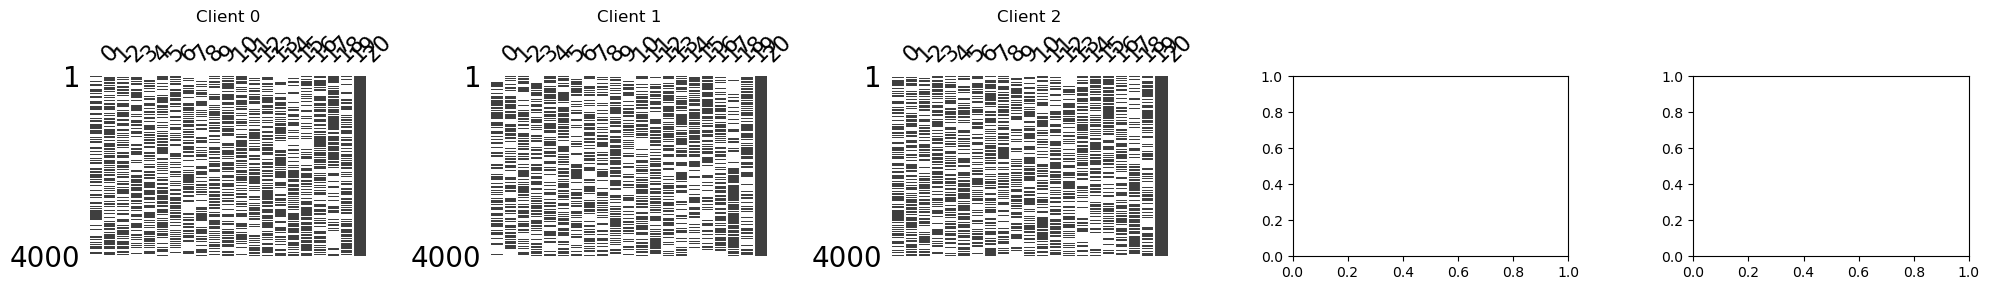

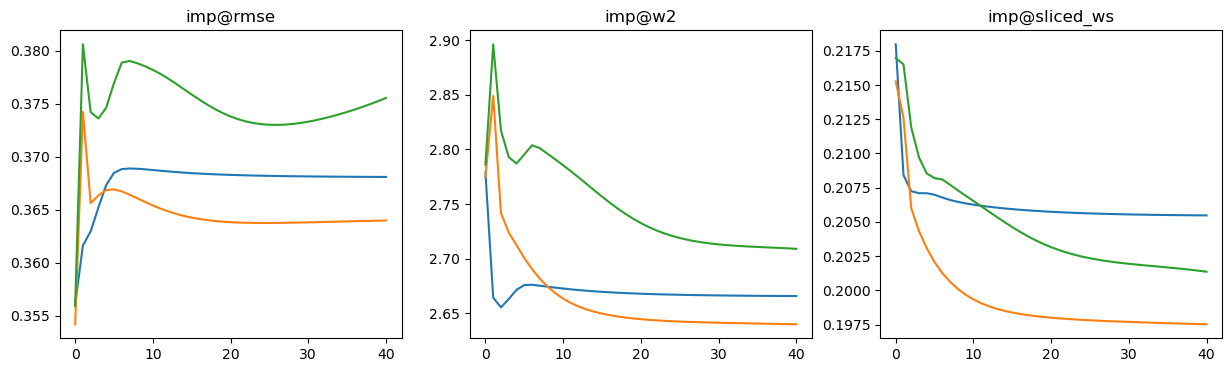

{'imp@rmse': 0.36900201832113816, 'imp@ws': 2.671988062526682, 'imp@sliced_ws': 0.20151167997703592}


In [38]:
name = 'mnar_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [46]:
pred_ret = NN_evaluation(rets['mnar_lr12_local'], type='fedavg', n_rounds=500)

2023-07-21 14:51:27.073 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6423, test_f1: 0.6339, val_loss: 0.6317, val_accu: 0.6379, val_f1: 0.6327
2023-07-21 14:52:32.769 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6387, test_f1: 0.6262, val_loss: 0.6889, val_accu: 0.6242, val_f1: 0.6233
2023-07-21 14:53:38.663 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6132, test_f1: 0.5983, val_loss: 0.7319, val_accu: 0.6121, val_f1: 0.6119
2023-07-21 14:54:45.260 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5979, test_f1: 0.5820, val_loss: 0.7286, val_accu: 0.6100, val_f1: 0.6100
2023-07-21 14:55:50.755 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5918, test_f1: 0.575

0.6950502216993937


### Simple Average

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right']
(11051, 21)


2023-07-21 14:35:31.051 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 184.30382679996546


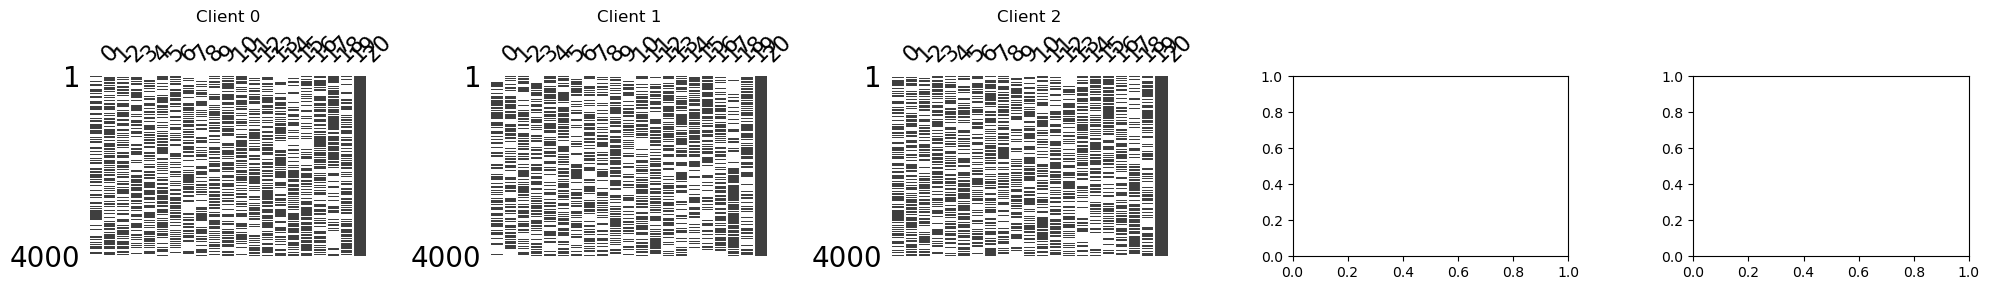

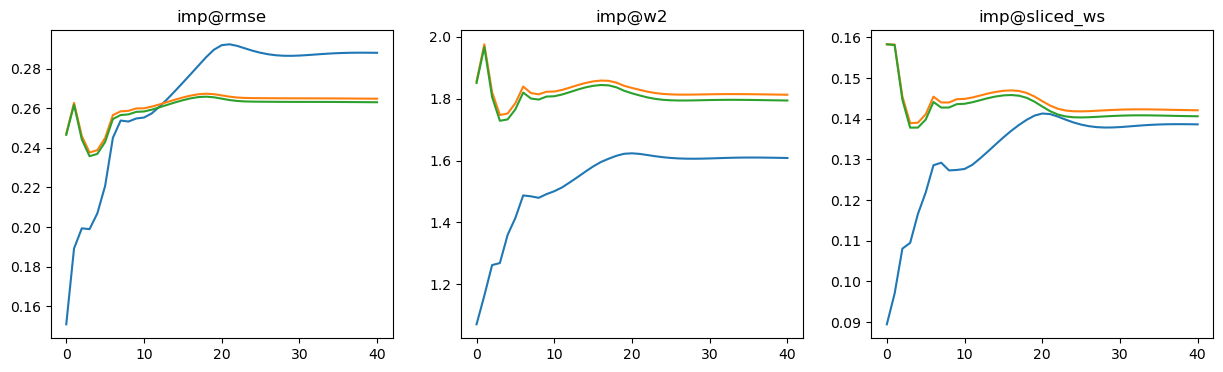

{'imp@rmse': 0.27192915505485, 'imp@ws': 1.7389833677373319, 'imp@sliced_ws': 0.14046797840185635}


In [39]:
name = 'mnar_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = copy.deepcopy(ret)

In [48]:
pred_ret = NN_evaluation(rets['mnar_lr12_savg'], type='fedavg', n_rounds=500)

2023-07-21 15:14:22.027 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7013, test_f1: 0.7009, val_loss: 0.6206, val_accu: 0.6538, val_f1: 0.6532
2023-07-21 15:15:26.383 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7194, test_f1: 0.7183, val_loss: 0.6293, val_accu: 0.6367, val_f1: 0.6366
2023-07-21 15:16:30.600 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7102, test_f1: 0.7075, val_loss: 0.6333, val_accu: 0.6308, val_f1: 0.6308
2023-07-21 15:17:34.883 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6833, test_f1: 0.6793, val_loss: 0.6418, val_accu: 0.6229, val_f1: 0.6223
2023-07-21 15:18:40.092 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6638, test_f1: 0.658

0.7564021355533436


### Our

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right']
(11051, 21)


2023-07-21 14:38:52.714 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 187.81521719996817


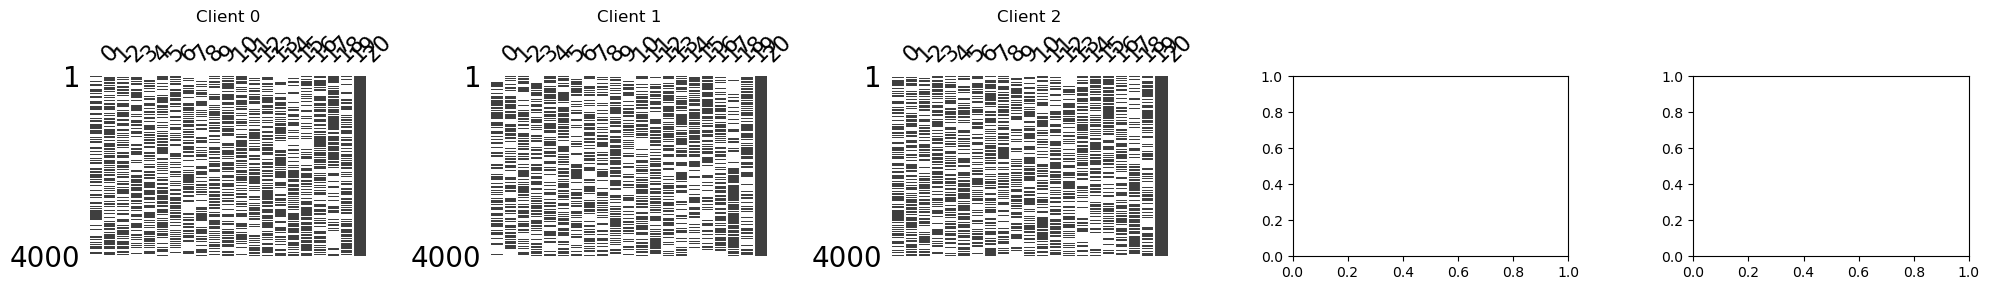

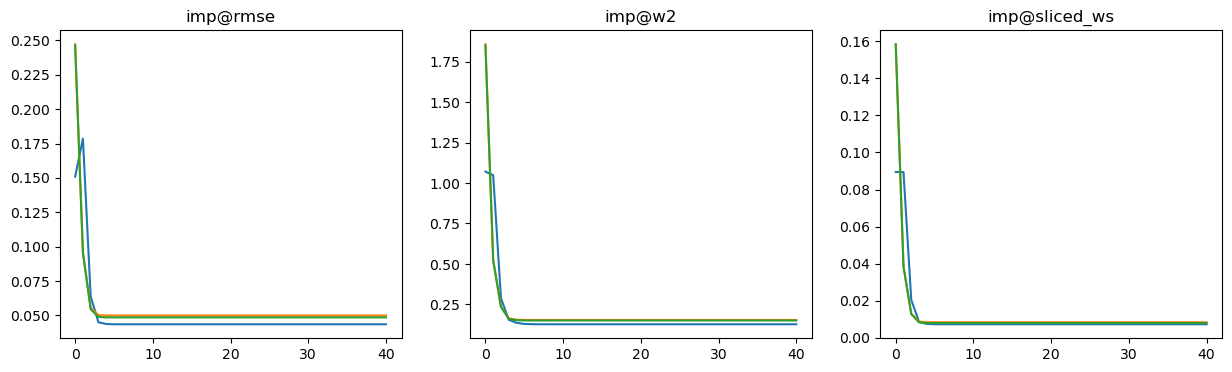

{'imp@rmse': 0.04740248337809446, 'imp@ws': 0.1444007773415774, 'imp@sliced_ws': 0.007926667985850035}


In [40]:
name = 'mnar_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = copy.deepcopy(ret)

In [49]:
pred_ret = NN_evaluation(rets['mnar_lr12_fedmechw'], type='fedavg', n_rounds=500)

2023-07-21 15:24:29.282 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.9039, test_f1: 0.9038, val_loss: 0.3605, val_accu: 0.8571, val_f1: 0.8570
2023-07-21 15:25:39.023 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.9230, test_f1: 0.9229, val_loss: 0.3335, val_accu: 0.8658, val_f1: 0.8658
2023-07-21 15:26:49.891 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9357, test_f1: 0.9356, val_loss: 0.3110, val_accu: 0.8775, val_f1: 0.8775
2023-07-21 15:28:01.216 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9407, test_f1: 0.9407, val_loss: 0.2987, val_accu: 0.8771, val_f1: 0.8771
2023-07-21 15:29:09.548 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9424, test_f1: 0.942

0.9467921455071939


## MNAR LR 2:1

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right']
(11051, 21)


2023-07-21 14:42:16.046 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 189.56405170005746


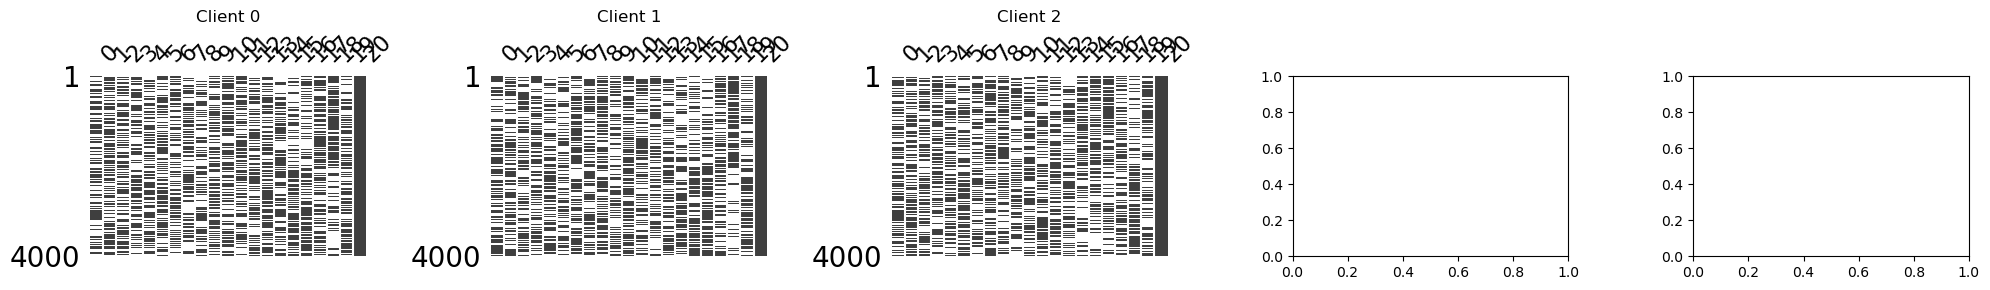

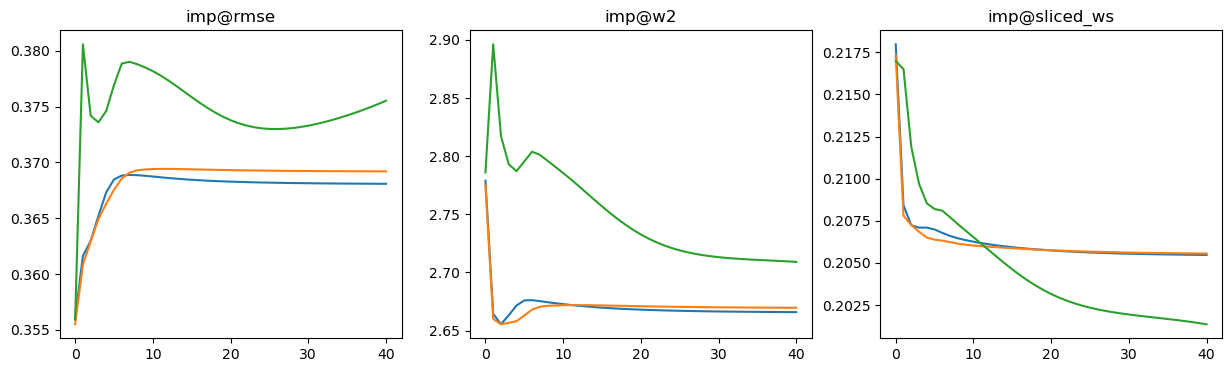

{'imp@rmse': 0.37075334385333625, 'imp@ws': 2.681778370588996, 'imp@sliced_ws': 0.20418210061650308}


In [41]:
name = 'mnar_lr21_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [50]:
pred_ret = NN_evaluation(rets['mnar_lr21_local'], type='fedavg', n_rounds=500)

2023-07-21 15:35:42.754 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7057, test_f1: 0.7034, val_loss: 0.6819, val_accu: 0.5679, val_f1: 0.5667
2023-07-21 15:36:47.389 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6931, test_f1: 0.6898, val_loss: 0.7201, val_accu: 0.5558, val_f1: 0.5519
2023-07-21 15:37:53.559 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6659, test_f1: 0.6589, val_loss: 0.7987, val_accu: 0.5292, val_f1: 0.5211
2023-07-21 15:38:58.729 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6318, test_f1: 0.6201, val_loss: 0.8795, val_accu: 0.5129, val_f1: 0.5025
2023-07-21 15:40:04.747 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6151, test_f1: 0.600

0.7068138629988236


### Simple Average

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right']
(11051, 21)


2023-07-21 16:04:23.178 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 202.57688149996102


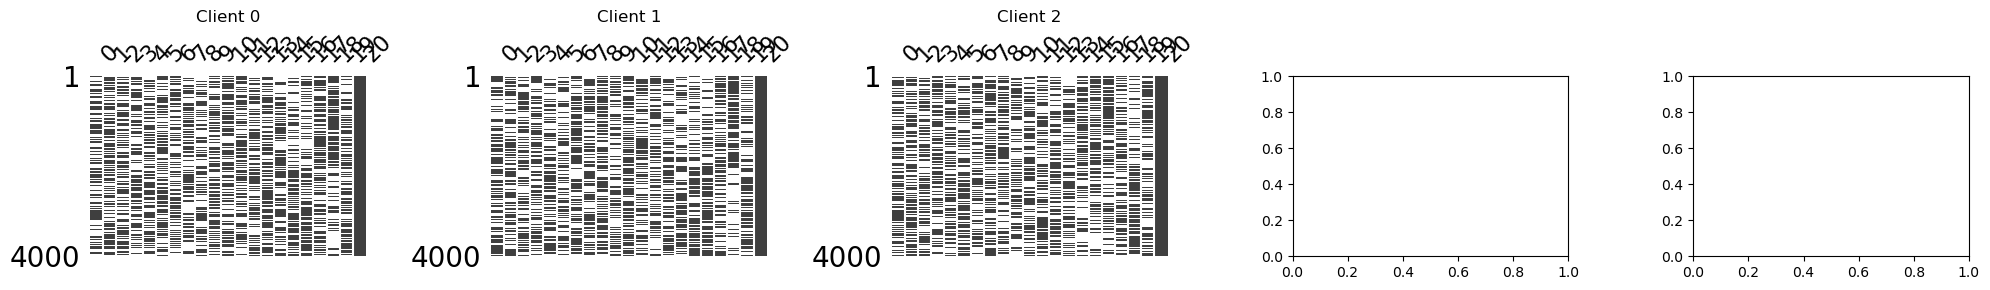

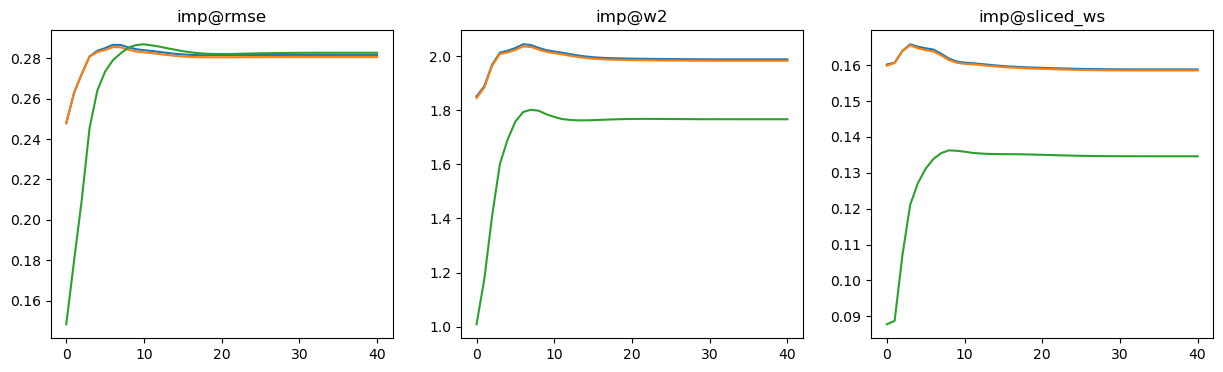

{'imp@rmse': 0.2816484322778277, 'imp@ws': 1.912607595913656, 'imp@sliced_ws': 0.15065309393952486}


In [52]:
name = 'mnar_lr21_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [53]:
pred_ret = NN_evaluation(rets['mnar_lr21_savg'], type='fedavg', n_rounds=500)

2023-07-21 16:05:31.770 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7013, test_f1: 0.7009, val_loss: 0.6206, val_accu: 0.6538, val_f1: 0.6532
2023-07-21 16:06:38.344 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7194, test_f1: 0.7183, val_loss: 0.6293, val_accu: 0.6367, val_f1: 0.6366
2023-07-21 16:07:45.812 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7102, test_f1: 0.7075, val_loss: 0.6333, val_accu: 0.6308, val_f1: 0.6308
2023-07-21 16:09:02.896 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6833, test_f1: 0.6793, val_loss: 0.6418, val_accu: 0.6229, val_f1: 0.6223
2023-07-21 16:10:09.914 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6638, test_f1: 0.658

0.7564021355533436


### Our Models

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right']
(11051, 21)


2023-07-21 16:18:20.990 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 197.03045790002216


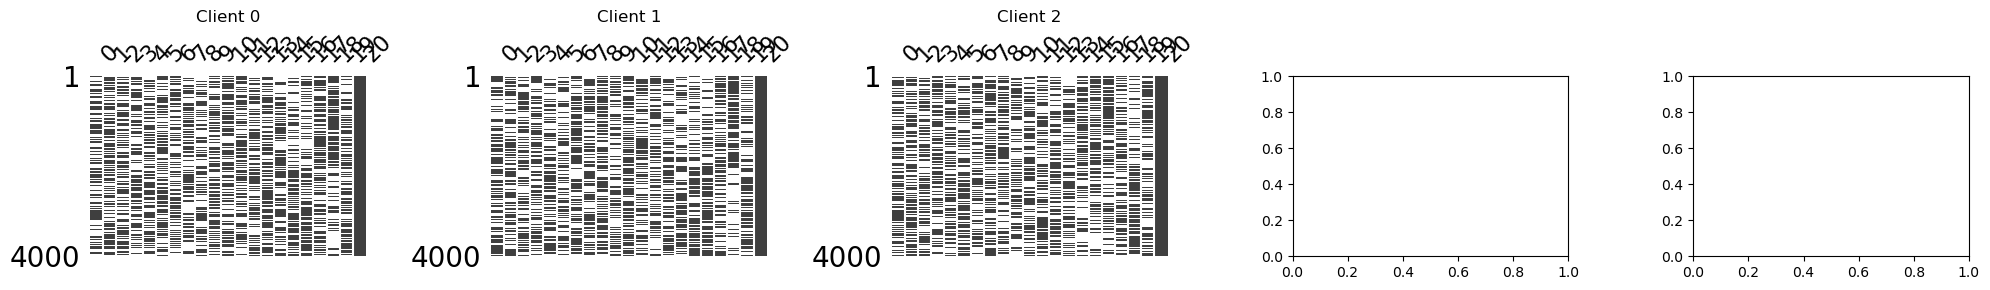

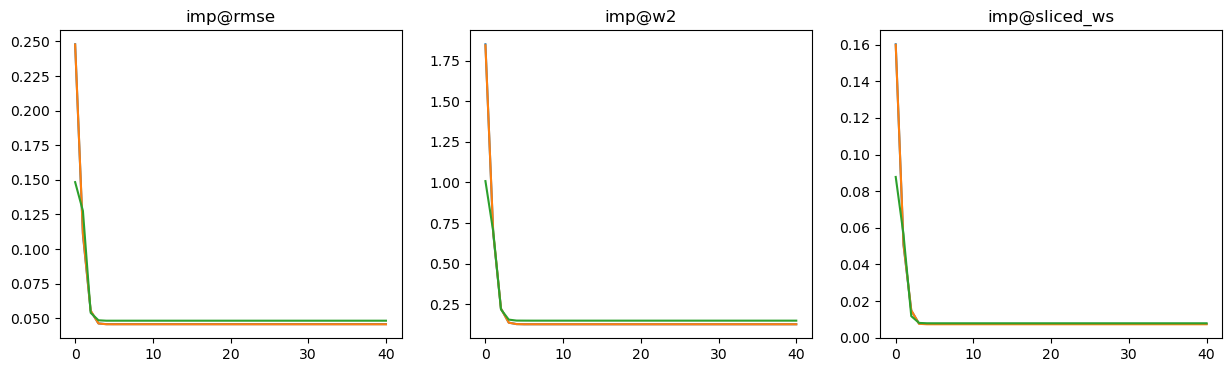

{'imp@rmse': 0.046523048058114615, 'imp@ws': 0.13425840719470056, 'imp@sliced_ws': 0.007581768452353393}


In [54]:
name = 'mnar_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [55]:
pred_ret = NN_evaluation(rets['mnar_lr21_fedmechw'], type='fedavg', n_rounds=500)

2023-07-21 16:19:26.483 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.9039, test_f1: 0.9038, val_loss: 0.3605, val_accu: 0.8571, val_f1: 0.8570
2023-07-21 16:20:29.136 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.9230, test_f1: 0.9229, val_loss: 0.3335, val_accu: 0.8658, val_f1: 0.8658
2023-07-21 16:21:40.737 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9357, test_f1: 0.9356, val_loss: 0.3110, val_accu: 0.8775, val_f1: 0.8775
2023-07-21 16:22:50.470 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9407, test_f1: 0.9407, val_loss: 0.2987, val_accu: 0.8771, val_f1: 0.8771
2023-07-21 16:24:00.095 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9424, test_f1: 0.942

0.9467921455071939


## MARY LR 1:2

### Local 

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_right' 'mary_sigmoid_right']
(11051, 21)


2023-07-21 17:27:14.245 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 190.28024220000952


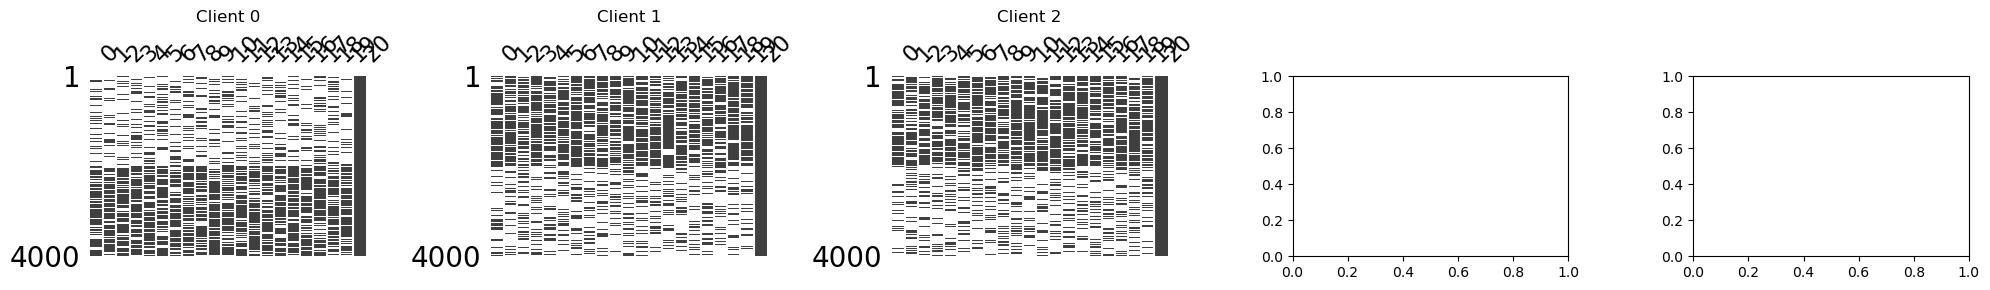

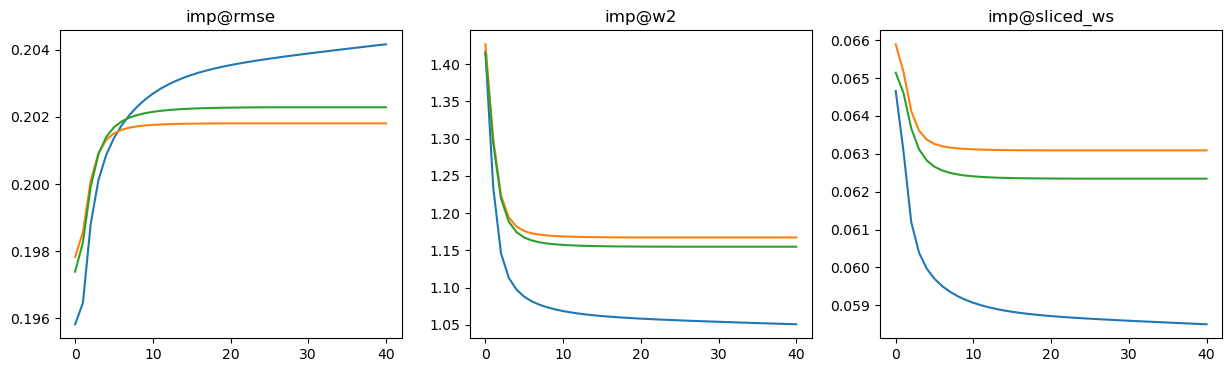

{'imp@rmse': 0.2027357593089986, 'imp@ws': 1.1244705055553461, 'imp@sliced_ws': 0.06131600765196284}


In [62]:
name = 'mary_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

### Simple Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_right' 'mary_sigmoid_right']
(11051, 21)


2023-07-21 17:30:32.315 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 182.91059739992488


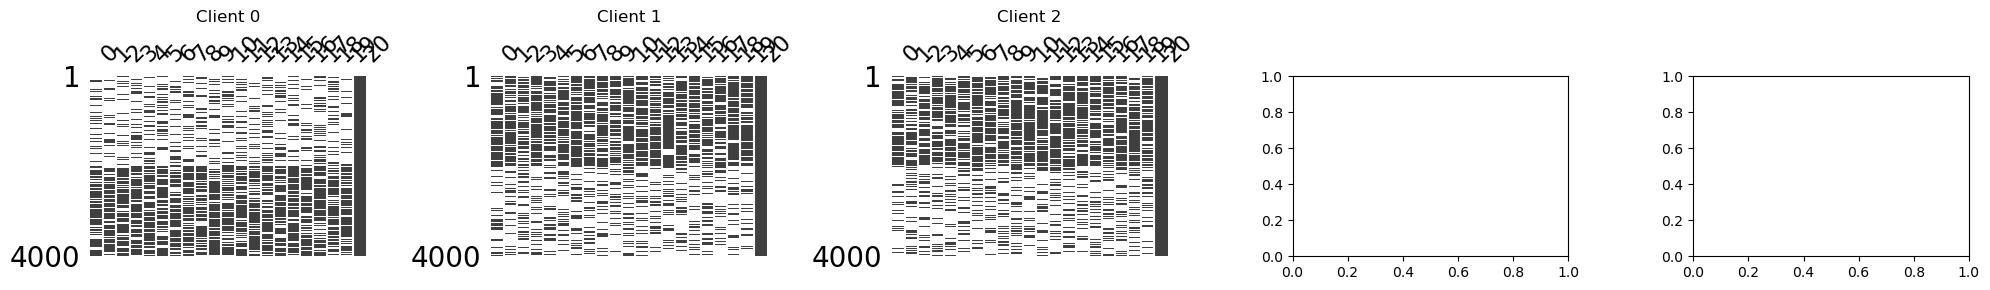

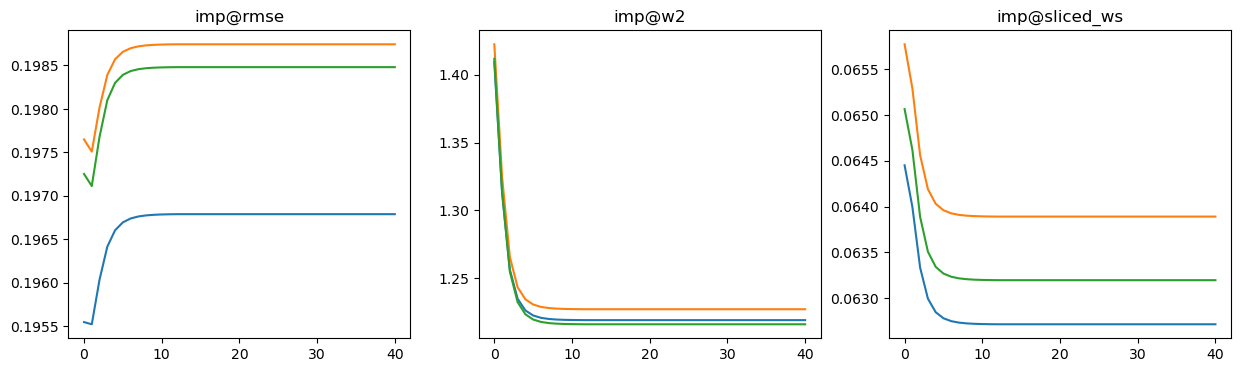

{'imp@rmse': 0.1980047888004091, 'imp@ws': 1.220573151405494, 'imp@sliced_ws': 0.06326677906217326}


In [63]:
name = 'mary_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

### Our Method

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_right' 'mary_sigmoid_right']
(11051, 21)


2023-07-21 17:33:53.779 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 187.56578619999345


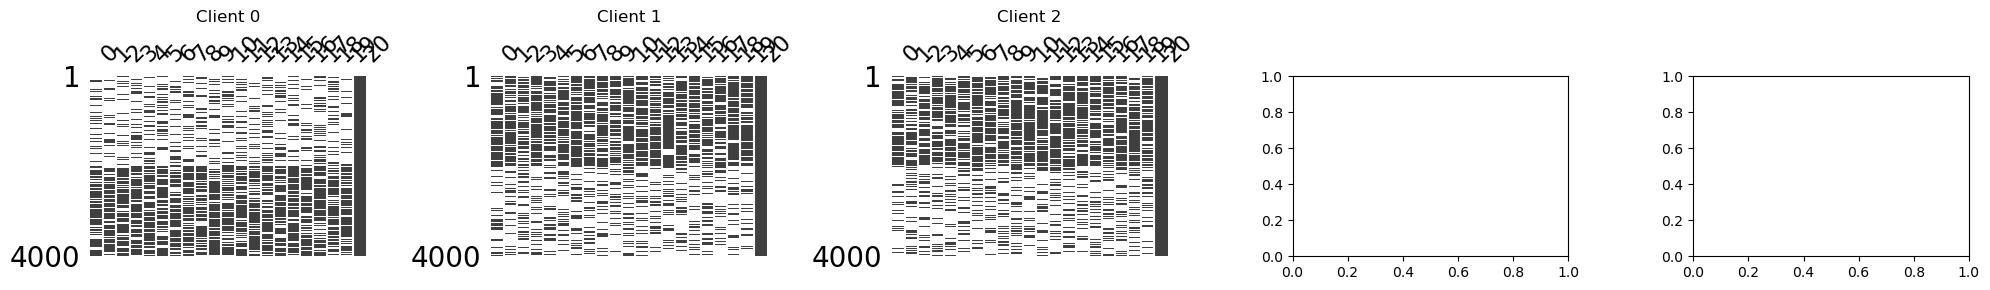

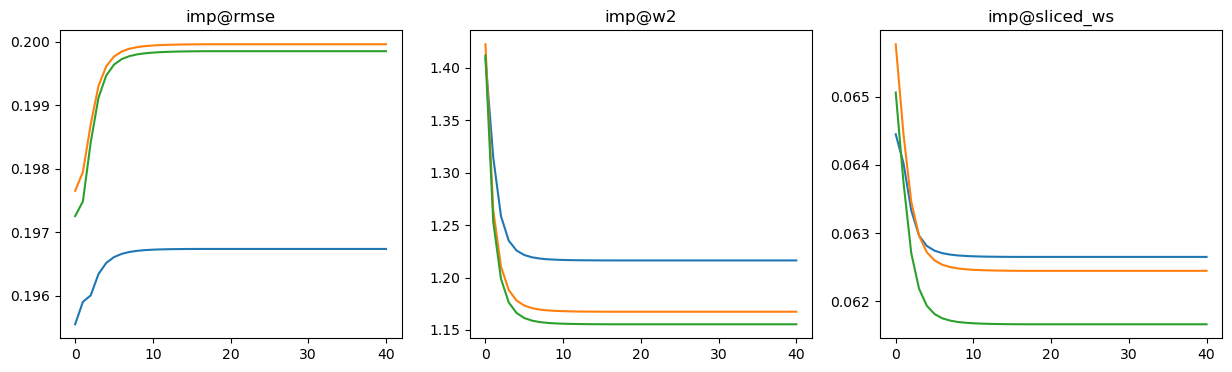

{'imp@rmse': 0.19884651289312663, 'imp@ws': 1.1796854824810687, 'imp@sliced_ws': 0.062251235410251377}


In [64]:
name = 'mary_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MARY LR 2:1

### Local

### Simpel Averaging

### Ours

## Debugging and Visualization

In [78]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [106]:
def vis_local_model_sim_lr(tracker1, tracker2, iteration, model = 'local', metric = 'mm'):
    n_cols = 4
    n_rows = 5

    ret1, ret2 = [], []
    for feature_idx in range(n_rows * n_cols):
        clients_records1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx]
        clients_records2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx]

        if model == 'local':
            X1 = clients_records1[0].local_imp_model_params
            X2 = clients_records2[0].local_imp_model_params
            ret1.append(X1)
            ret2.append(X2)
        elif model == 'mm':
            X1 = clients_records1[0].local_mm_model_params
            X2 = clients_records2[0].local_mm_model_params
            ret1.append(X1)
            ret2.append(X2)
        else:
            raise NotImplementedError
    
    ret1 = np.array(ret1)
    ret2 = np.array(ret2)

    for client_idx in range(n_rows * n_cols):
        print("========================================================")
        X1 = ret1[:, client_idx, :]
        X2 = ret2[:, client_idx, :]
        avg = []
        for feature_idx in range(X1.shape[0]):
            x1 = X1[feature_idx]
            x2 = X2[feature_idx]
            cos_sim = cosine_similarity(x1.reshape(1, -1), x2.reshape(1, -1))[0][0]
            print(
                "client {} feature {} - cos_sim between mary left and right local model {:4f}".
                format(client_idx, feature_idx, cos_sim)
            )
            avg.append(cos_sim)
        print("Avg cos sim all features local imputation model {:.4f}".format(np.mean(avg)))

In [79]:
def vis_local_model_sim(tracker, iteration, model = 'local', metric = 'cos'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        elif metric == 'l2':
            cosine_sim = euclidean_distances(X)
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model_sim_t(tracker, iteration, model = 'local'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        cosine_sim = 1 - (cosine_similarity(X) + 1)/2
        cosine_sim = np.where(cosine_sim > 0.4, 1, 0)
        sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model(tracker, iteration, model = 'local', decomp = 'PCA'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        if decomp == 'PCA':
            pca = PCA(n_components=2)
            decomp_results = pca.fit_transform(X)
        else:
            raise NotImplementedError
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        sns.scatterplot(
            x=decomp_results[:,0], y=decomp_results[:,1],
            palette=sns.color_palette("hls", 10),
            legend="full",
            ax=ax
        )
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

### MNAR LR

In [107]:
tracker0 = trackers['mary_left_local']
tracker1 = trackers['mary_right_local']
tracker3 = trackers['mcar_local']

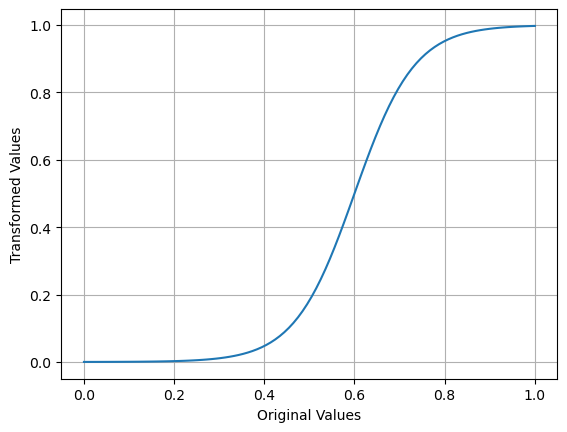

In [116]:
import numpy as np
import matplotlib.pyplot as plt

def transform_values(values):
    return 1 - 1 / (1 + np.exp(15 * (values - 0.6)))

# Generate a sequence of values between 0 and 1
values = np.linspace(0, 1, 100)

# Apply the transformation function
transformed_values = transform_values(values)

# Plot the transformation
plt.plot(values, transformed_values)
plt.xlabel('Original Values')
plt.ylabel('Transformed Values')
plt.grid(True)
plt.show()

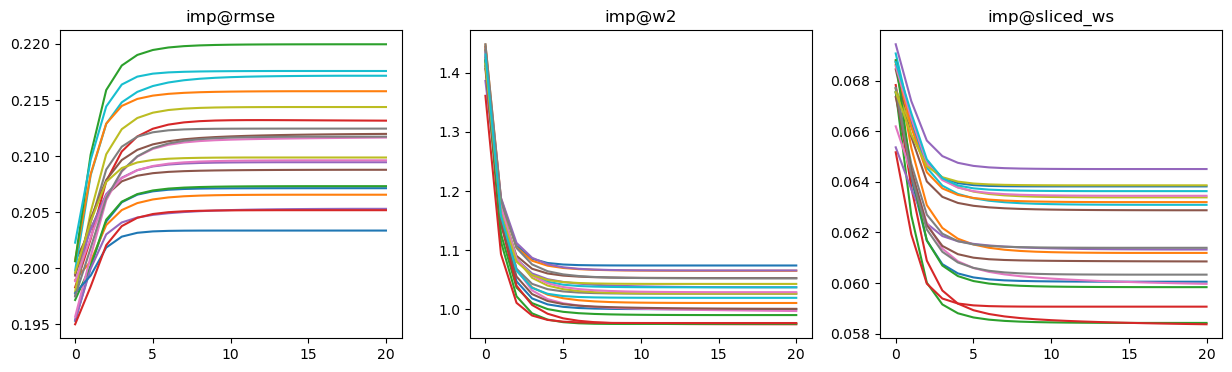

{'imp@rmse': 0.2109149942727615, 'imp@ws': 1.0226367154866451, 'imp@sliced_ws': 0.061636247155269955}
Accuracy imputed centralized MLP:0.5690 (0.009)
Accuracy imputed centralized LR:0.8452 (0.000)


In [ ]:
vis_imp(ret101)
print(ret101['imp_result'])
sklearn_evaluation(ret101)

In [108]:
vis_local_model_sim_lr(tracker0, tracker1, iteration = 1)

client 0 feature 0 - cos_sim between mary left and right local model 0.615036
client 0 feature 1 - cos_sim between mary left and right local model 0.712370
client 0 feature 2 - cos_sim between mary left and right local model 0.759527
client 0 feature 3 - cos_sim between mary left and right local model 0.525078
client 0 feature 4 - cos_sim between mary left and right local model 0.525728
client 0 feature 5 - cos_sim between mary left and right local model 0.745607
client 0 feature 6 - cos_sim between mary left and right local model 0.674075
client 0 feature 7 - cos_sim between mary left and right local model -0.504901
client 0 feature 8 - cos_sim between mary left and right local model 0.302579
client 0 feature 9 - cos_sim between mary left and right local model 0.256061
client 0 feature 10 - cos_sim between mary left and right local model 0.662537
client 0 feature 11 - cos_sim between mary left and right local model 0.924026
client 0 feature 12 - cos_sim between mary left and right loc

#### Local Model

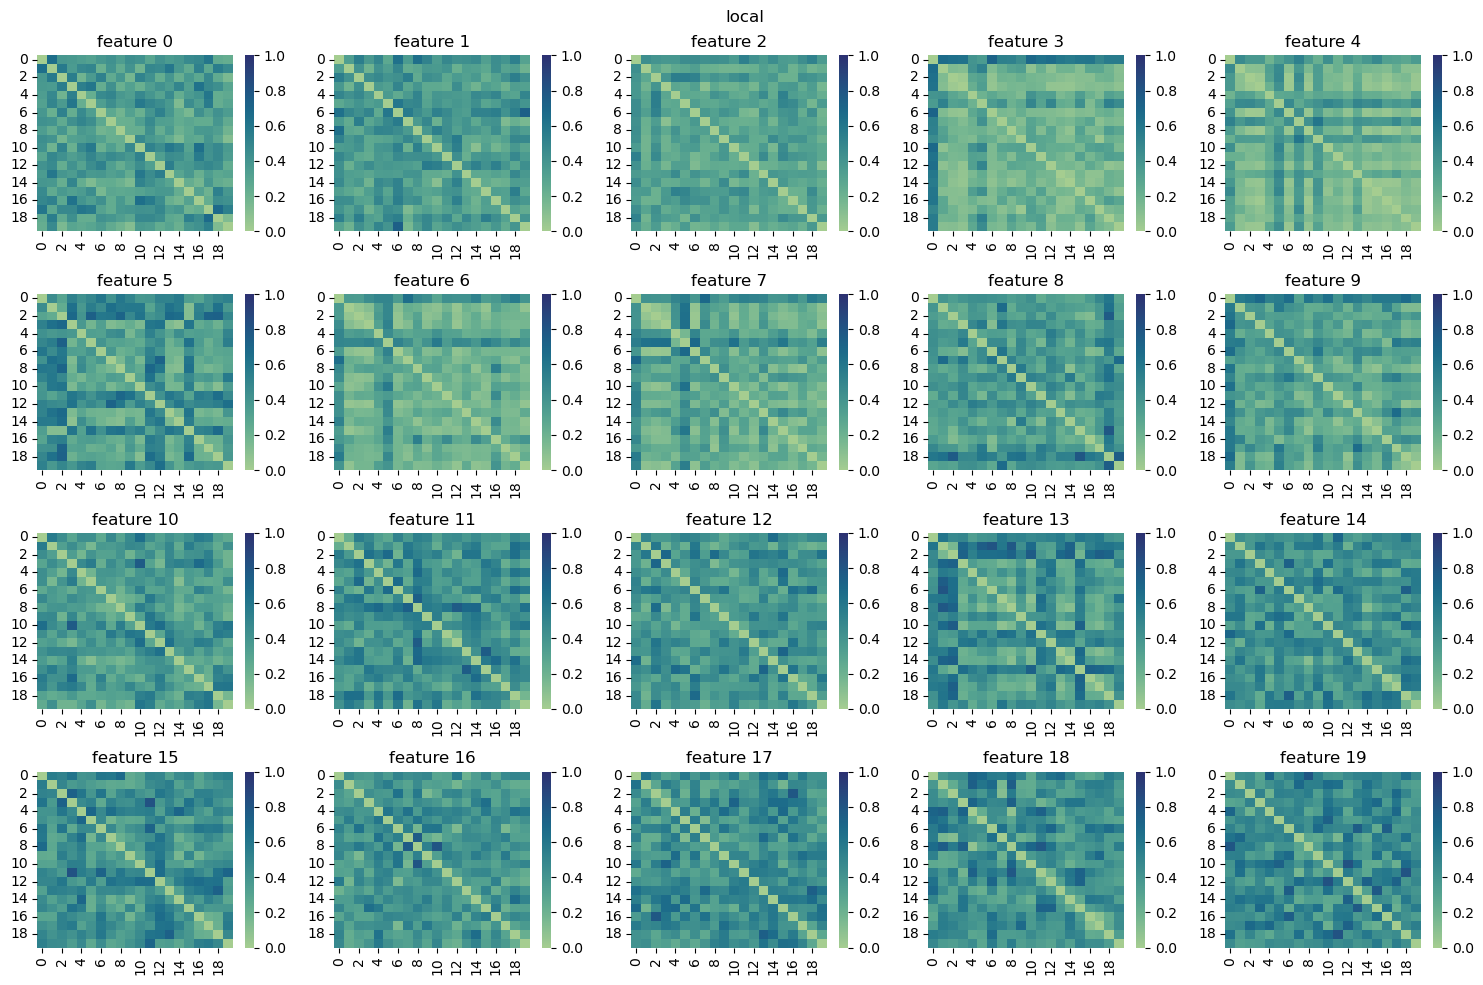

In [801]:
vis_local_model_sim(tracker0, iteration = 20, model='local')

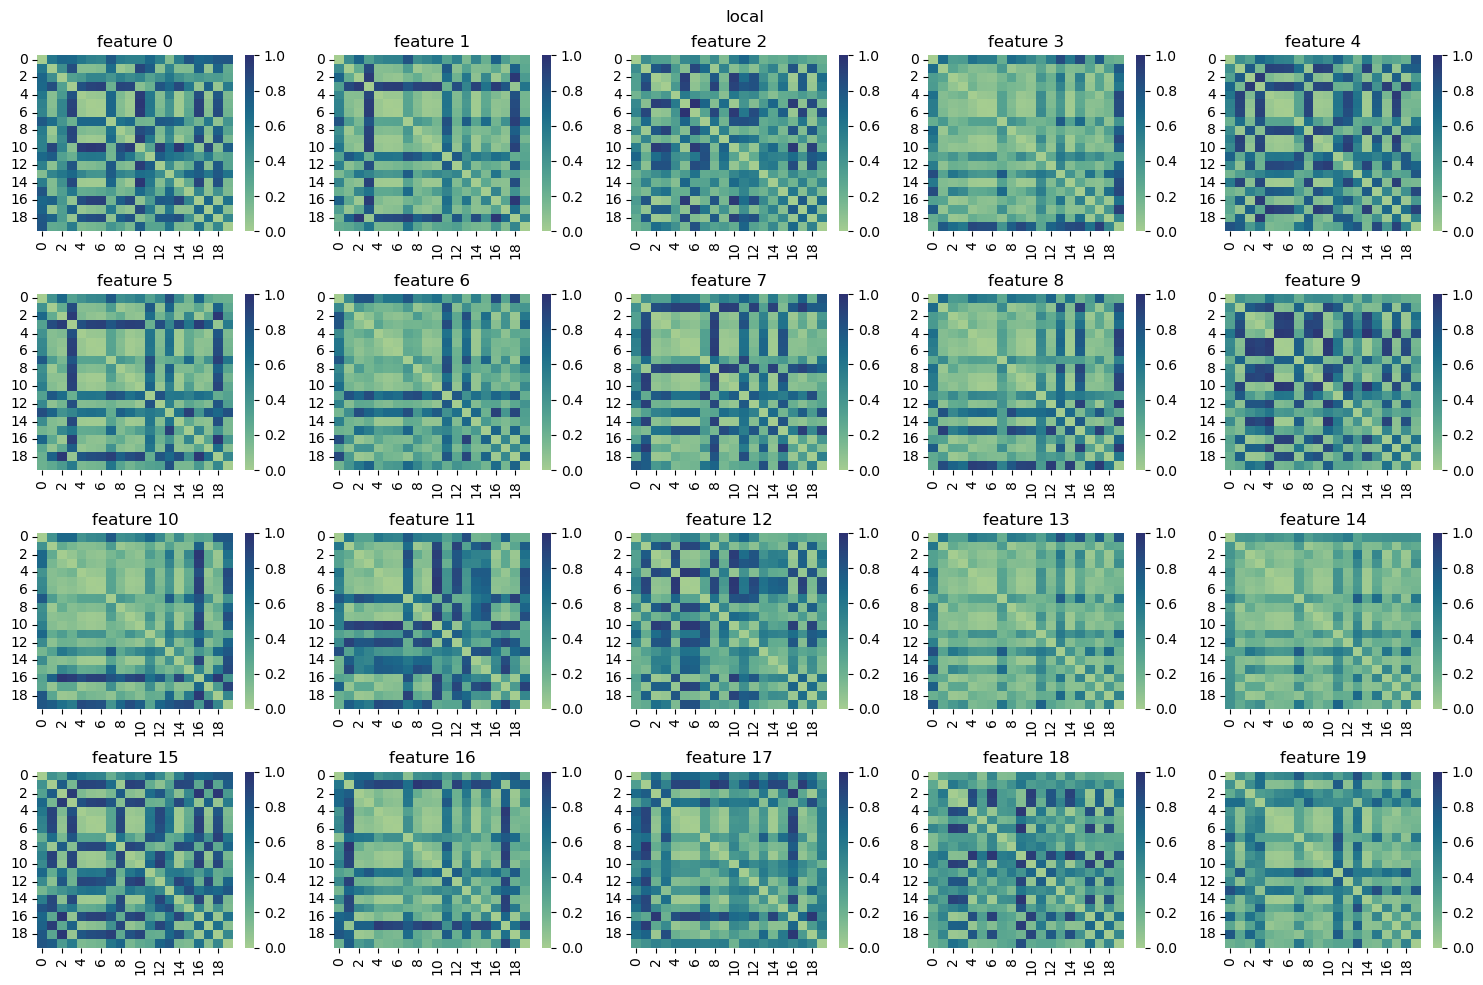

In [715]:
vis_local_model_sim(tracker4, iteration = 20, model='local', metric = 'cos')

In [601]:
coeff = [item for item in tracker4.records if item.feature_idx == 4 and item.iteration == 20][0]
coeff.local_imp_model_params.shape

(20, 20)

In [602]:
modela = coeff.local_imp_model_params[14]
modelb = coeff.local_imp_model_params[19]
print(np.dot(modela, modelb)/(np.linalg.norm(modela)*np.linalg.norm(modelb)))
1 - (np.dot(modela, modelb)/(np.linalg.norm(modela)*np.linalg.norm(modelb)) + 1)/2

-0.7665629970868363


0.8832814985434181

In [603]:
data_t = rets['mnar_lr_local2']['data']['imputed_data']
data_t1 = rets['mnar_lr_local2']['data']['origin_data']
msk_t = rets['mnar_lr_local2']['data']['missing_mask']
data_t = rets['mnar_lr_local2']['data']['imputed_data']
data_t1 = rets['mnar_lr_local2']['data']['origin_data']
msk_t = rets['mnar_lr_local2']['data']['missing_mask']
x14 = data_t[14, :, 4]
x14t = data_t1[14, :, 4]
m14 = msk_t[14, :, 4]
x19 = data_t[19, :, 4]
x19t = data_t1[19, :, 4]
m19 = msk_t[19, :, 4]

In [615]:
np.quantile(x14t, q = 0.5)

0.508101510837643

In [634]:
total_missing = int(missing_ratio * x14t.shape[0])
total_missing

645

In [631]:
end_indices = np.where(x14t == q)[0]
add_up_indices = np.random.choice(
					end_indices, size=total_missing - len(indices), replace=False
				)
na_indices = np.concatenate((indices, add_up_indices))

In [635]:
from src.fed_imp.sub_modules.missing_simulate.ms_simulate.mnar_simulate import simulate_nan_mnar_quantile

In [642]:
X = data_t1[14]
X_imp = simulate_nan_mnar_quantile(X, [4], 0.5, 'right', seed = 1)

In [646]:
msk = np.isnan(X_imp)
x14t = X[:, 4]

<Axes: ylabel='Count'>

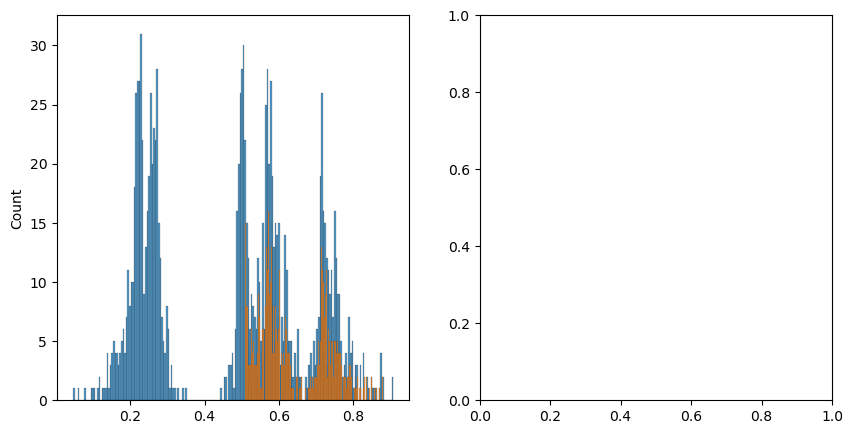

In [649]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(x = x14t, bins = 200, ax = ax[0])
sns.histplot(x = x14t[msk[:, 4]], bins = 200, ax = ax[0])

<Axes: ylabel='Count'>

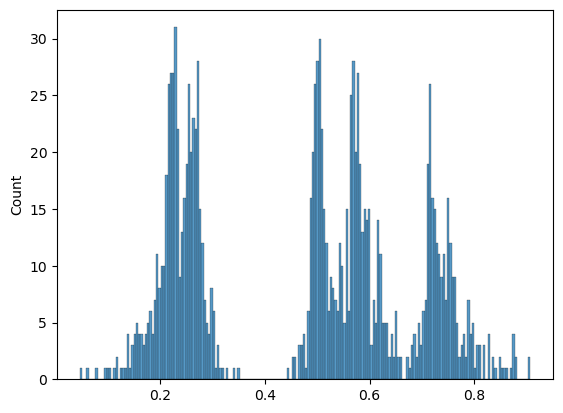

In [606]:
sns.histplot(x = x19t, bins = 200)

In [574]:
data14 = data_t[14]
x = data14[:, :-1]
print(x.shape)
x_ = np.delete(x, 4, axis=1)
x_ = x_[m14 == 1]
print(x_.shape)
x_ = np.concatenate([x_, np.ones(x_.shape[0]).reshape(-1,1)], axis=1)
print(x_.shape)
imputed14 = x_@modela
imputed14_ = x_@modelb
print(imputed14.shape)
print(imputed14_.shape)

(1290, 20)
(650, 19)
(650, 20)
(650,)
(650,)


In [577]:
print(np.mean(abs(imputed14 - x14[m14])))
print(np.mean(abs(imputed14_ - x14[m14])))

0.0009407086610696447
0.27718427230024695


In [559]:
data19 = data_t[19]
x1 = data19[:, :-1]
print(x1.shape)
x1_ = np.delete(x1, 4, axis=1)
print(x1_.shape)
x1_ = np.concatenate([x1_, np.ones(x1_.shape[0]).reshape(-1,1)], axis=1)
print(x1_.shape)
imputed19 = x1_@modelb
imputed19_ = x1_@modela
print(imputed19.shape)

(1290, 20)
(1290, 19)
(1290, 20)
(1290,)


In [553]:
data_t = rets['mnar_lr_local2']['data']['imputed_data']
data_t1 = rets['mnar_lr_local2']['data']['origin_data']
msk_t = rets['mnar_lr_local2']['data']['missing_mask']
x14 = data_t[14, :, 4]
x14t = data_t1[14, :, 4]
m14 = msk_t[14, :, 4]
x19 = data_t[19, :, 4]
x19t = data_t1[19, :, 4]
m19 = msk_t[19, :, 4]

In [587]:
print(np.mean(imputed14 - x14[m14]))
print(np.mean(imputed14_ - x14[m14]))
# print(np.mean(imputed19_[m19] - x19[m19]))
# print(np.mean(imputed14 - x14t))
# print(np.mean(imputed14_ - x14t))
# print(np.mean(imputed19 - x19t))
abs(x14 - x19)[m14&m19][0:10]

-7.997146616176172e-05
0.011285173673500577


array([0.19332482, 0.14889582, 0.23502049, 0.2244214 , 0.14421803,
       0.14190096, 0.15927668, 0.12195078, 0.09475234, 0.08357951])

In [571]:
print(x_[m14][0:10]@modela)
print(x_[m14][0:10]@modelb)

[0.22733894 0.34543996 0.48686648 0.50337852 0.66328734 0.32248817
 0.46773045 0.22217764 0.36629912 0.43619056]
[-0.03119907  0.96108286 -0.01190617  0.17546759  0.32601026  0.49384357
  0.71598779  0.04918428  0.98419777  0.46419465]


In [506]:
np.mean(x19[(m19==1)&(m14==1)] - x14[(m19==1)&(m14==1)])

-0.009311017329282724

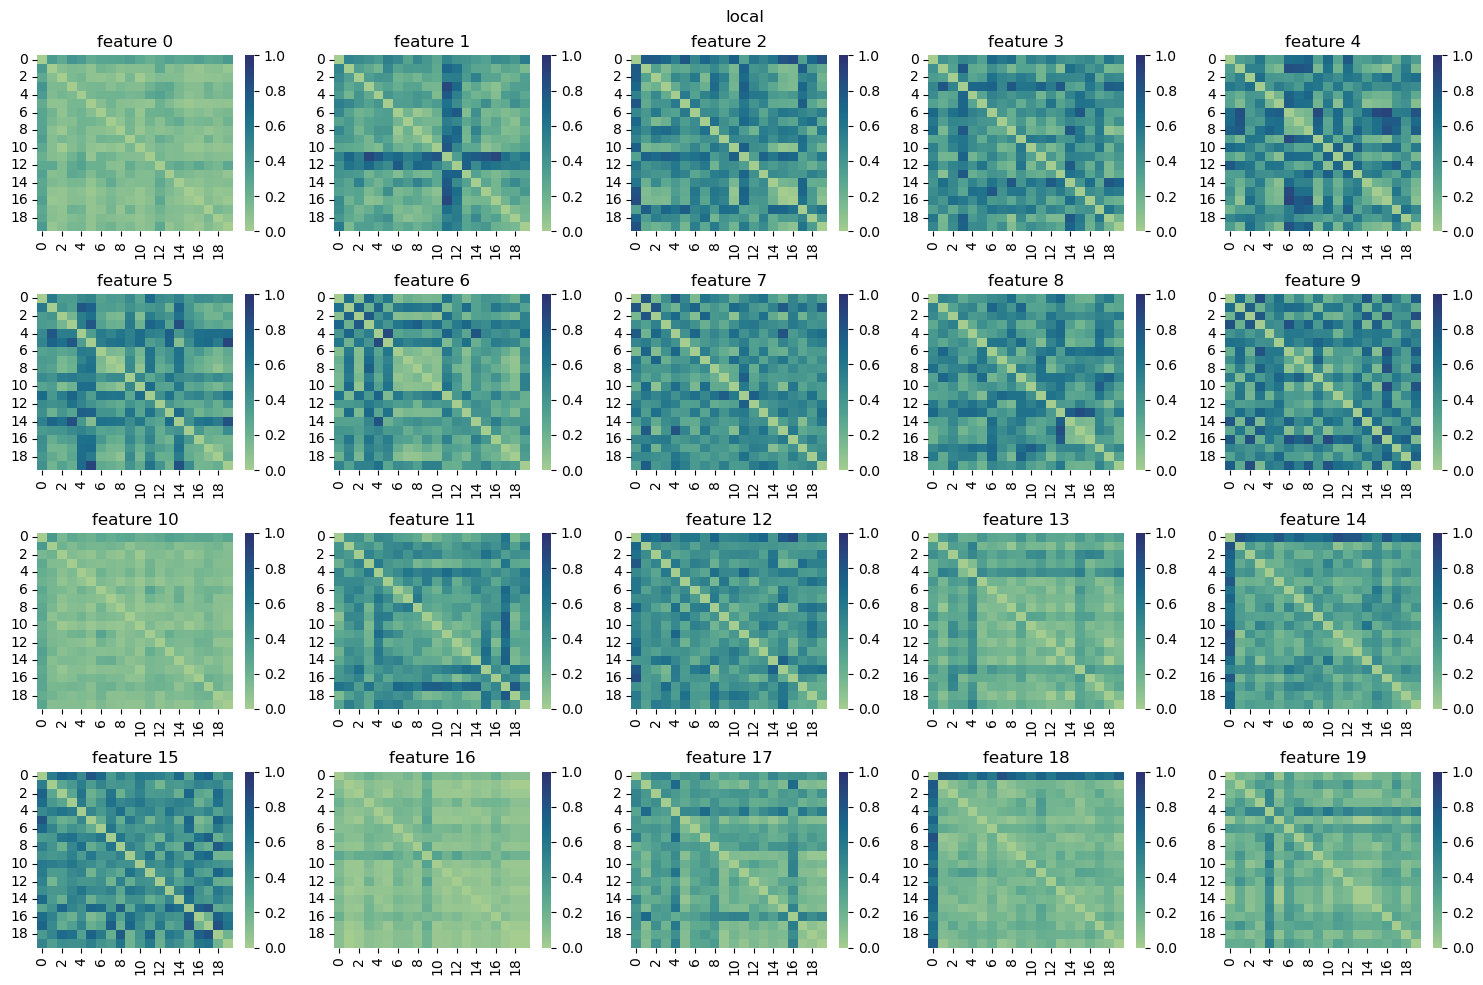

In [303]:
vis_local_model_sim(tracker0, iteration = 4, model='local')

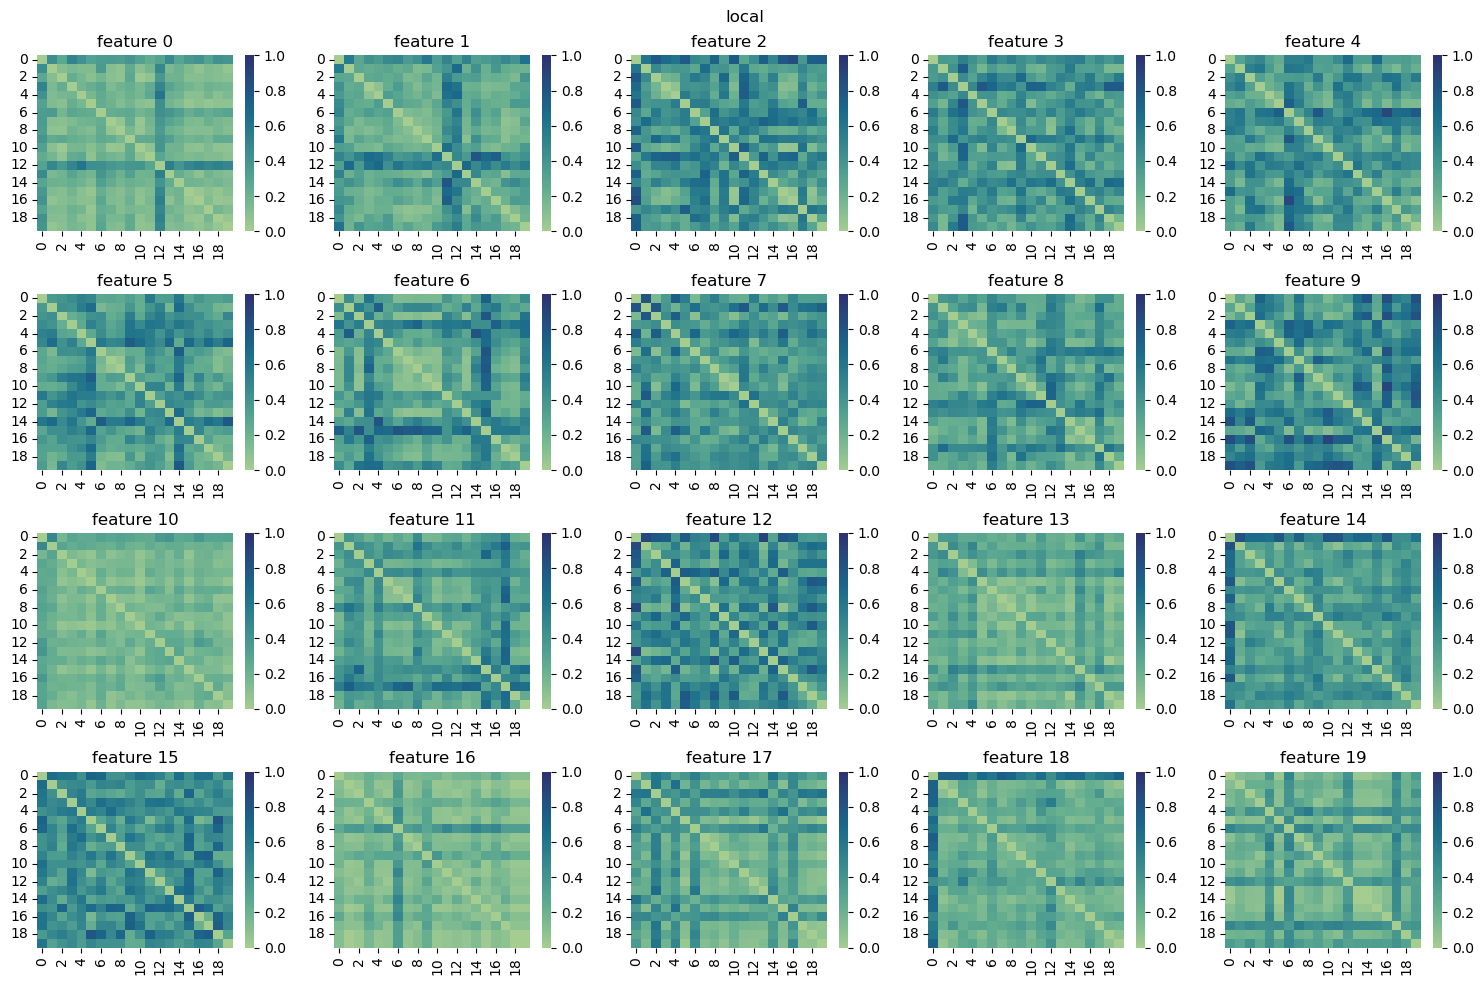

In [304]:
vis_local_model_sim(tracker0, iteration = 20, model='local')

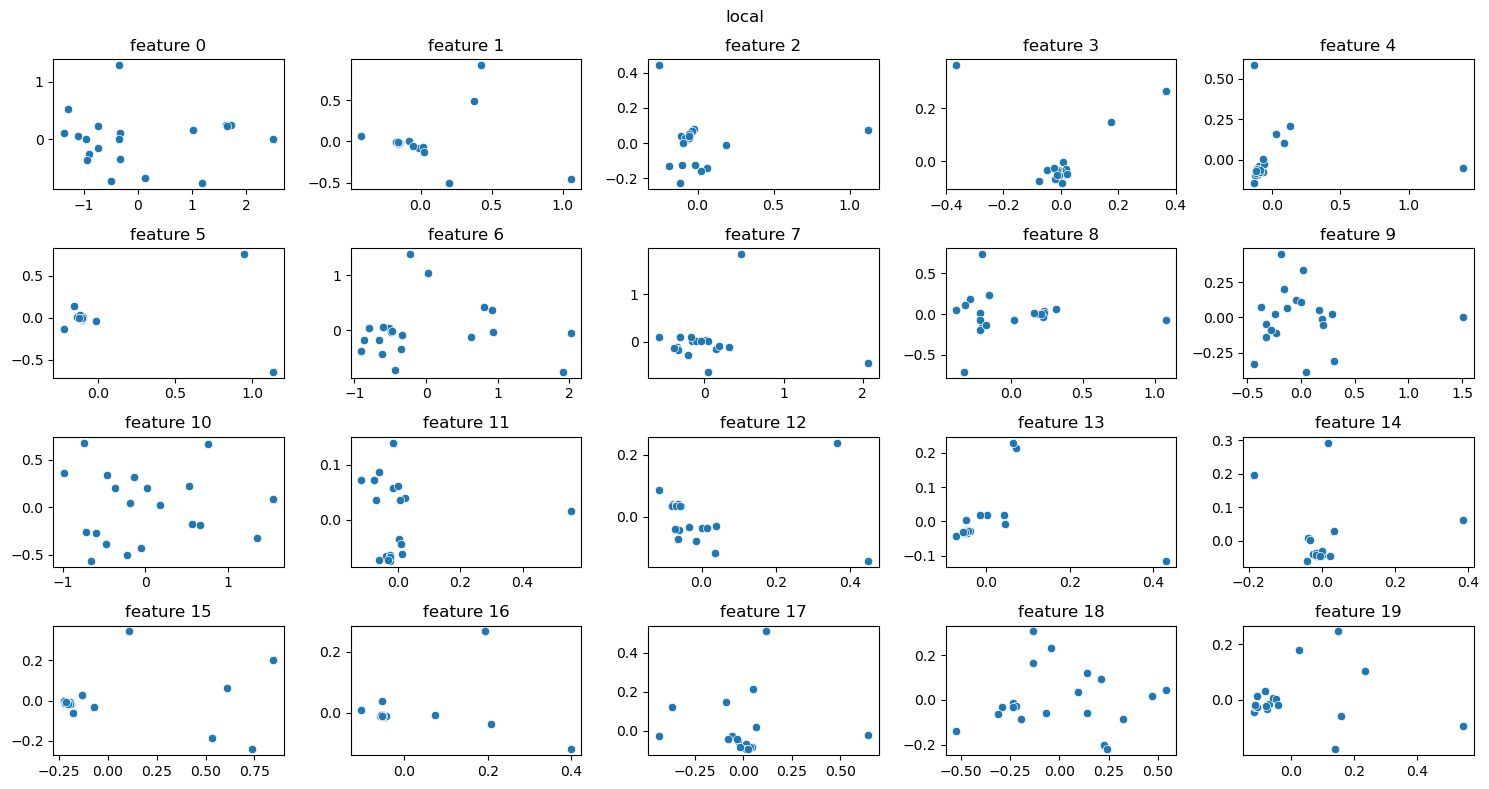

In [187]:
vis_local_model(tracker, iteration = 1, model = 'local', decomp = 'PCA')

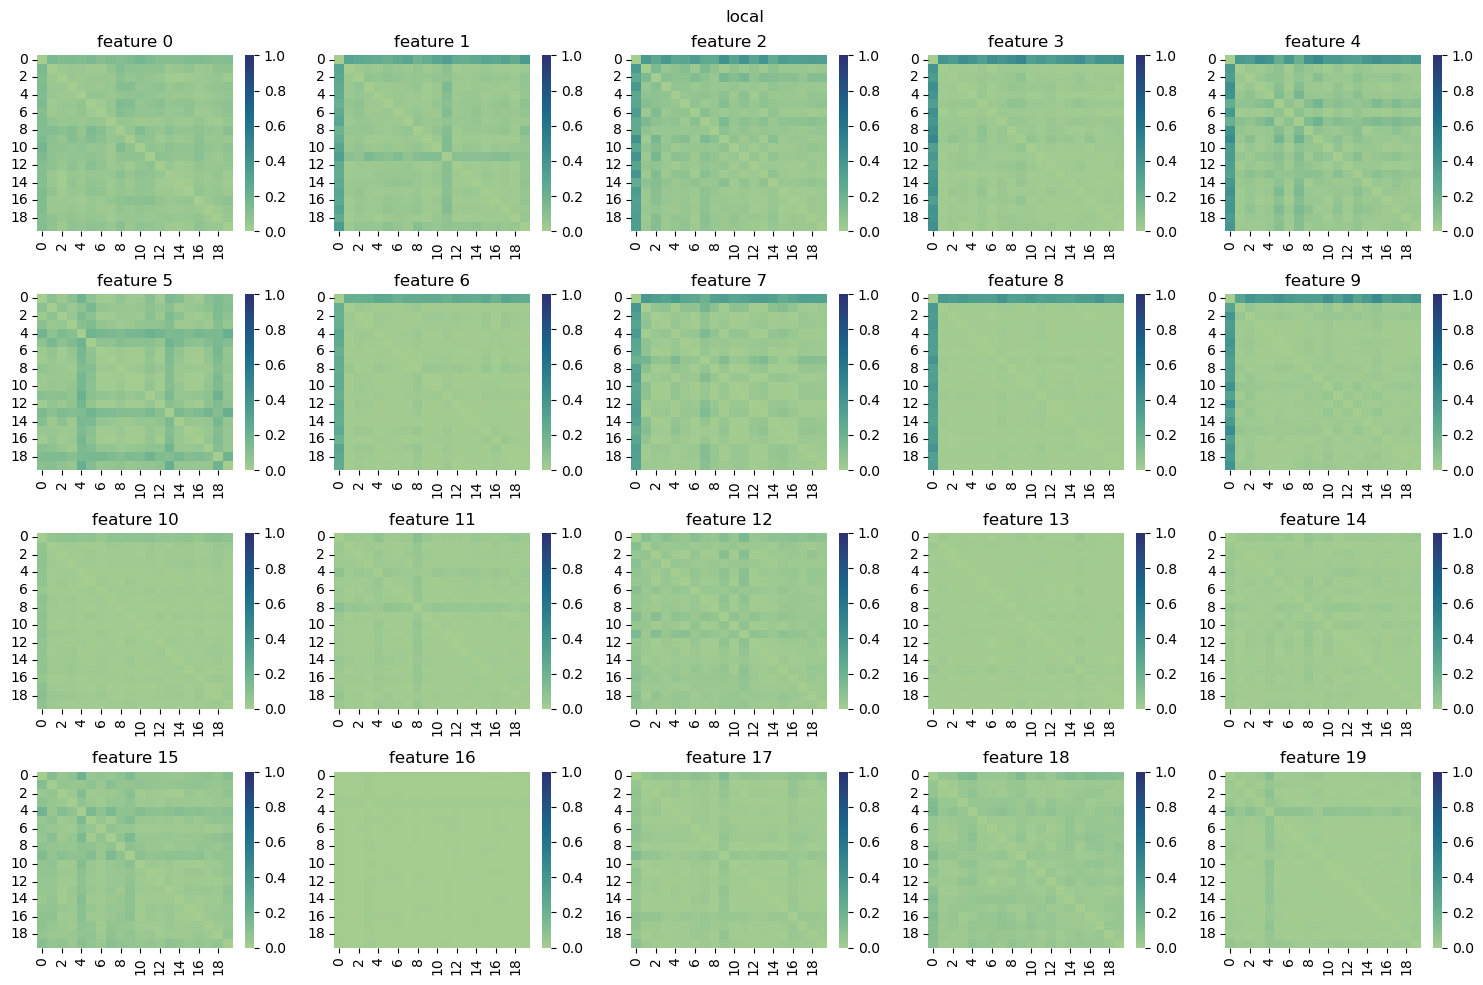

In [802]:
vis_local_model_sim(tracker, iteration = 1, model = 'local')

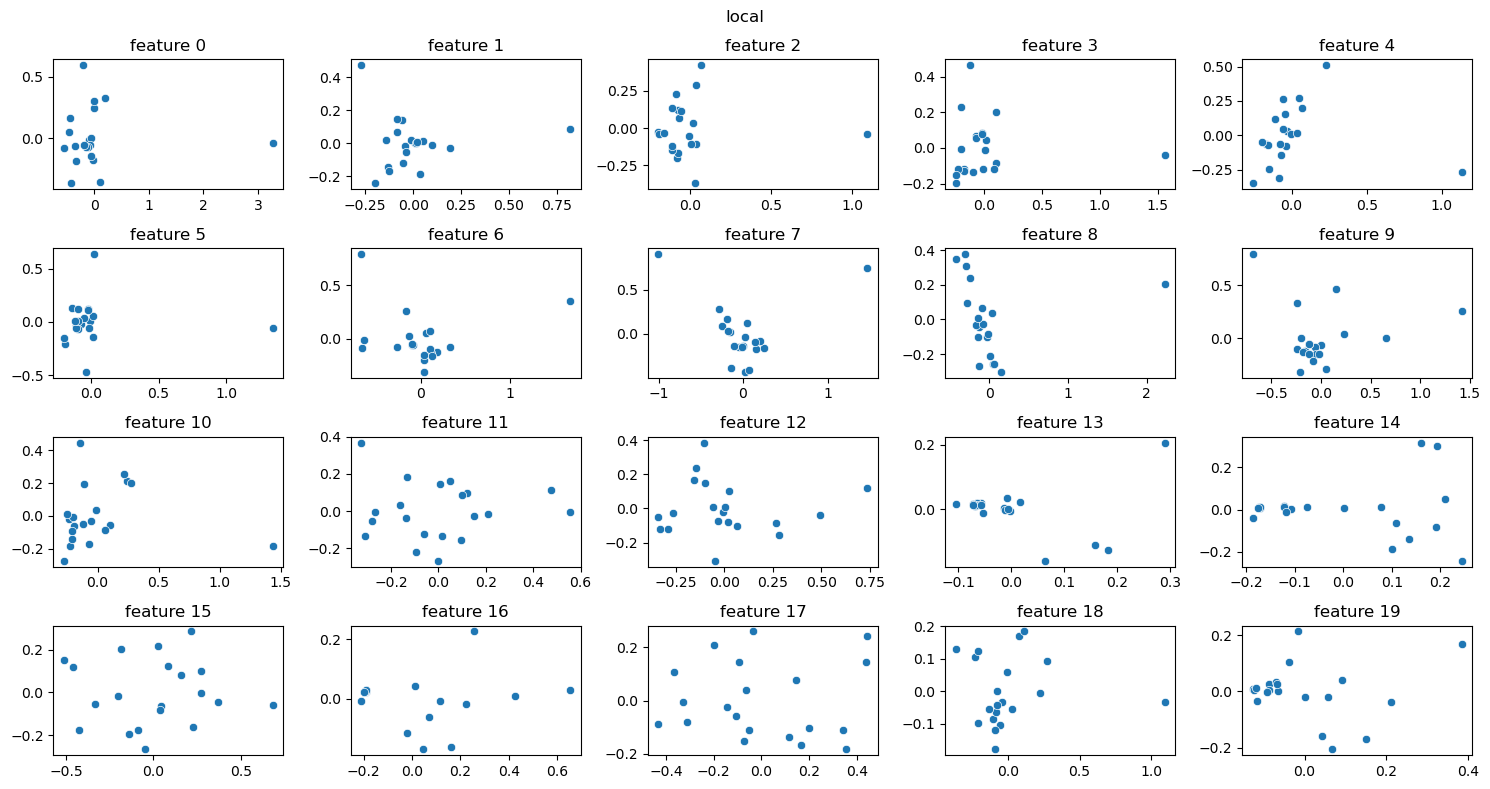

In [190]:
vis_local_model(tracker, iteration = 20, model = 'local', decomp = 'PCA')

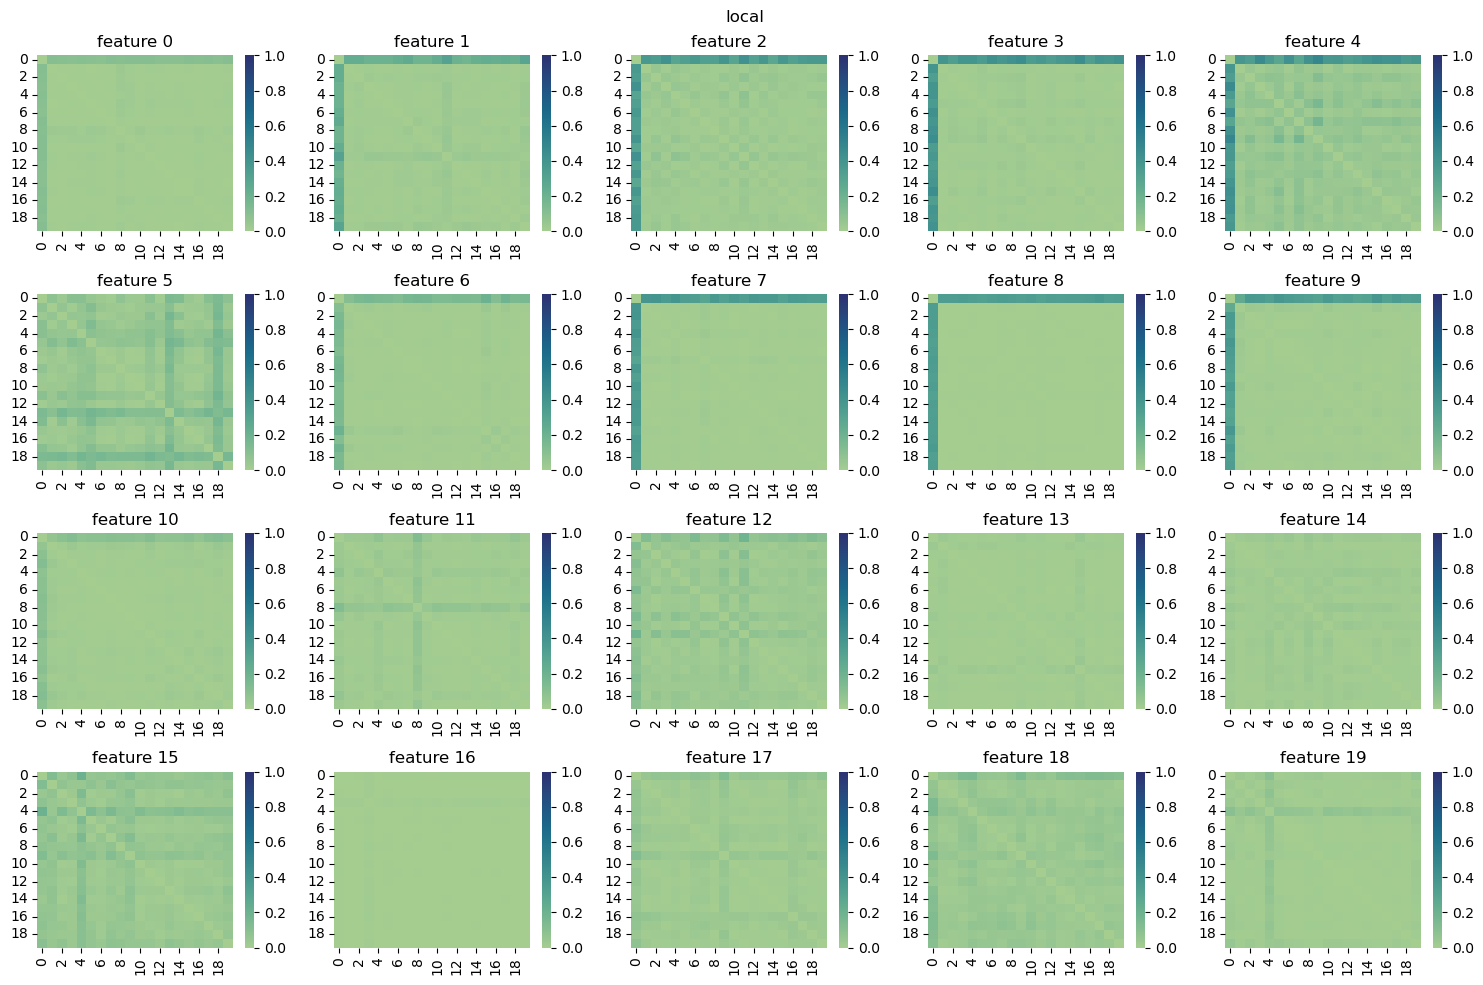

In [803]:
vis_local_model_sim(tracker, iteration = 20, model = 'local')

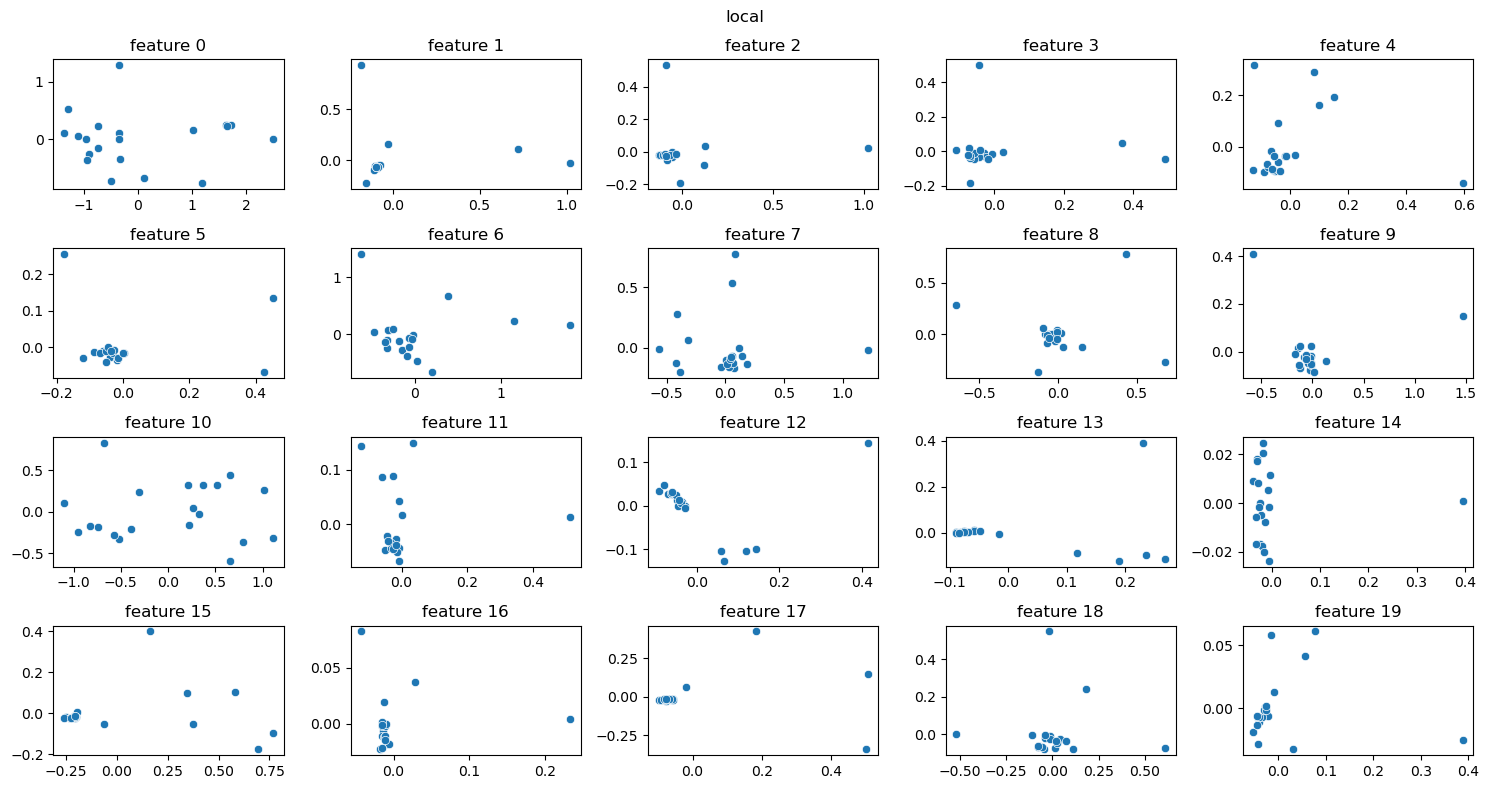

In [232]:
vis_local_model(tracker2, iteration = 1, model = 'local', decomp = 'PCA')

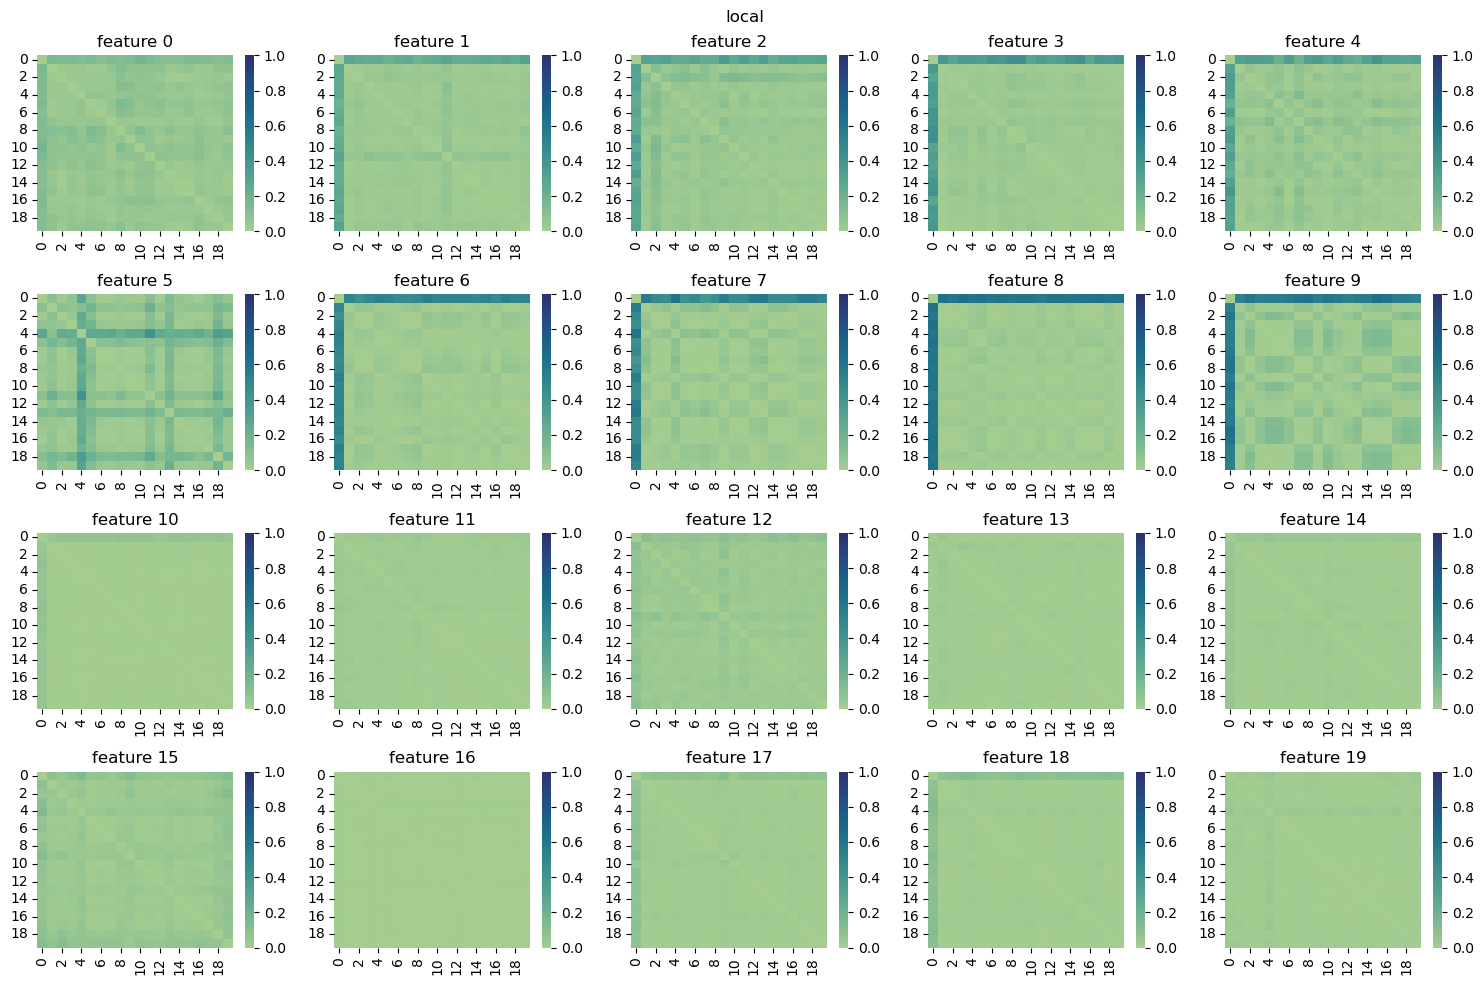

In [804]:
vis_local_model_sim(tracker2, iteration = 1, model = 'local')

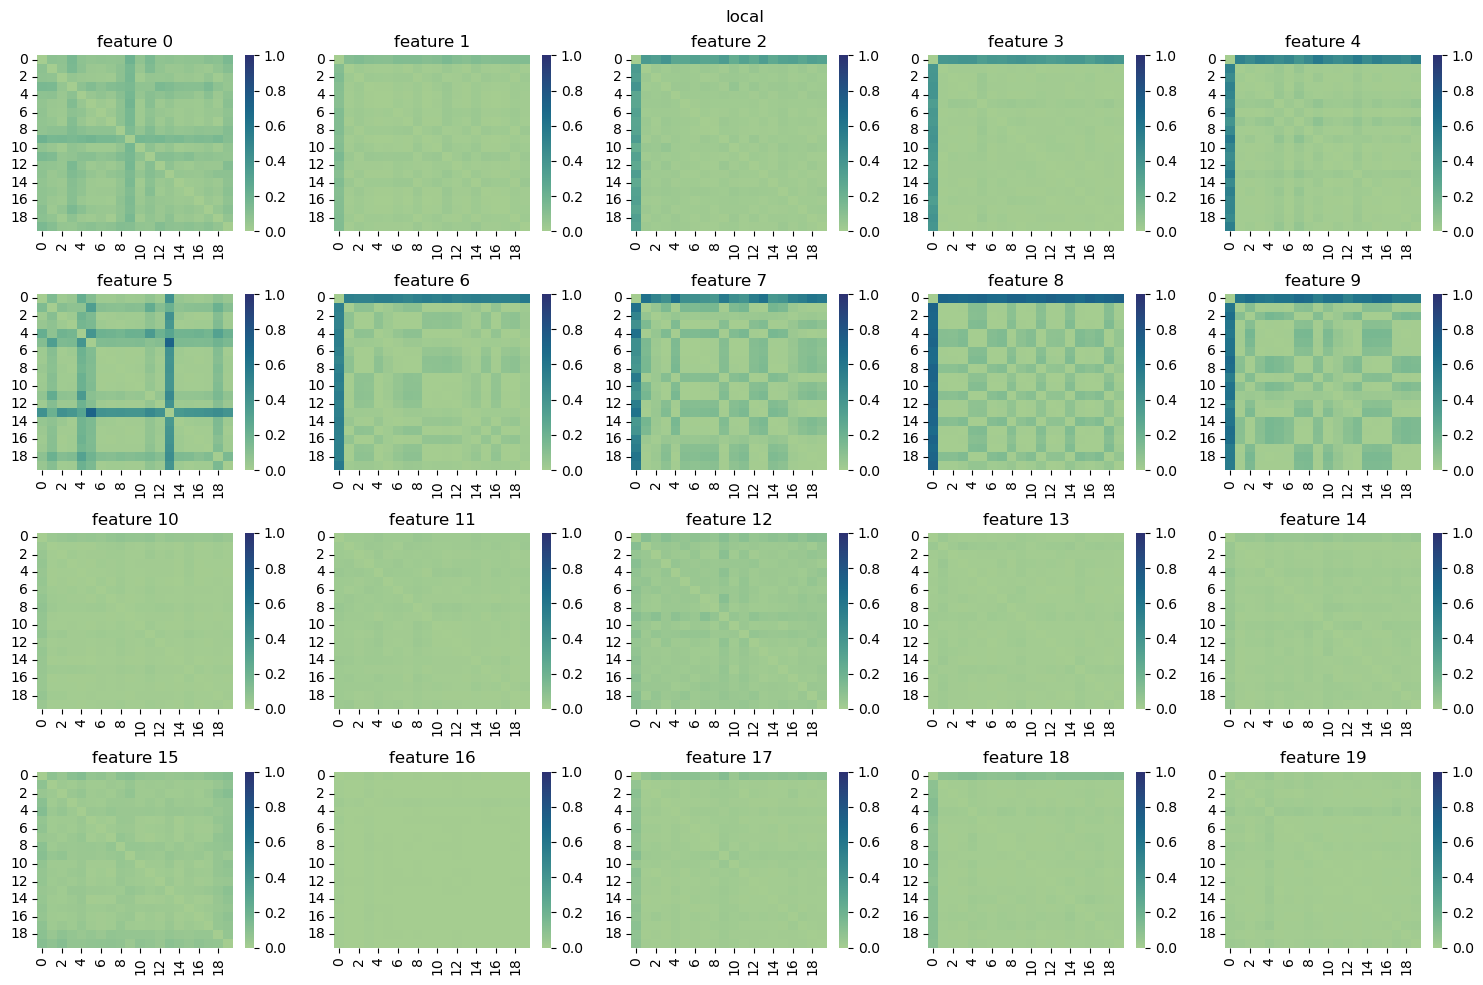

In [805]:
vis_local_model_sim(tracker2, iteration = 5, model = 'local')

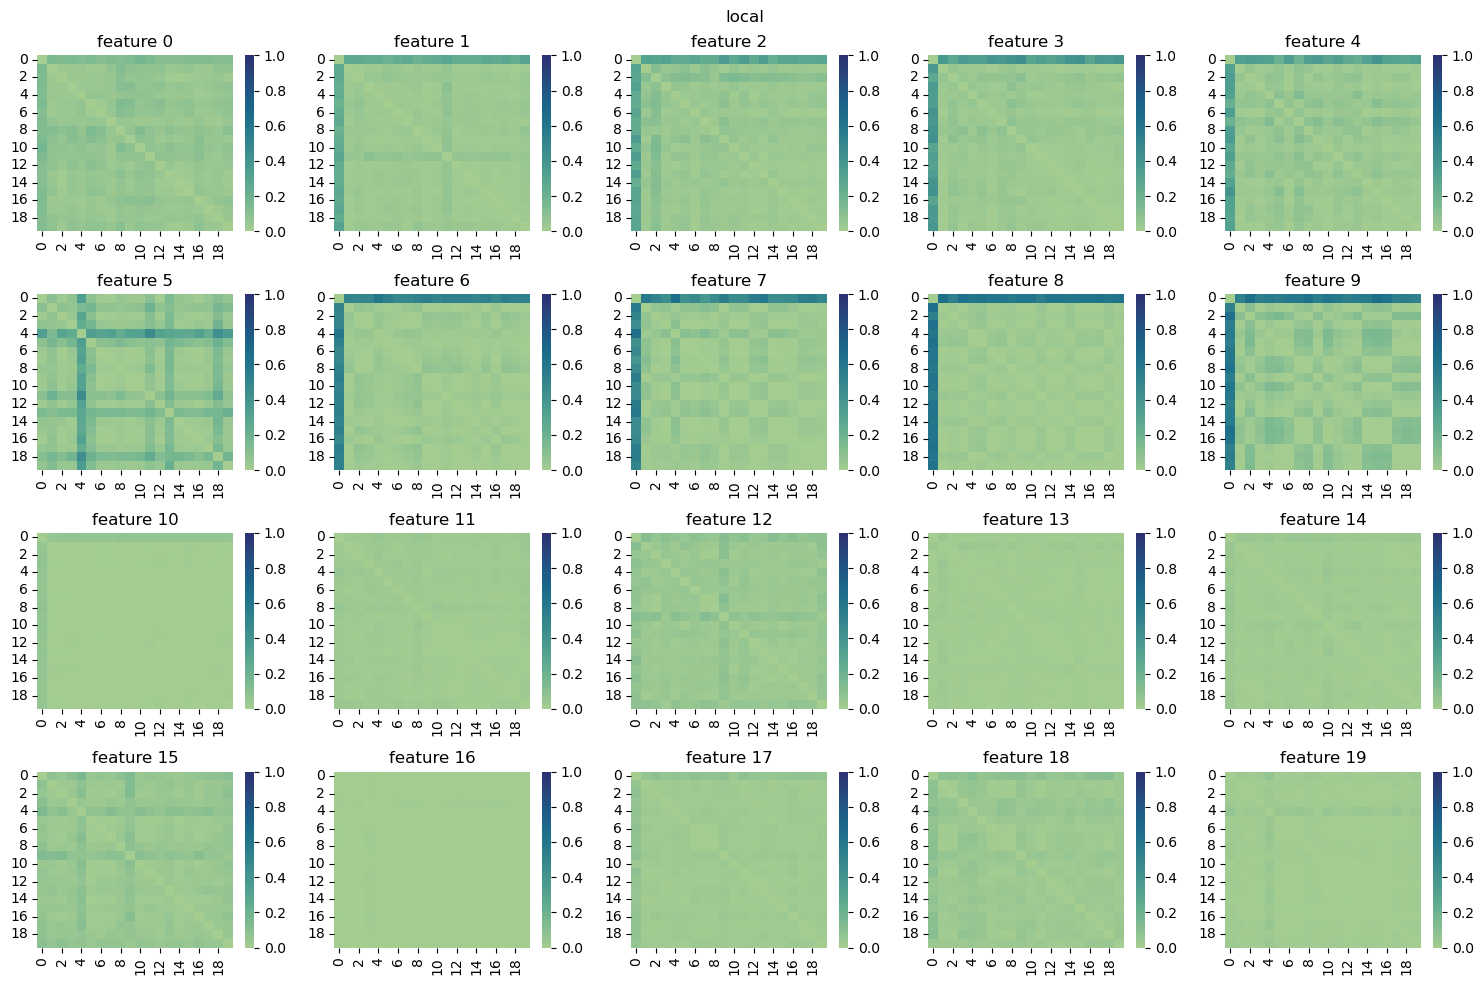

In [806]:
vis_local_model_sim(tracker3, iteration = 1, model='local')

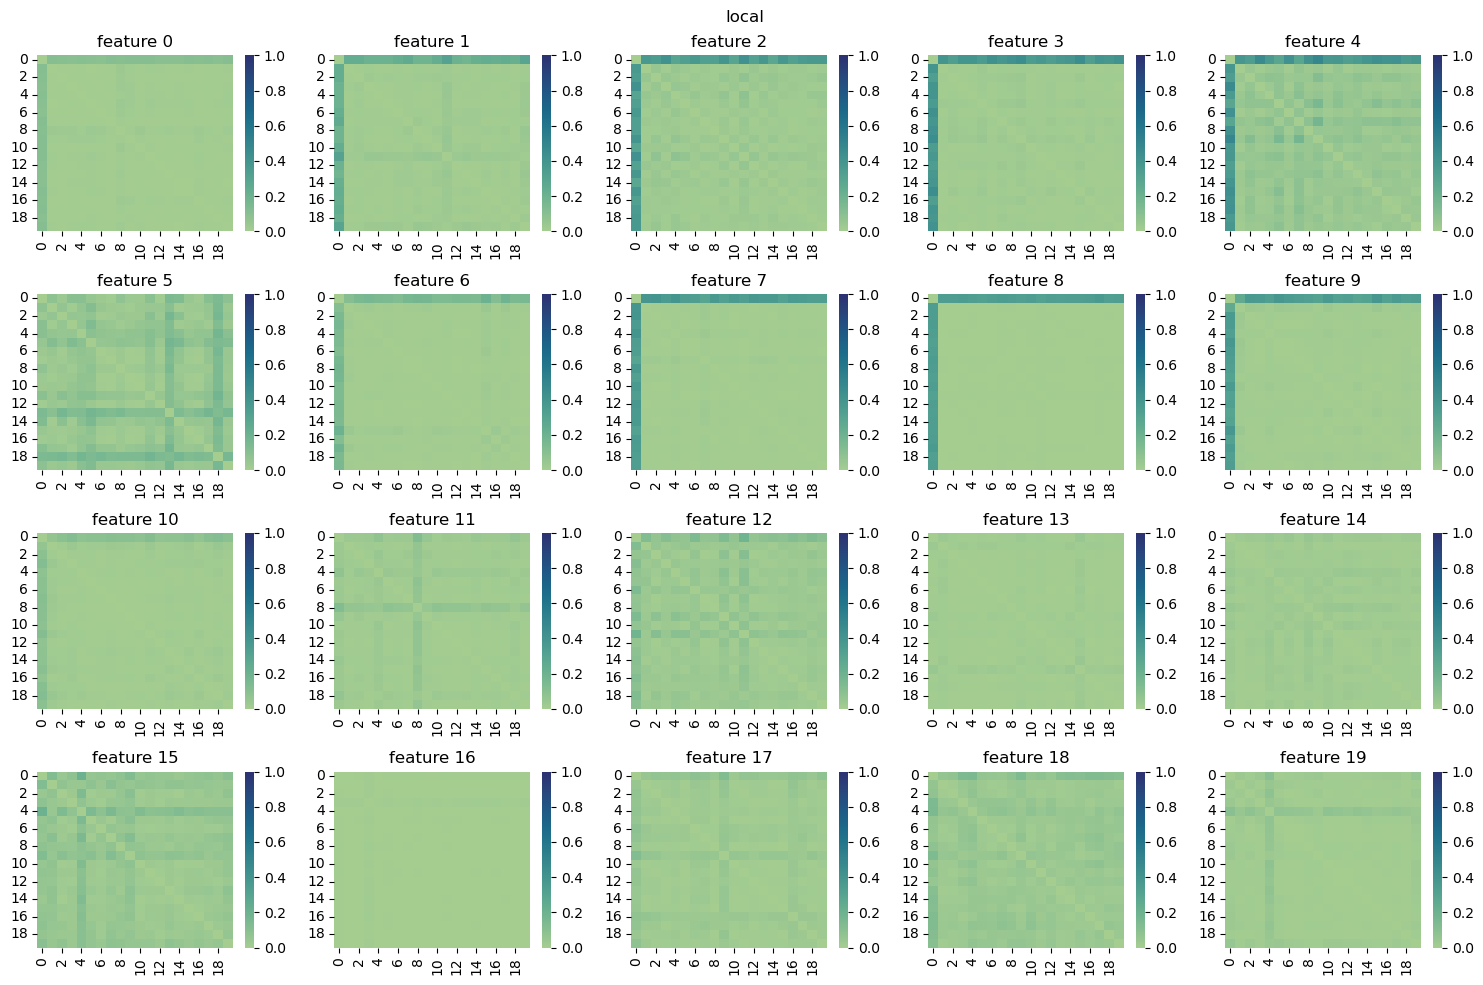

In [807]:
vis_local_model_sim(tracker, iteration = 20, model = 'local')

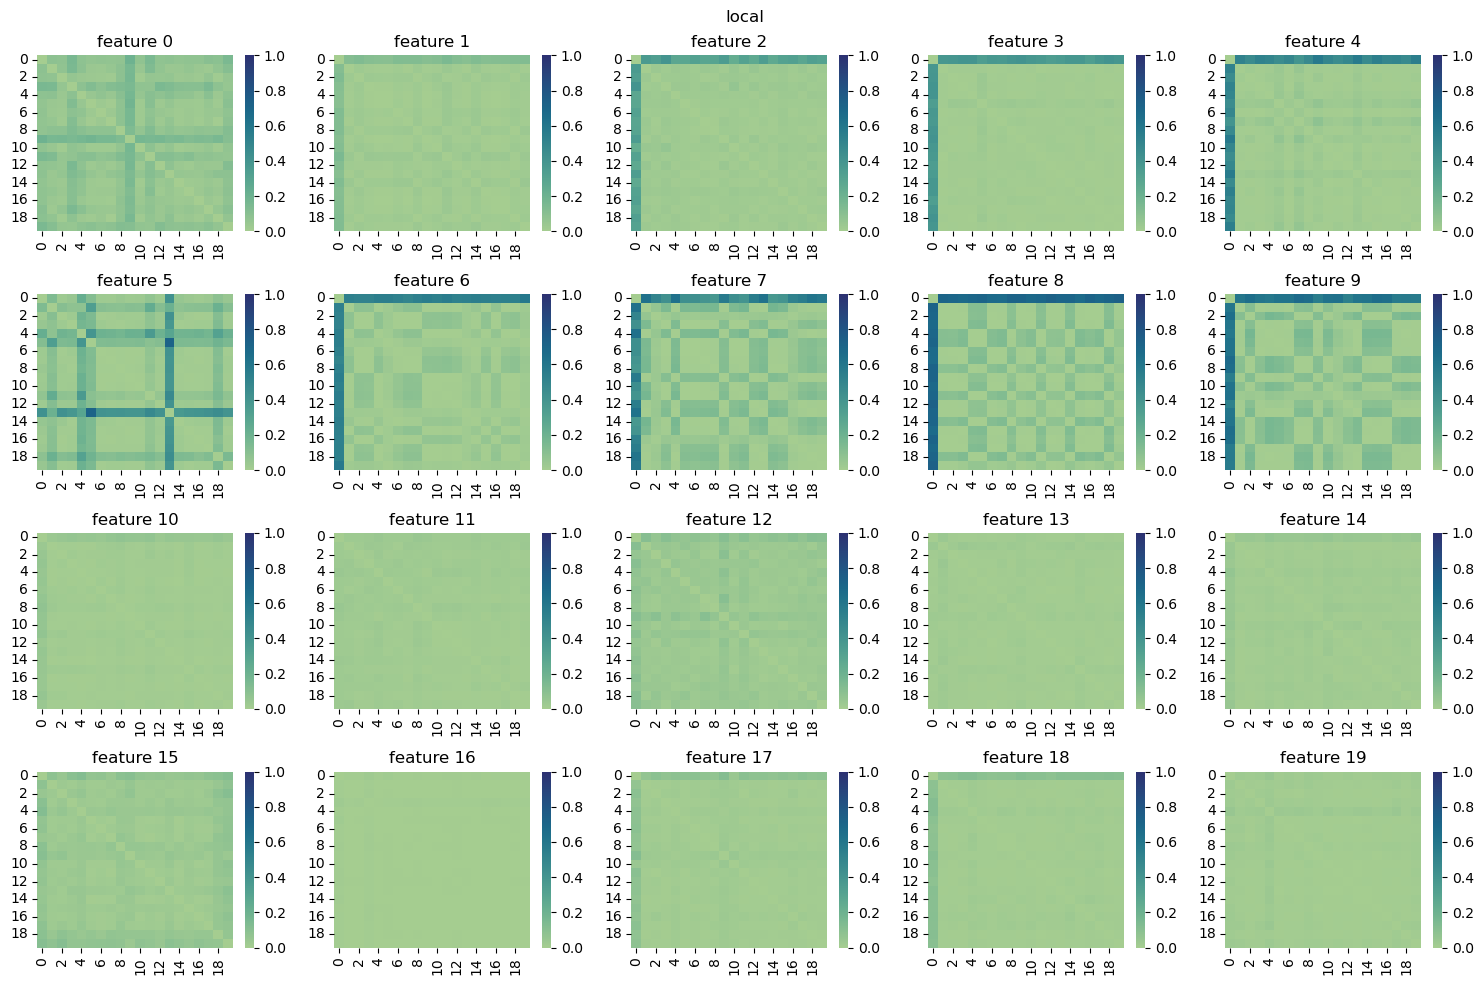

In [808]:
vis_local_model_sim(tracker2, iteration = 20, model = 'local')

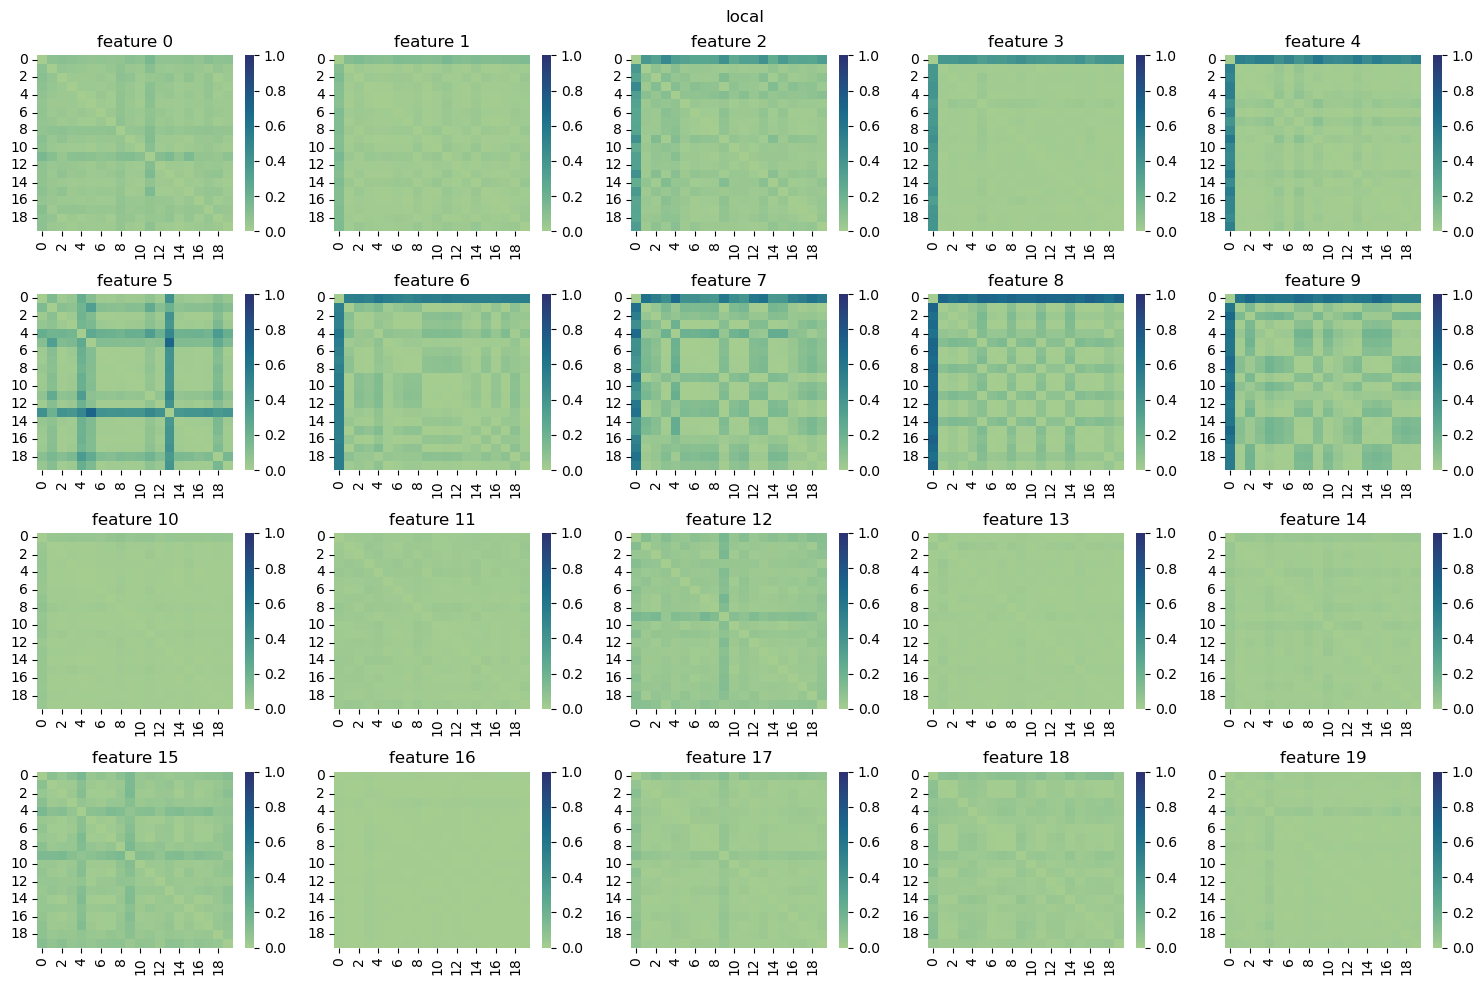

In [809]:
vis_local_model_sim(tracker3, iteration = 20, model = 'local')

#### Debug

In [221]:
def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

In [218]:
calculate_dis(0, tracker, tracker2)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [224]:
calculate_dis(1, tracker, tracker2, what = 'local_model')

0.0
1.6337764897152576
1.5702846497335994
0.5004458163916409
1.3448007010580283
1.9703069642747753
7.092822298471598
4.107754167615582
2.3113705599253667
2.6584593576326214
3.5720236606869196
0.6173539228937241
0.8044787428567401
0.5814388400454863
0.5877724712278766
1.1204952547227718
0.7345322421861542
1.1153722099686756
2.1486559810471793
0.793473354314416


#### Mechanism Model

##### Local

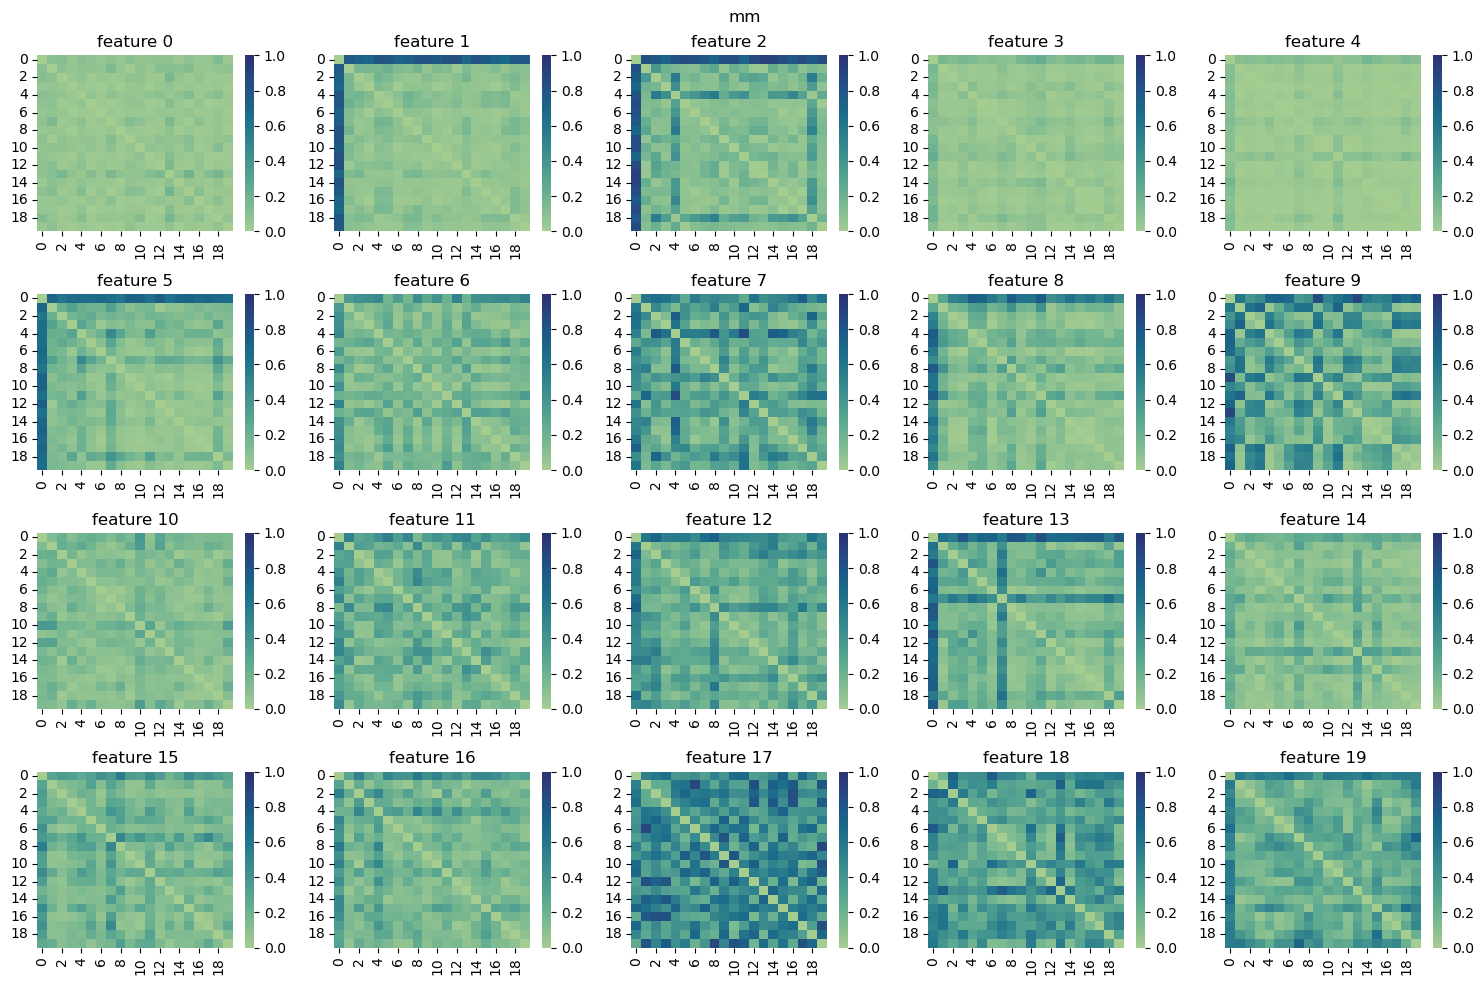

In [810]:
vis_local_model_sim(tracker0, iteration = 1, model = 'mm')

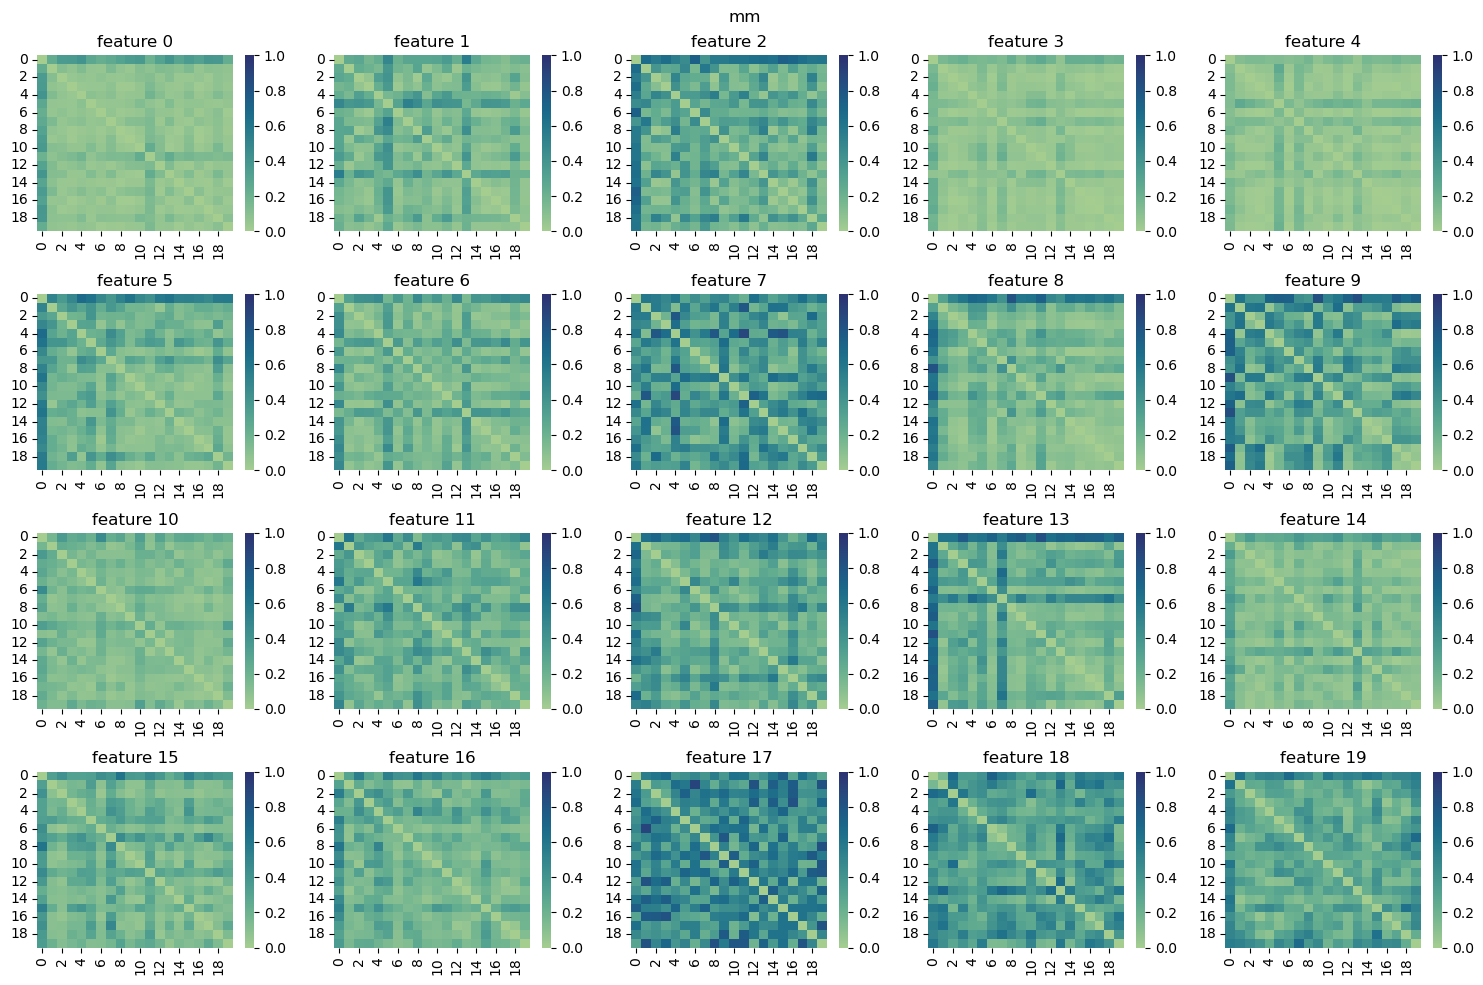

In [811]:
vis_local_model_sim(tracker0, iteration = 4, model = 'mm')

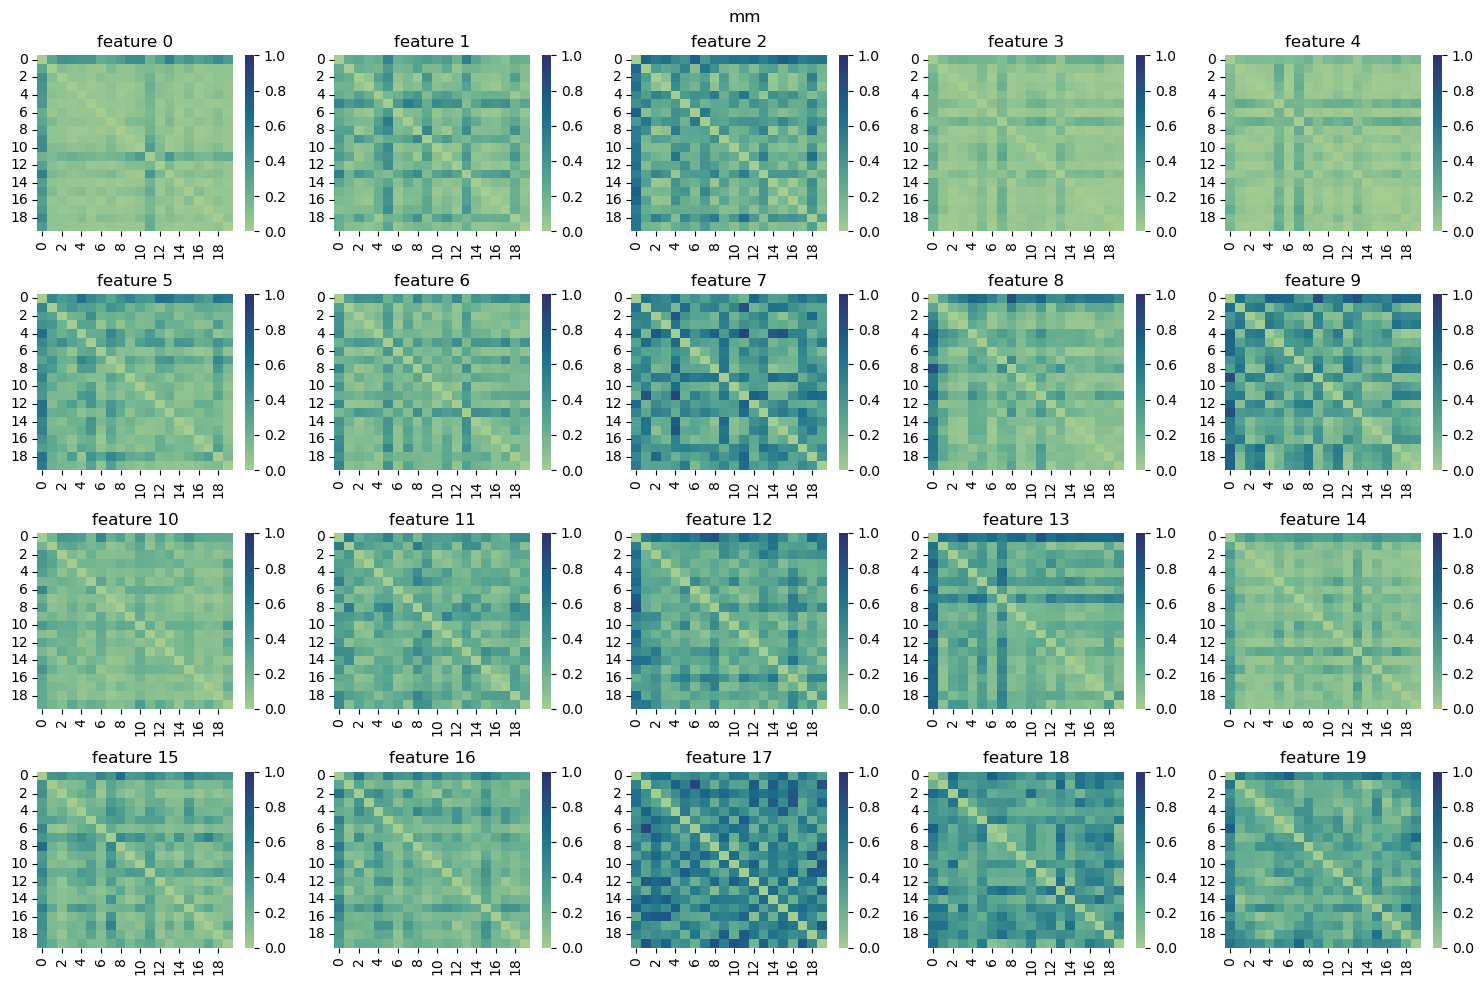

In [812]:
vis_local_model_sim(tracker0, iteration = 20, model='mm')

##### SimpleAVG

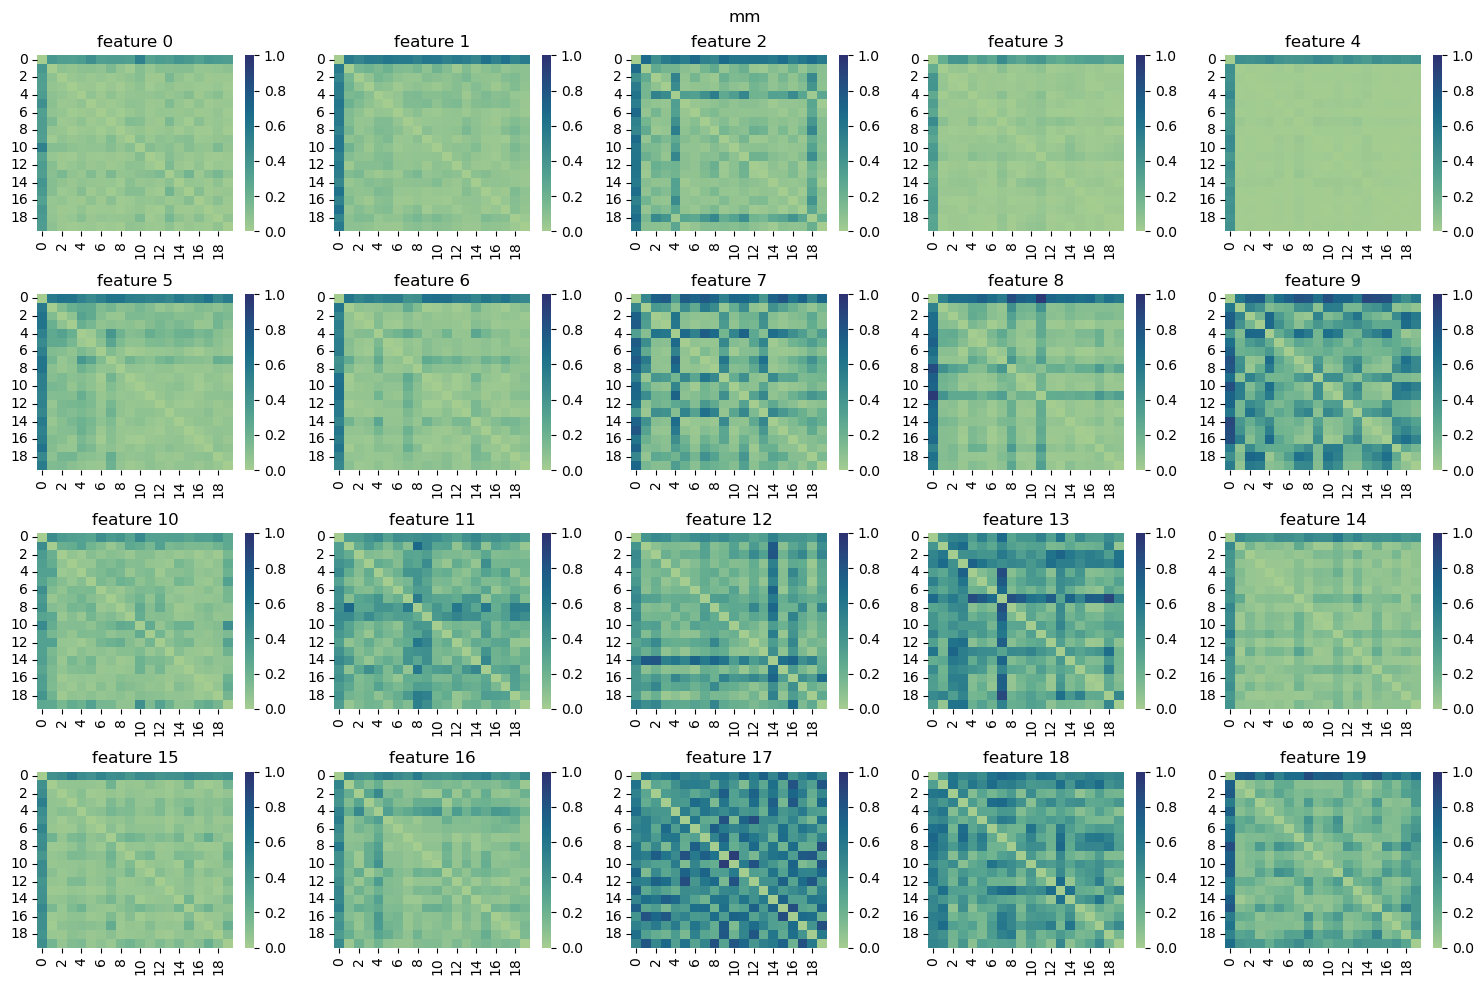

In [813]:
vis_local_model_sim(tracker, iteration = 1, model='mm')

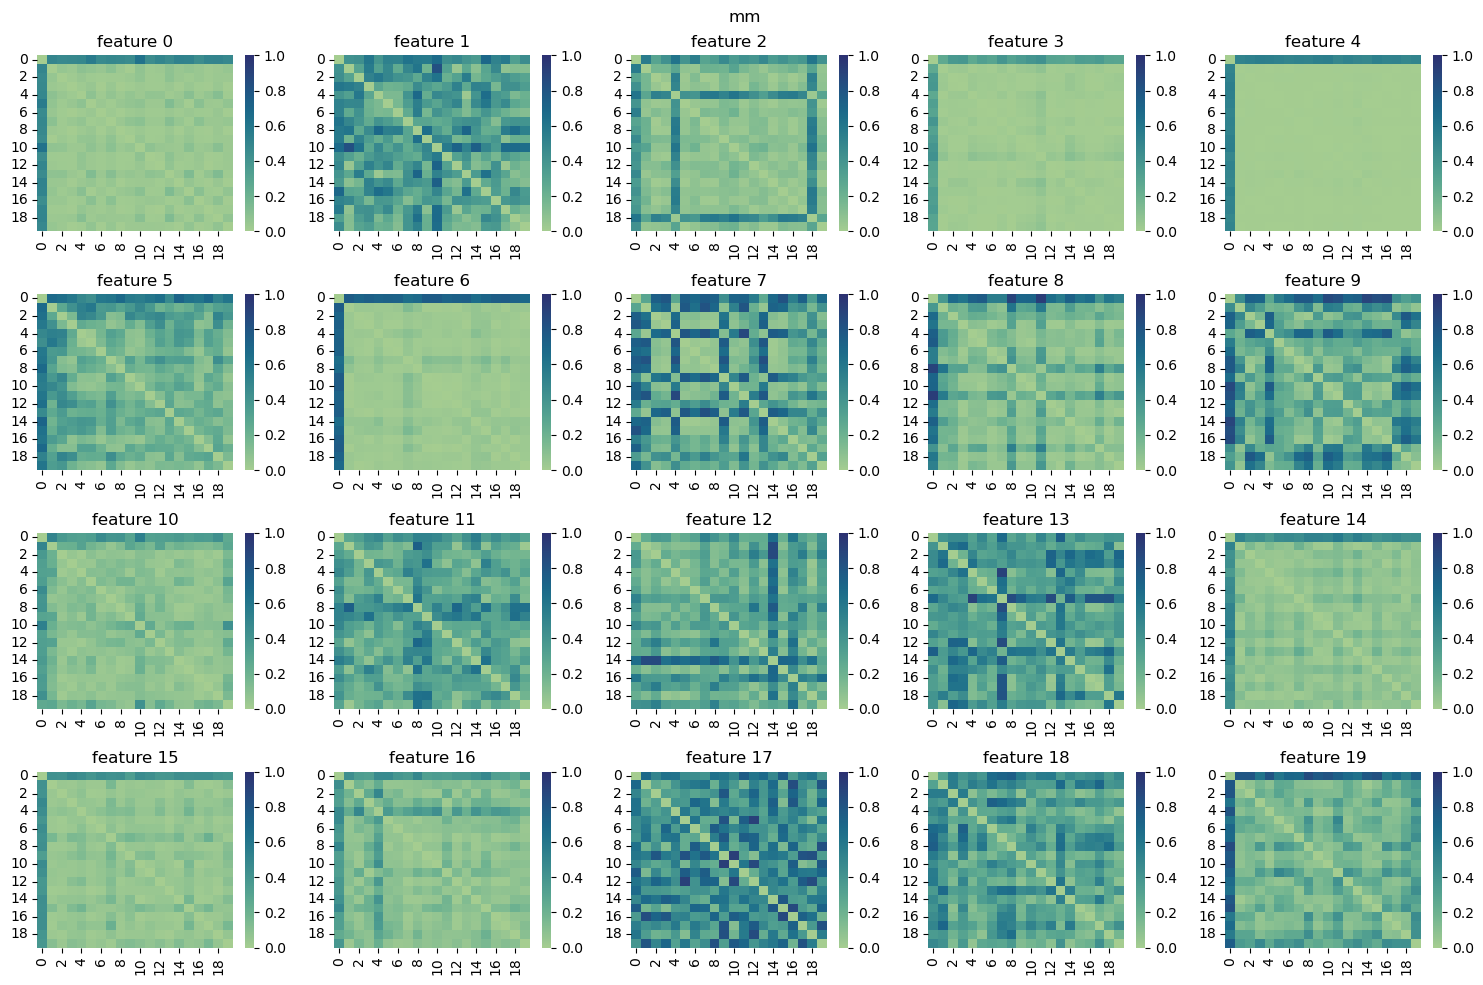

In [814]:
vis_local_model_sim(tracker, iteration = 3, model='mm')

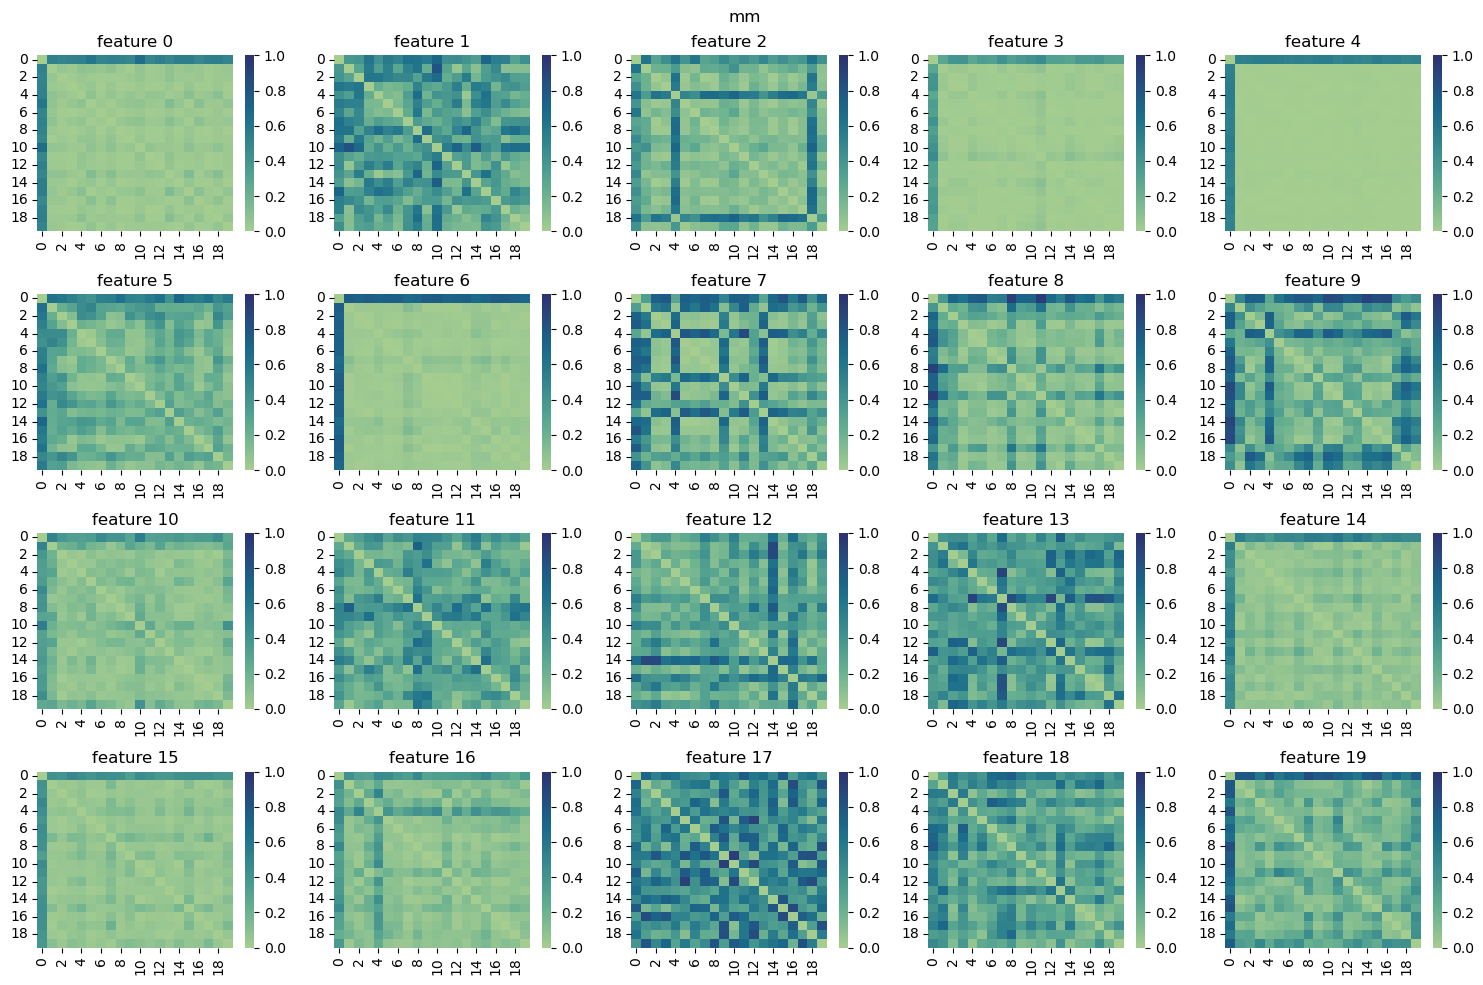

In [815]:
vis_local_model_sim(tracker, iteration = 5, model='mm')

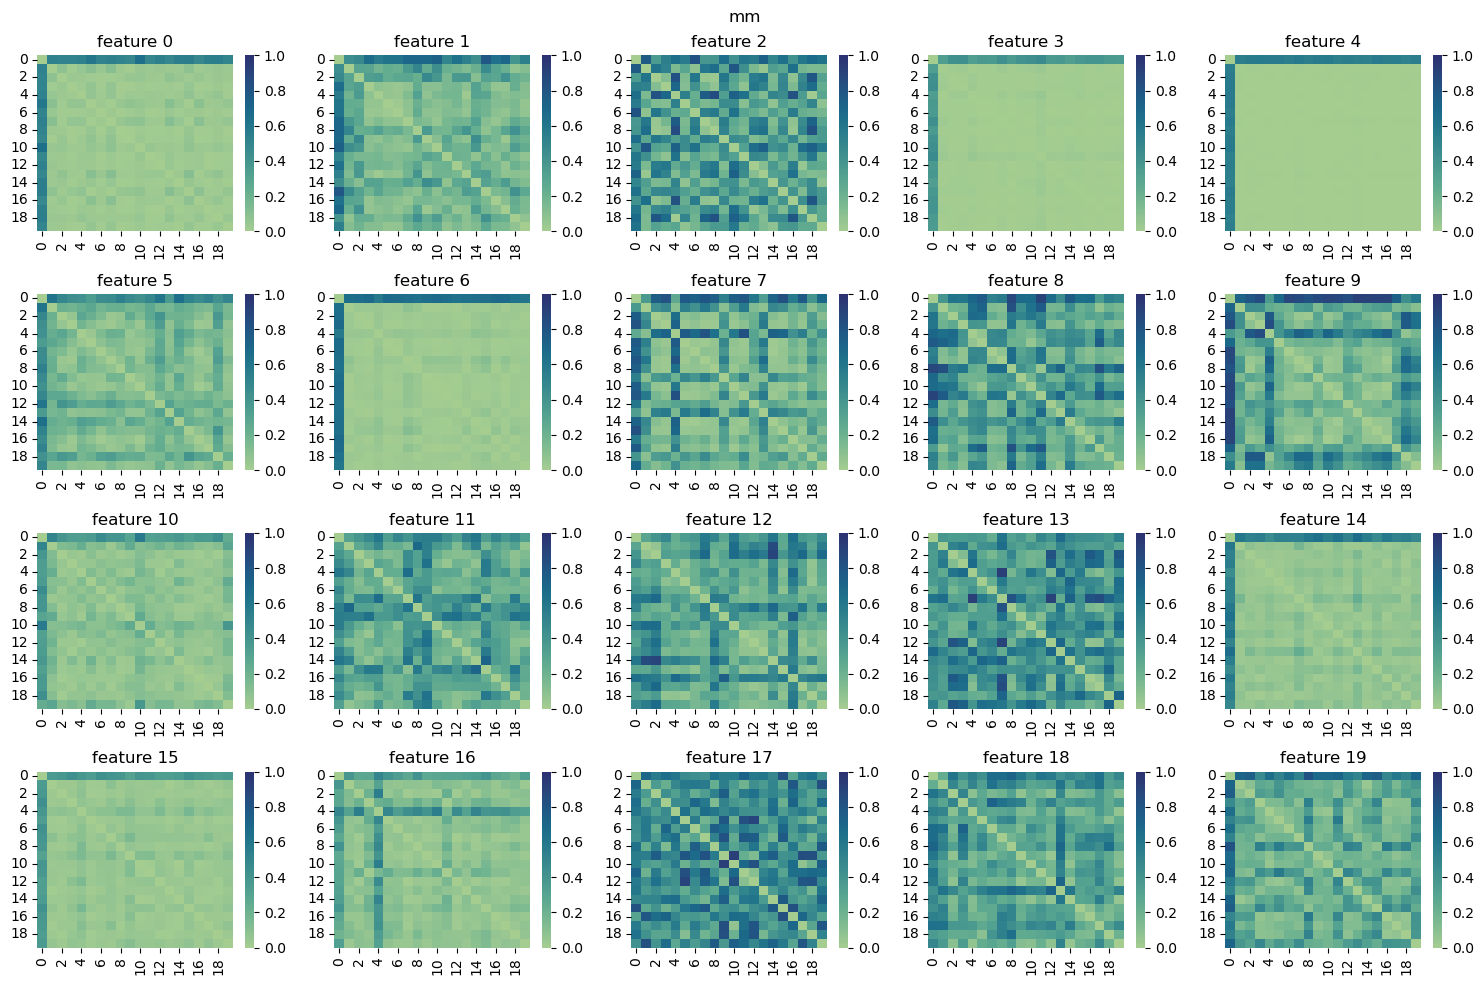

In [816]:
vis_local_model_sim(tracker, iteration = 20, model='mm')

##### Complementary

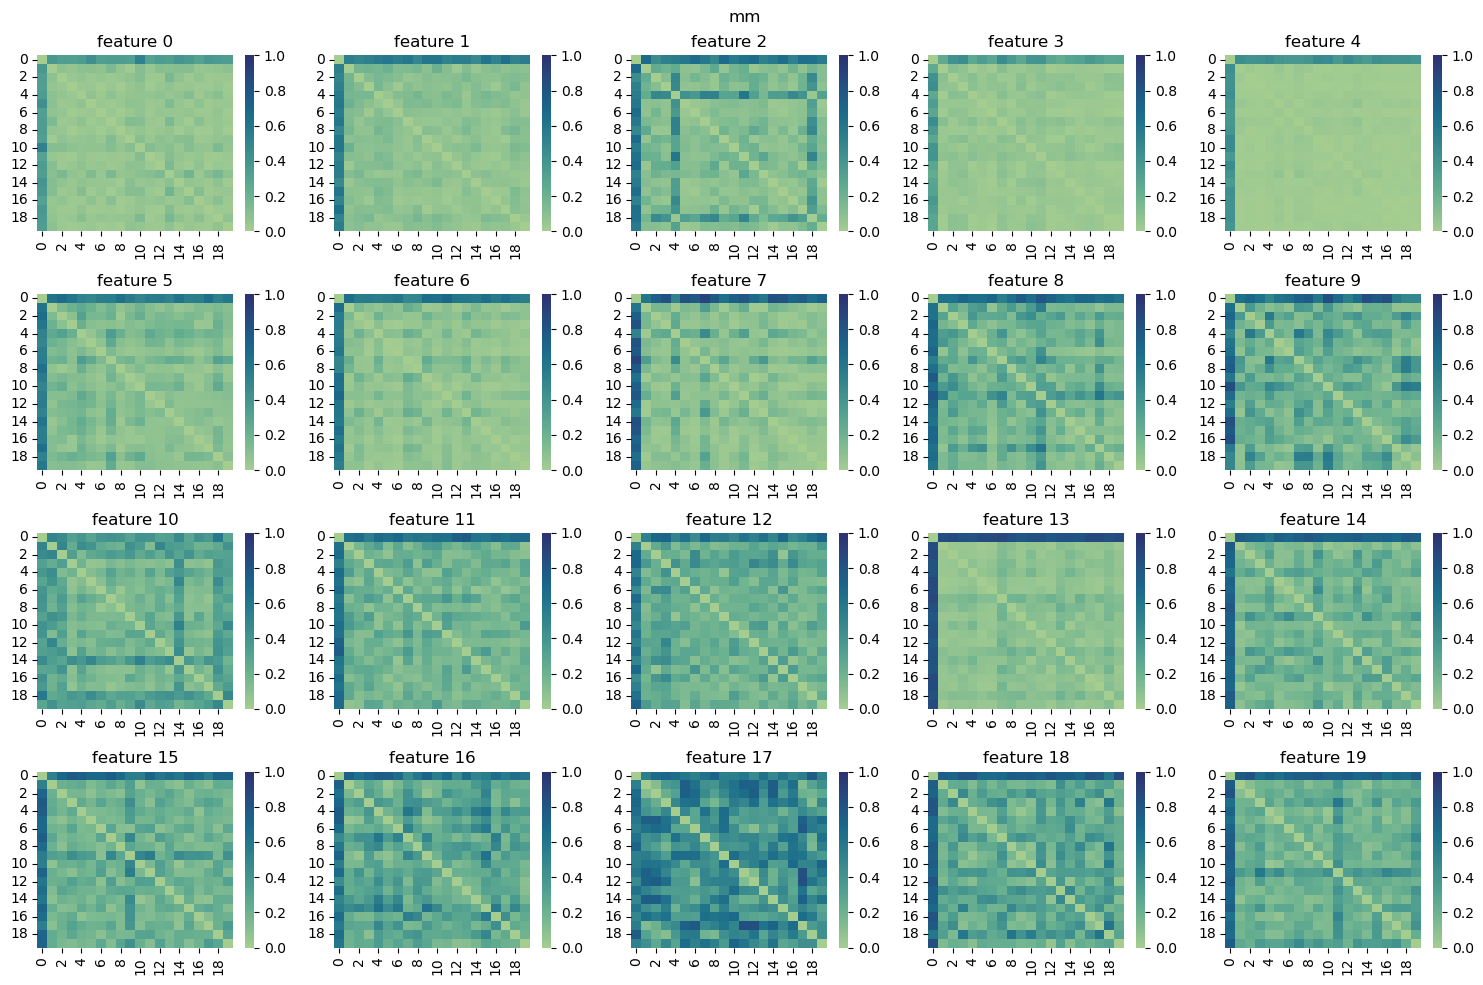

In [817]:
vis_local_model_sim(tracker2, iteration = 1, model='mm')

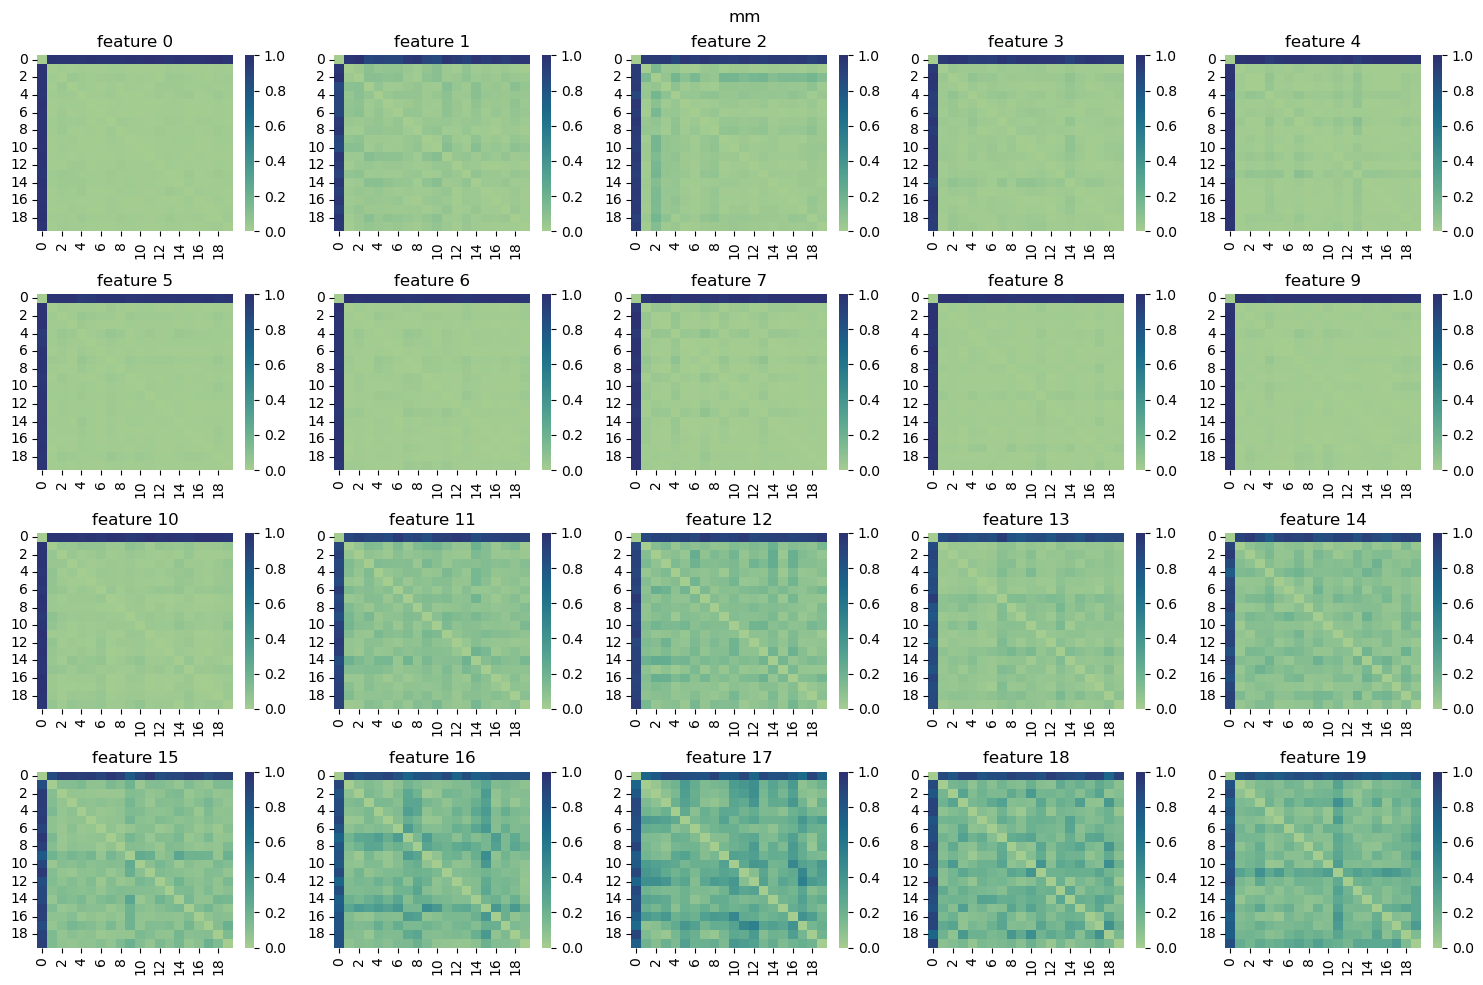

In [818]:
vis_local_model_sim(tracker2, iteration = 5, model='mm')

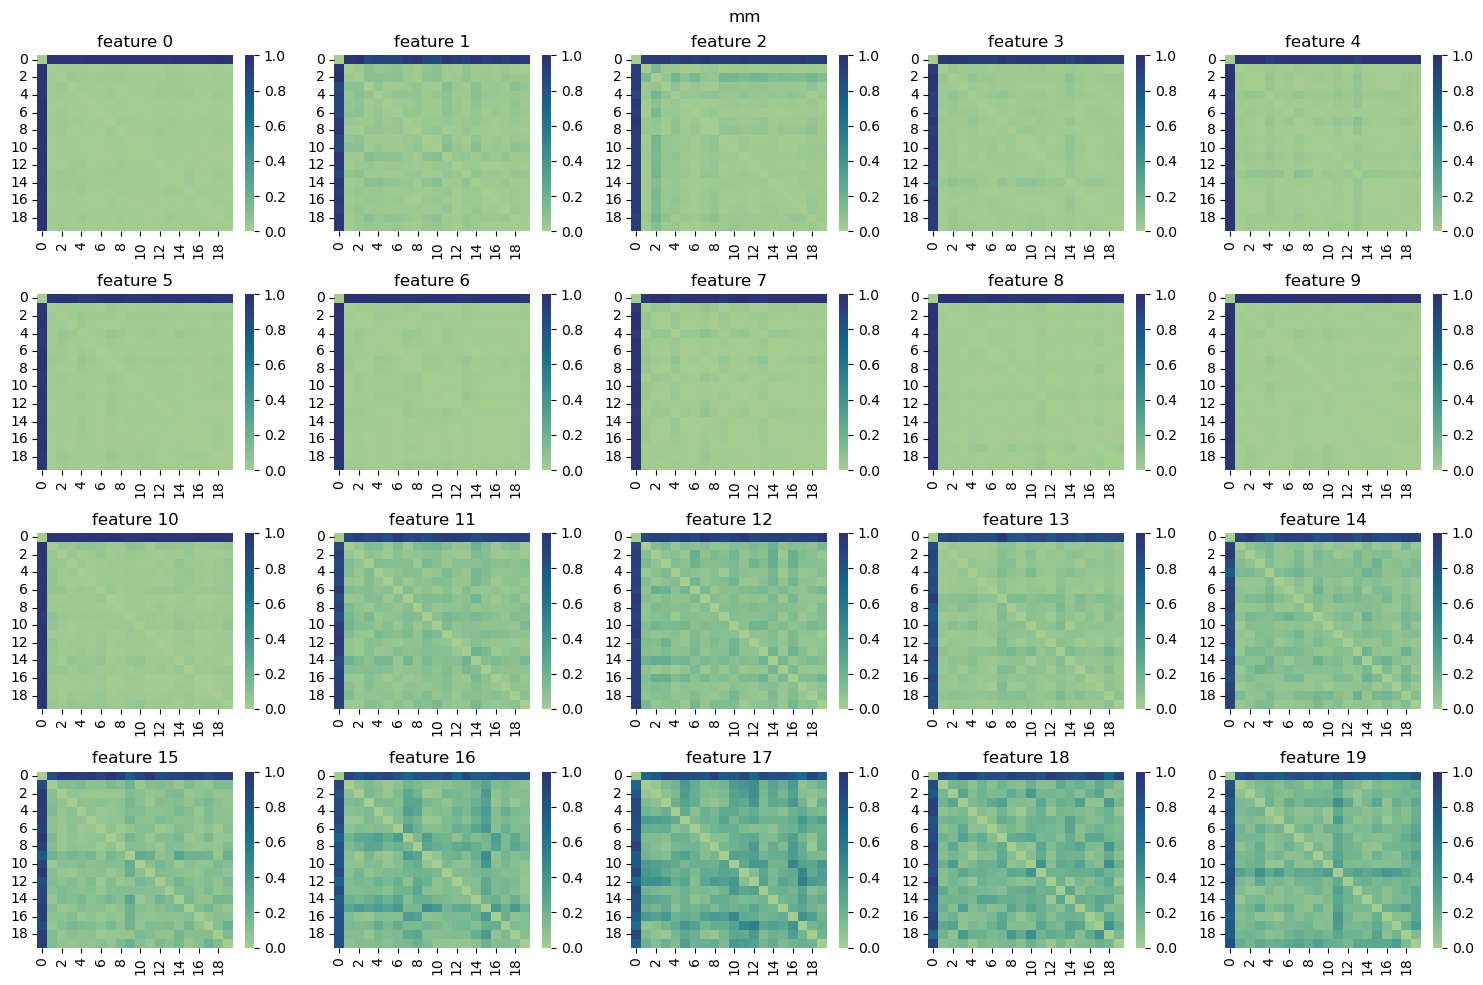

In [819]:
vis_local_model_sim(tracker2, iteration = 20, model='mm')

##### Ours

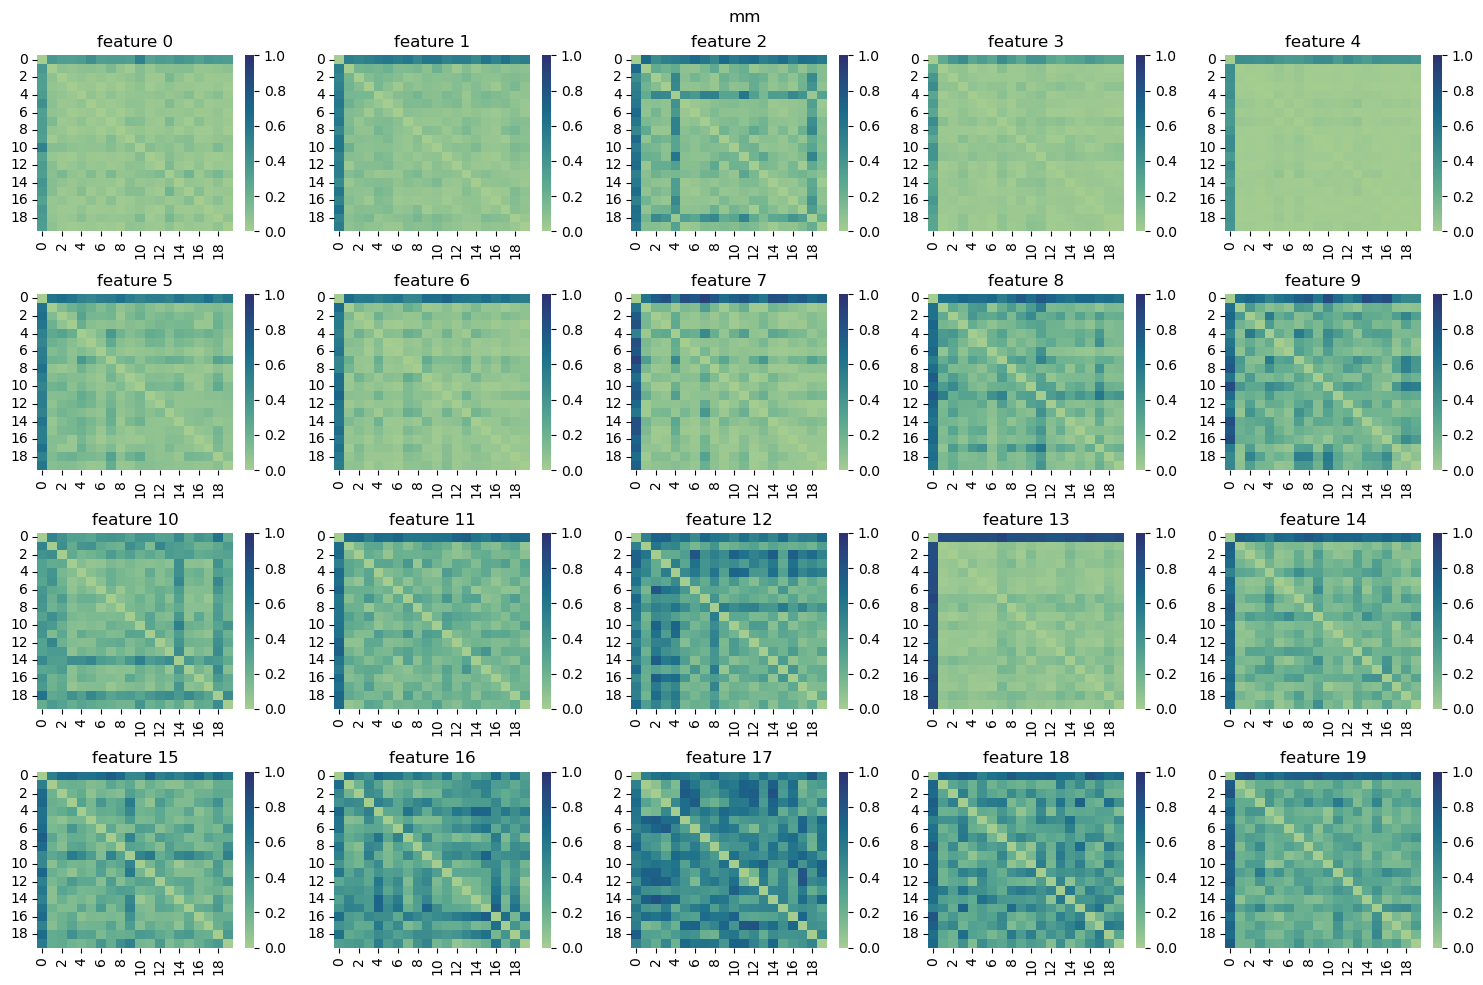

In [820]:
vis_local_model_sim(tracker3, iteration = 1, model='mm')

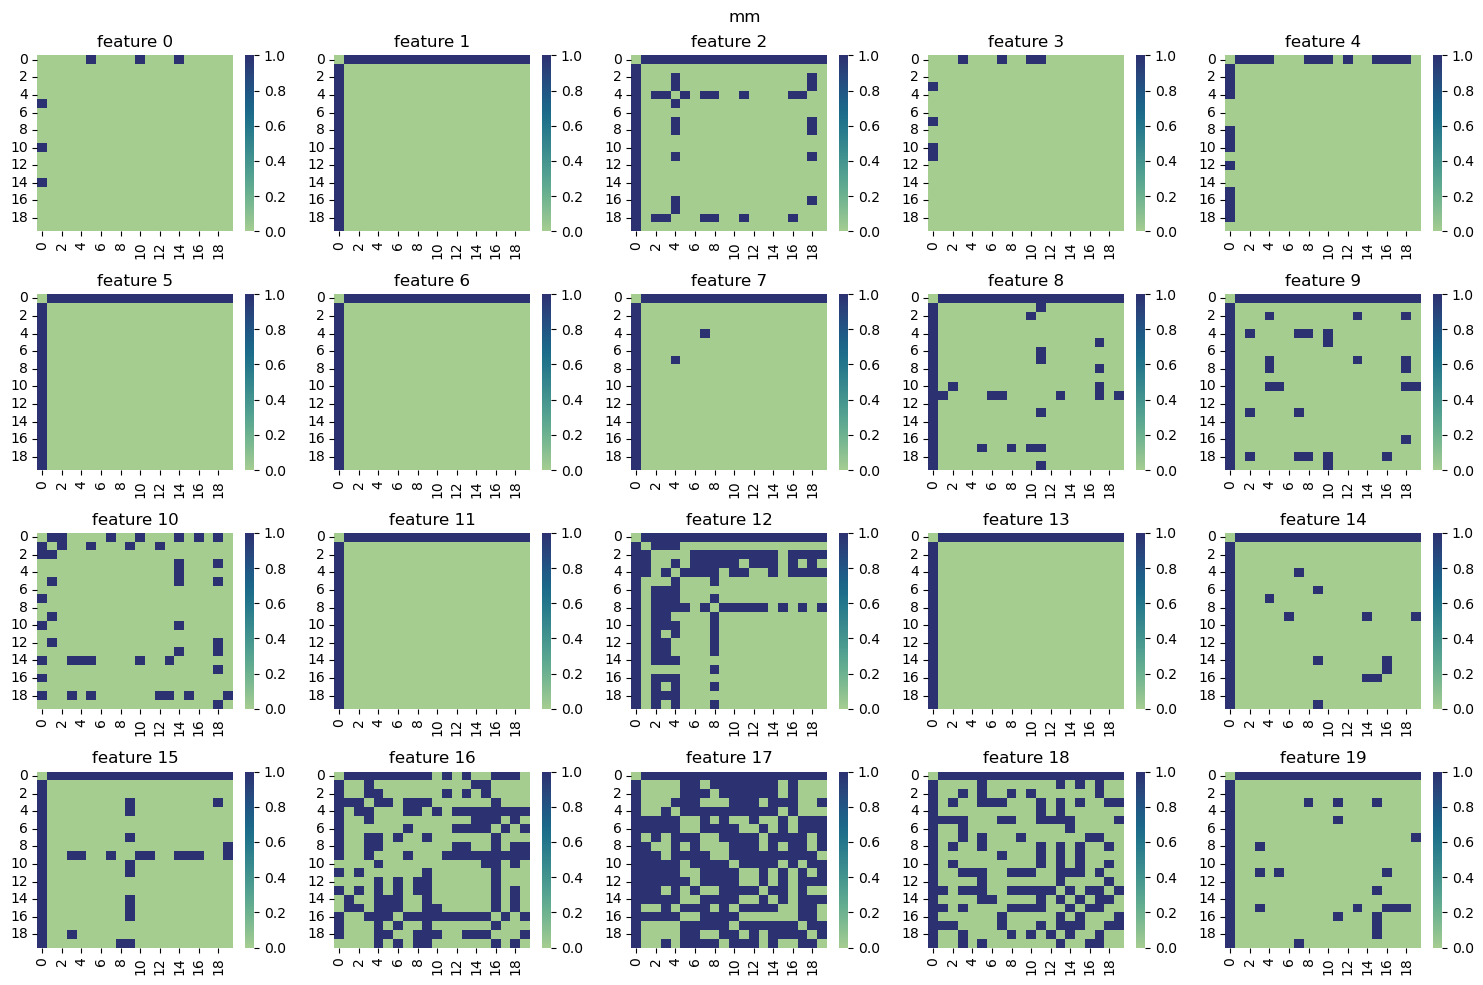

In [821]:
vis_local_model_sim_t(tracker3, iteration = 1, model='mm')

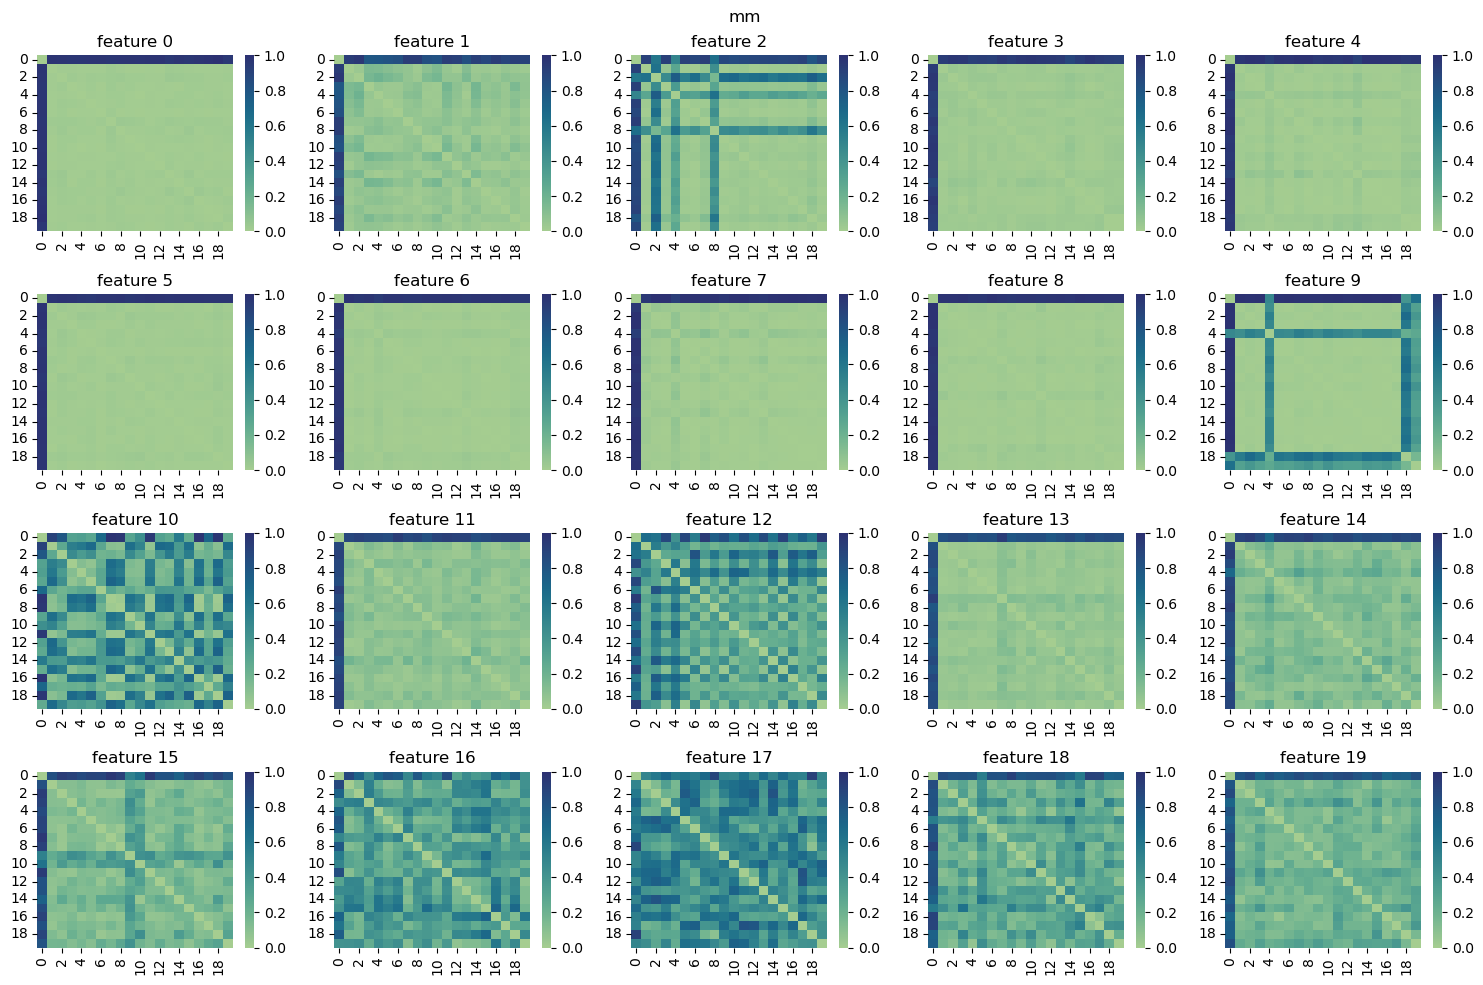

In [822]:
vis_local_model_sim(tracker3, iteration = 2, model='mm')

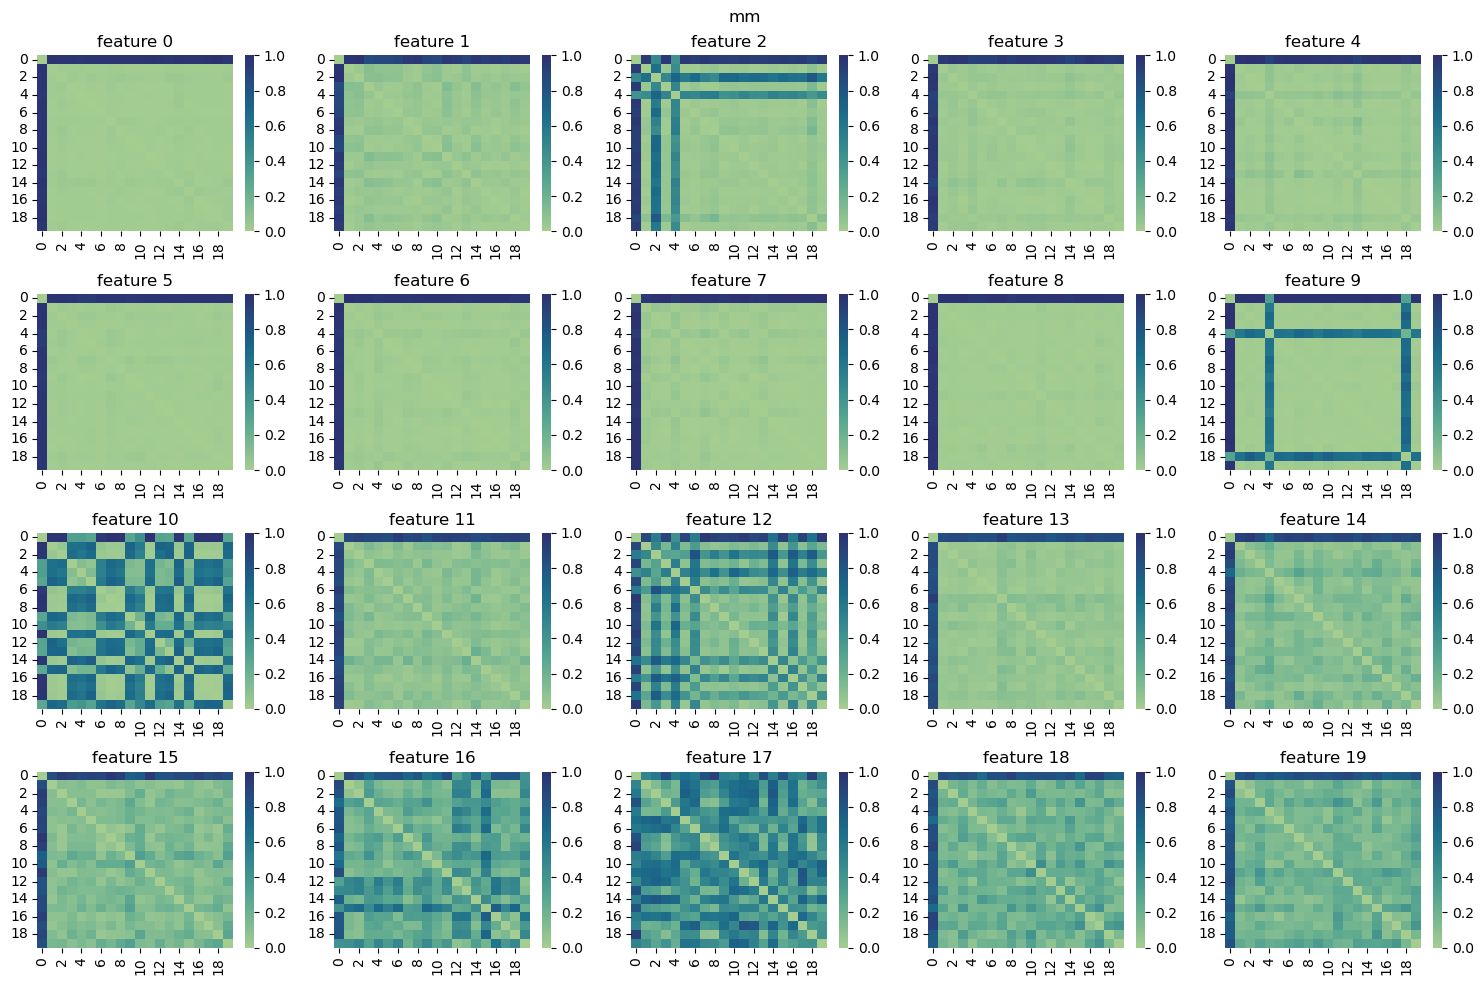

In [823]:
vis_local_model_sim(tracker3, iteration = 20, model='mm')

### MARY

In [824]:
trackery0 = trackers['mary_sigmoid_lr_local']
trackery1 = trackers['mary_sigmoid_lr_simpleavg']
trackery2 = trackers['mary_sigmoid_lr_complementary']
trackery3 = trackers['mary_sigmoid_lr_fedmechw']

#### Local

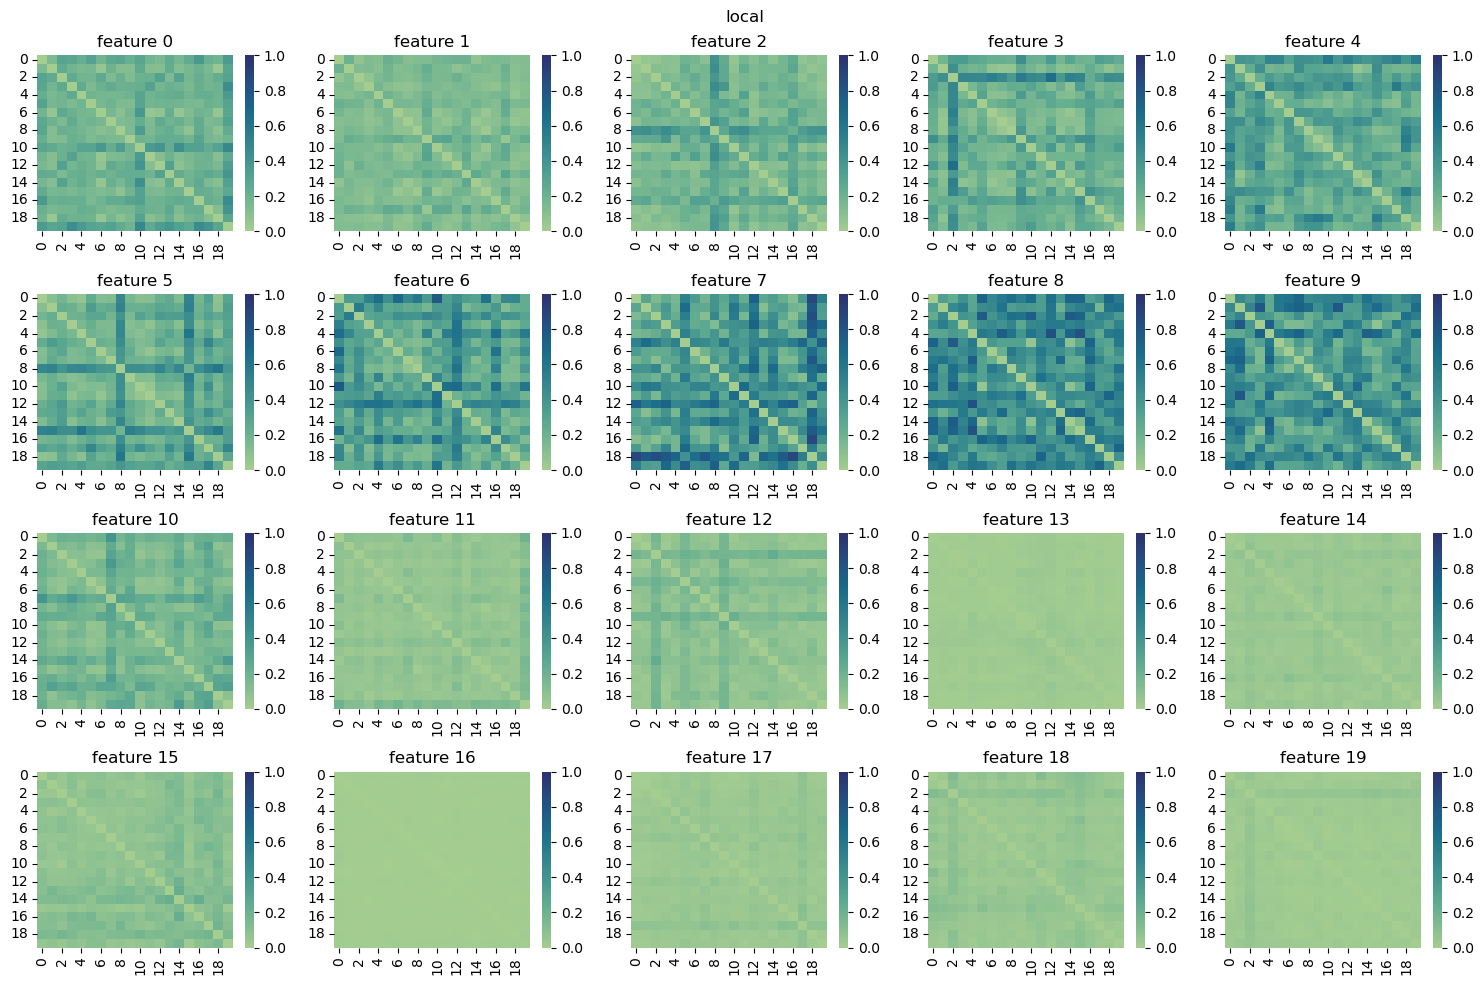

In [825]:
vis_local_model_sim(trackery0, iteration = 1, model='local')

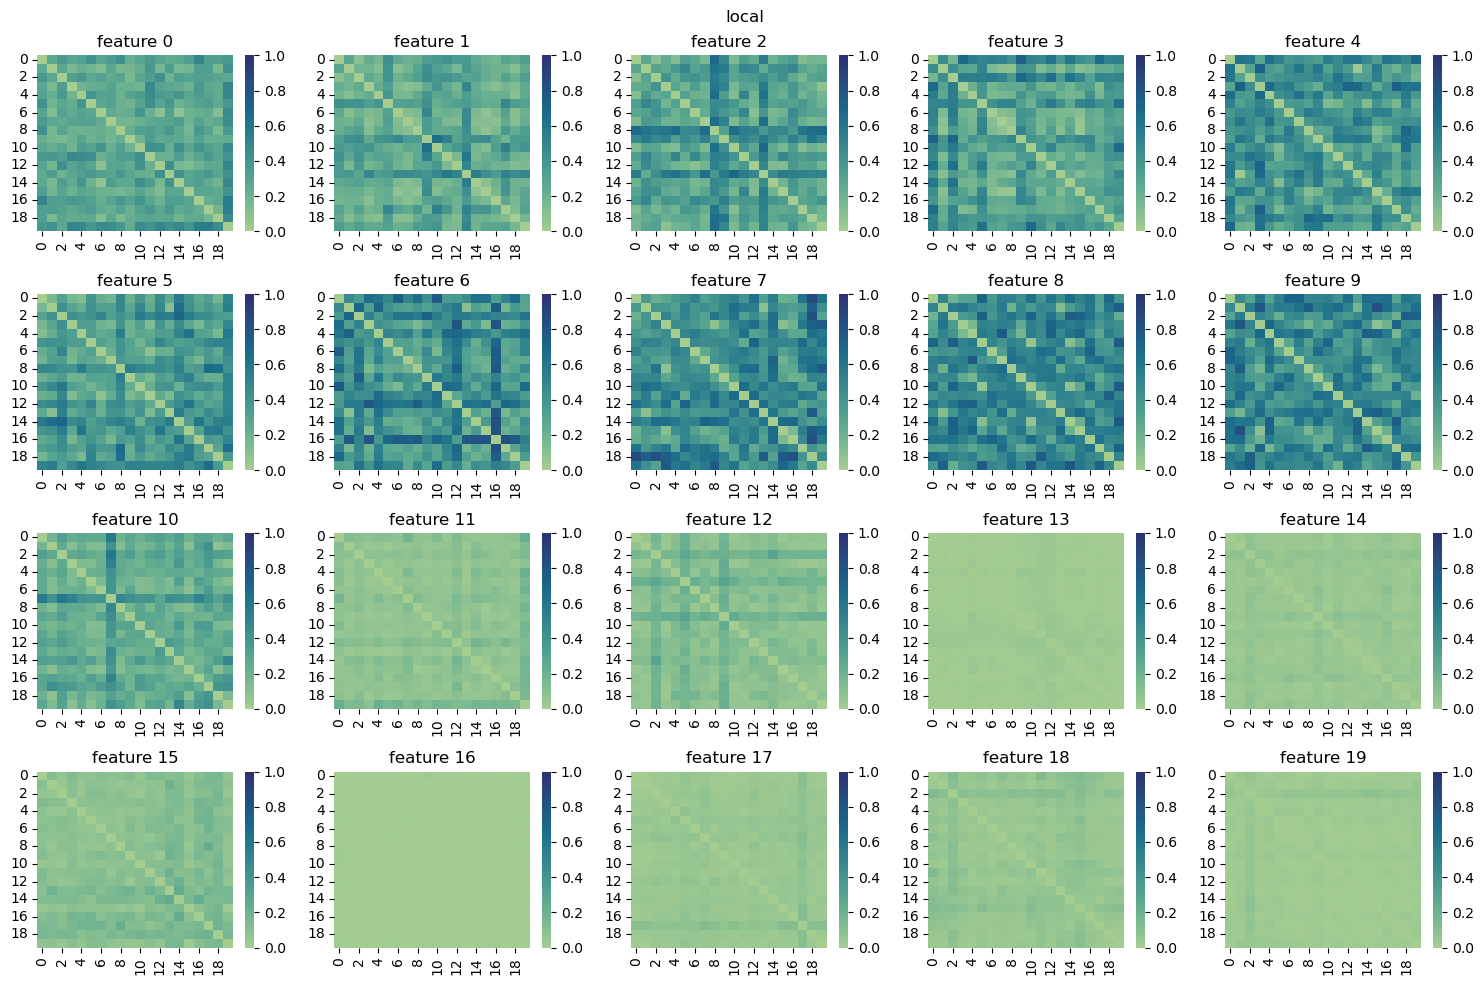

In [826]:
vis_local_model_sim(trackery0, iteration = 20, model='local')

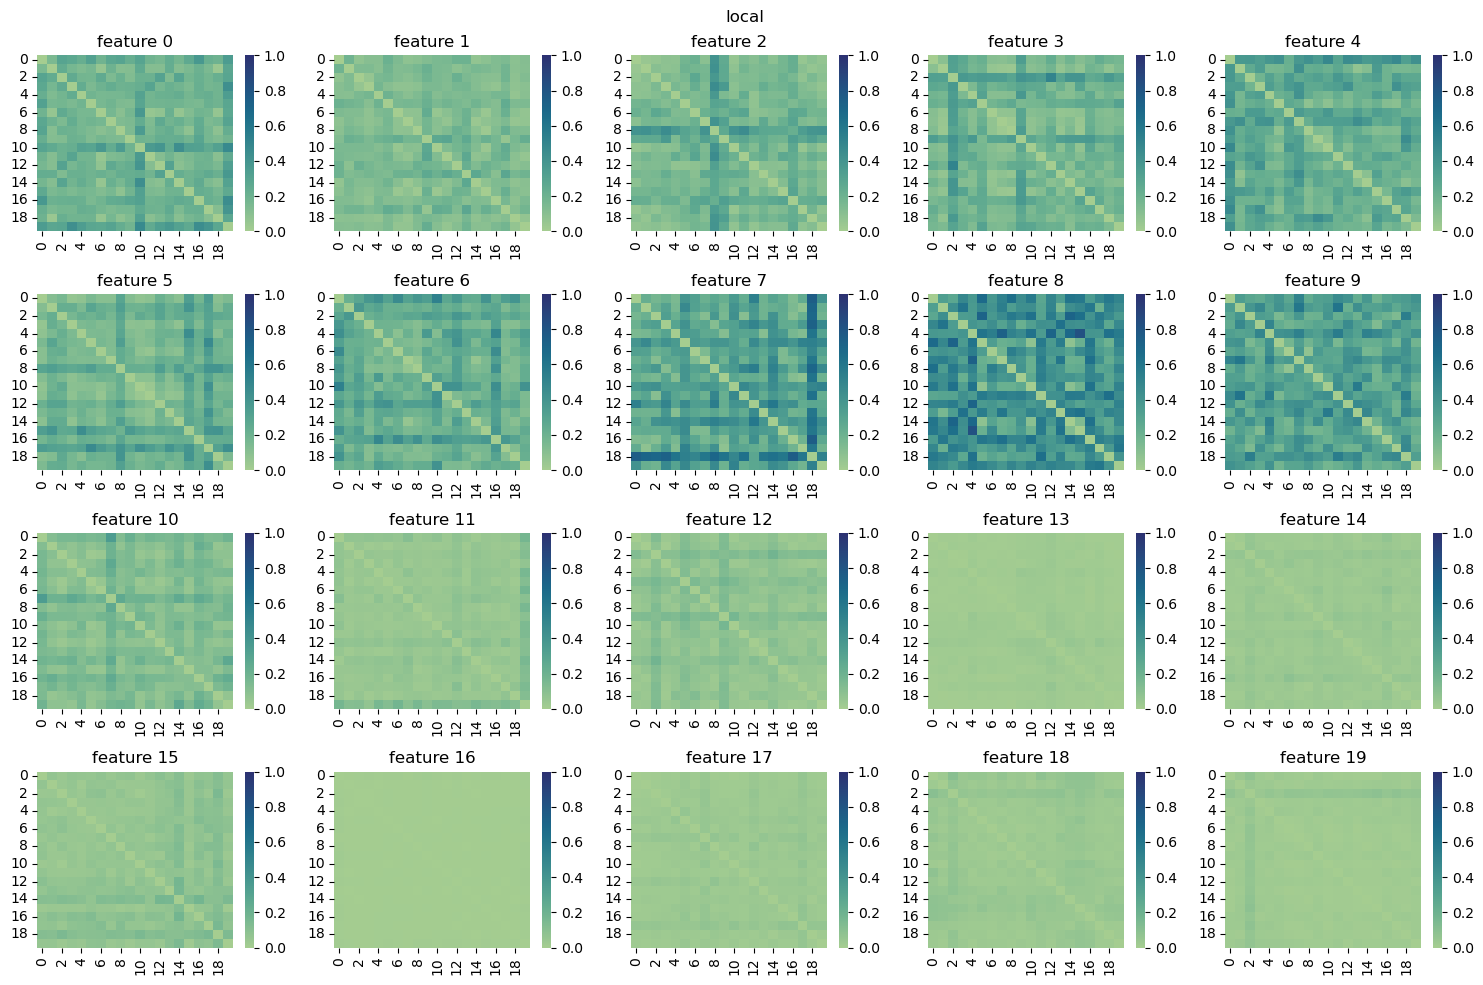

In [827]:
vis_local_model_sim(trackery1, iteration = 1, model='local')

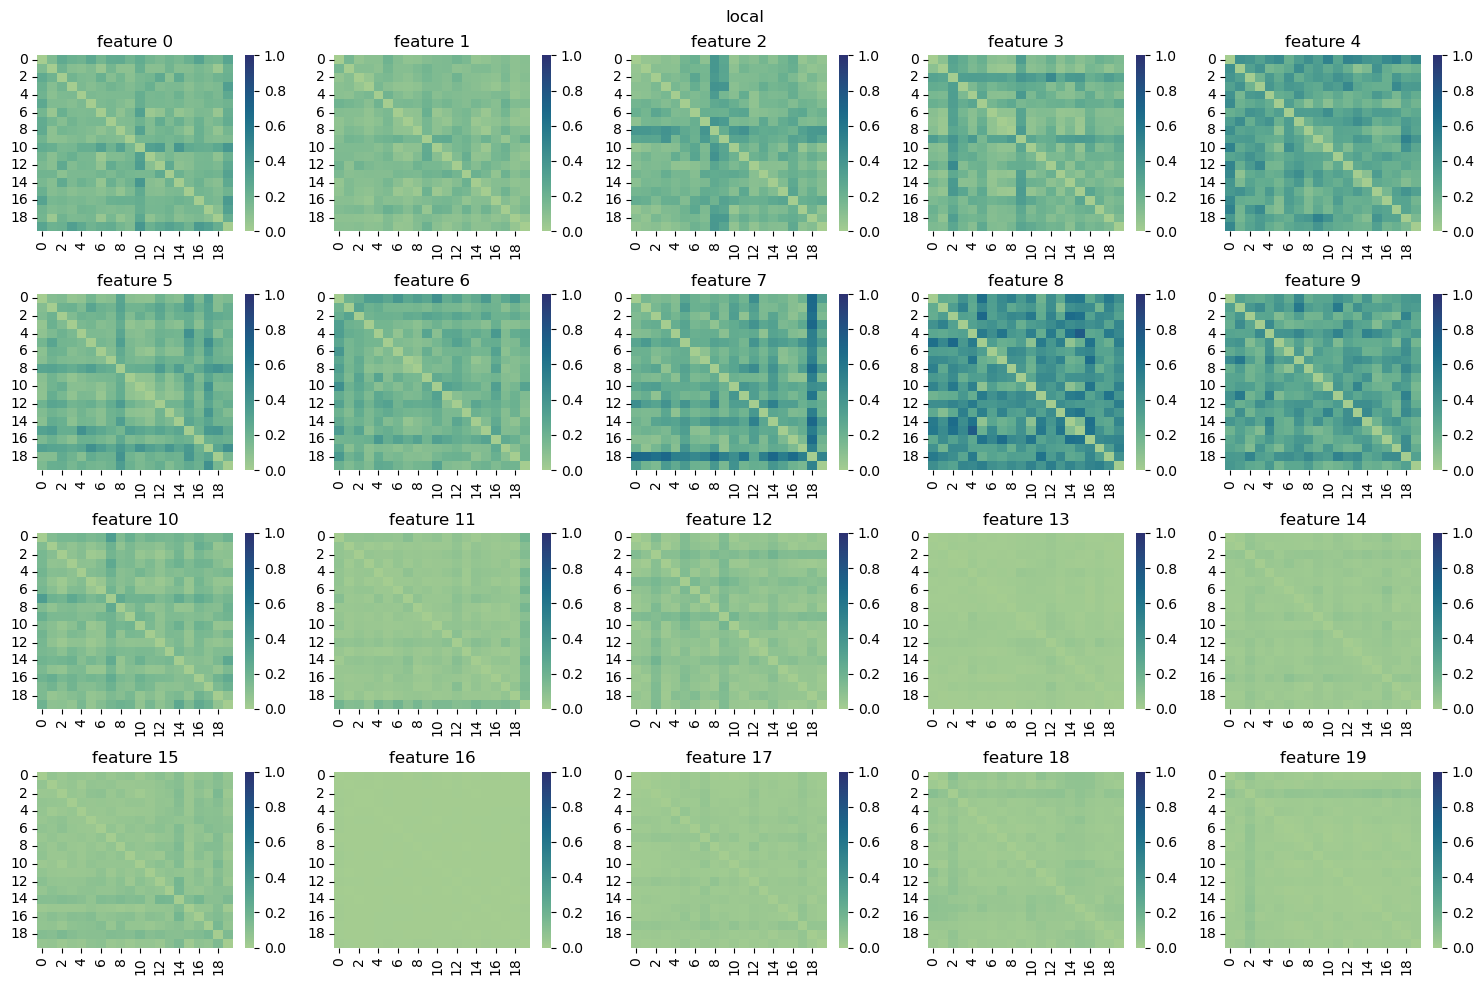

In [828]:
vis_local_model_sim(trackery1, iteration = 20, model='local')

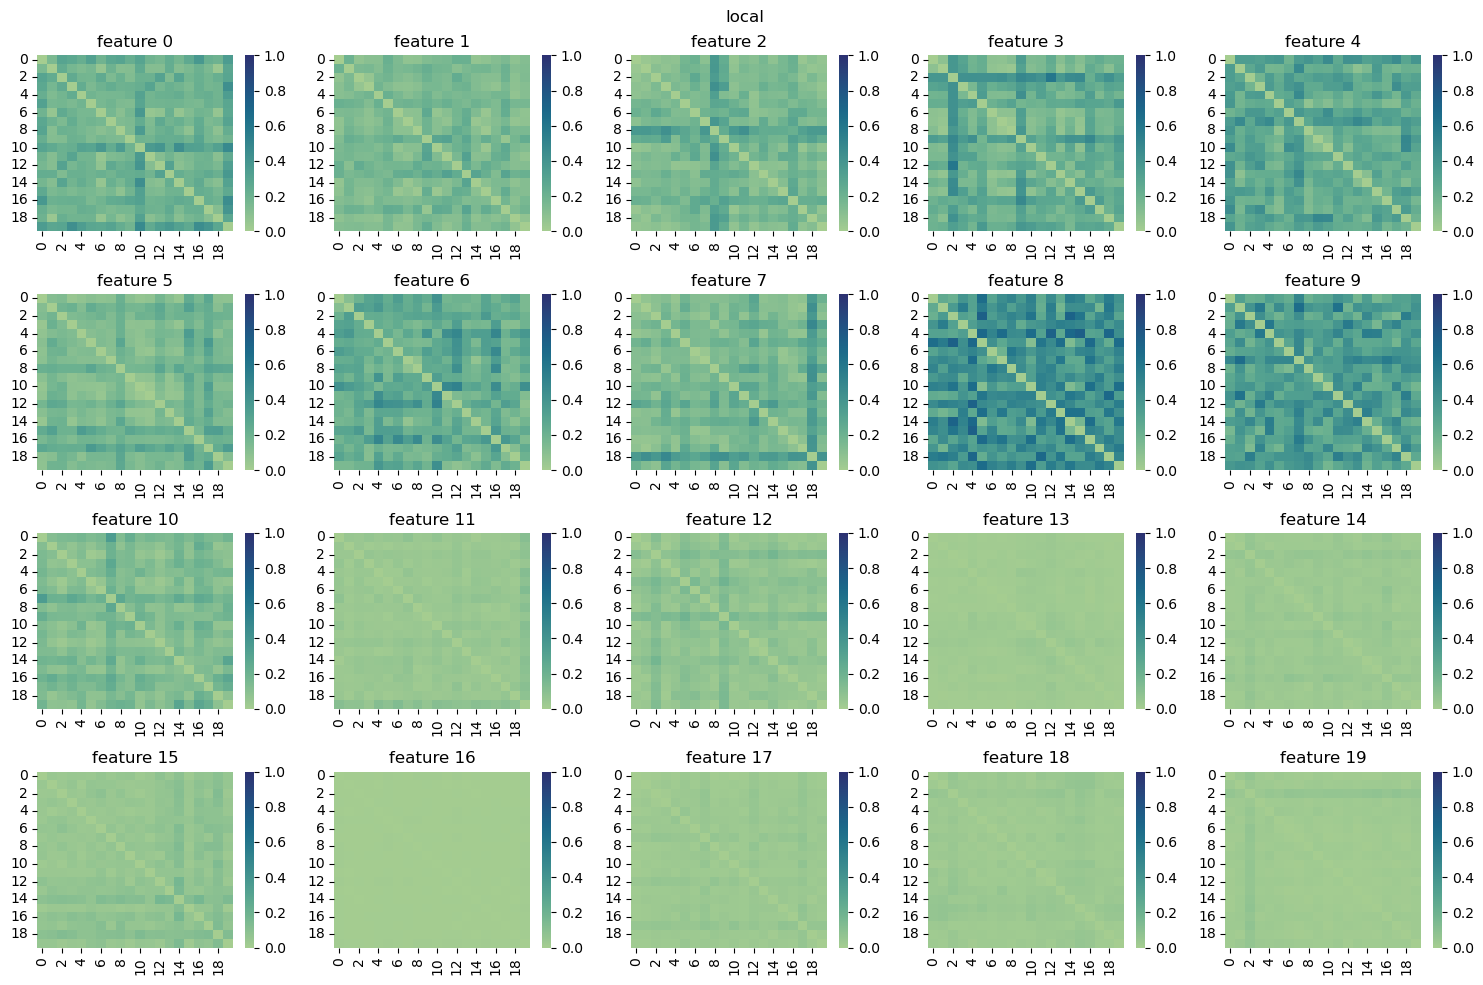

In [829]:
vis_local_model_sim(trackery2, iteration = 1, model='local')

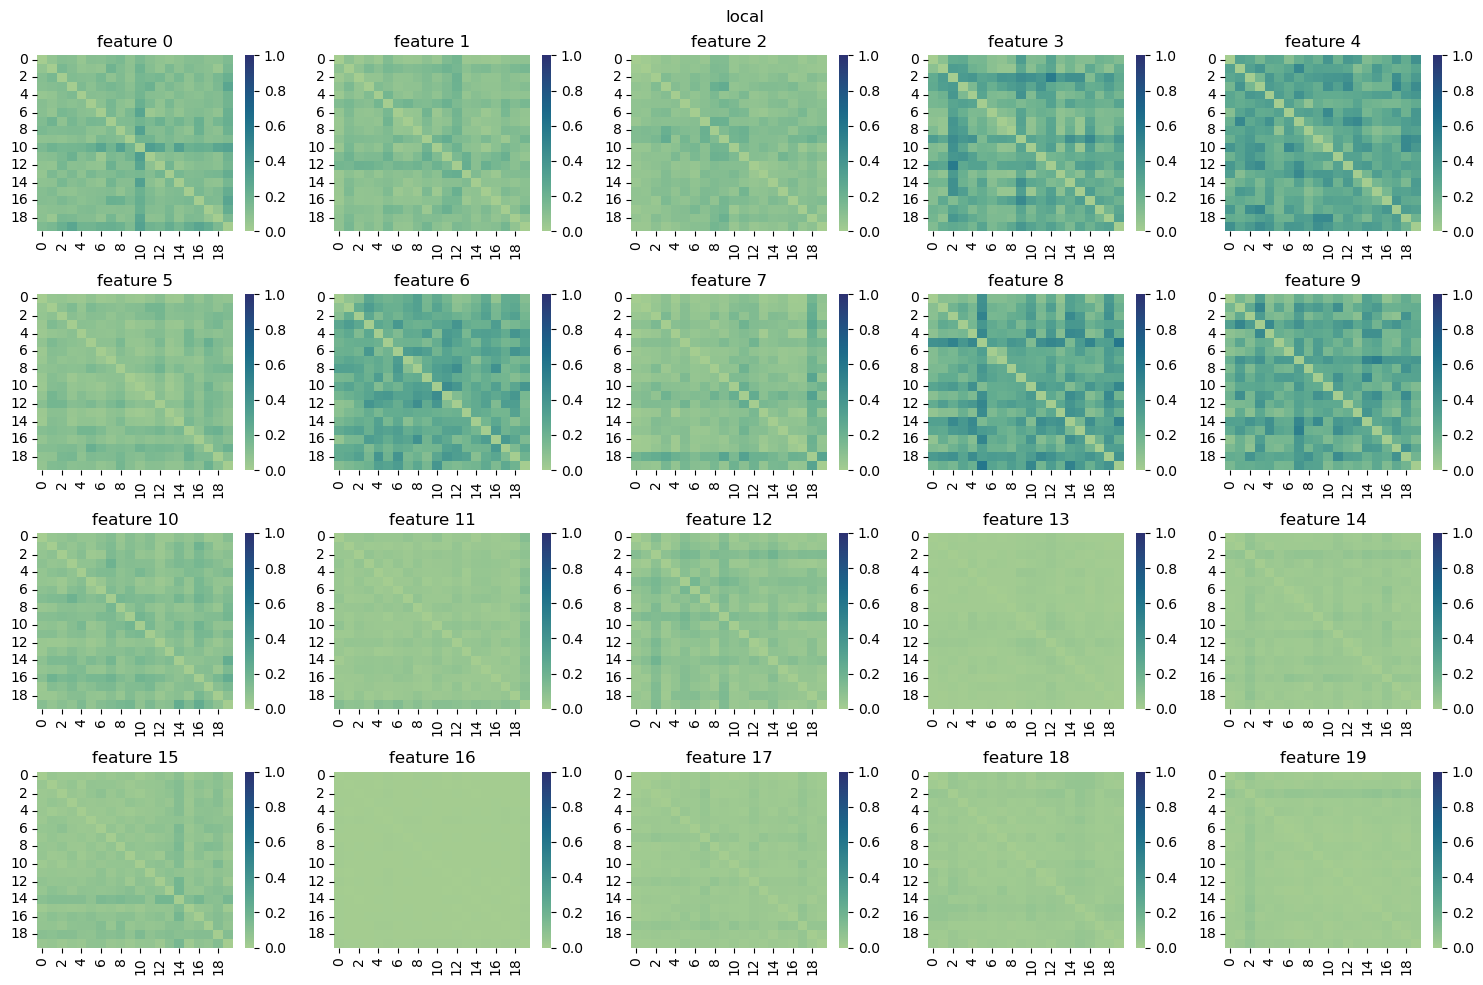

In [830]:
vis_local_model_sim(trackery2, iteration = 20, model='local')

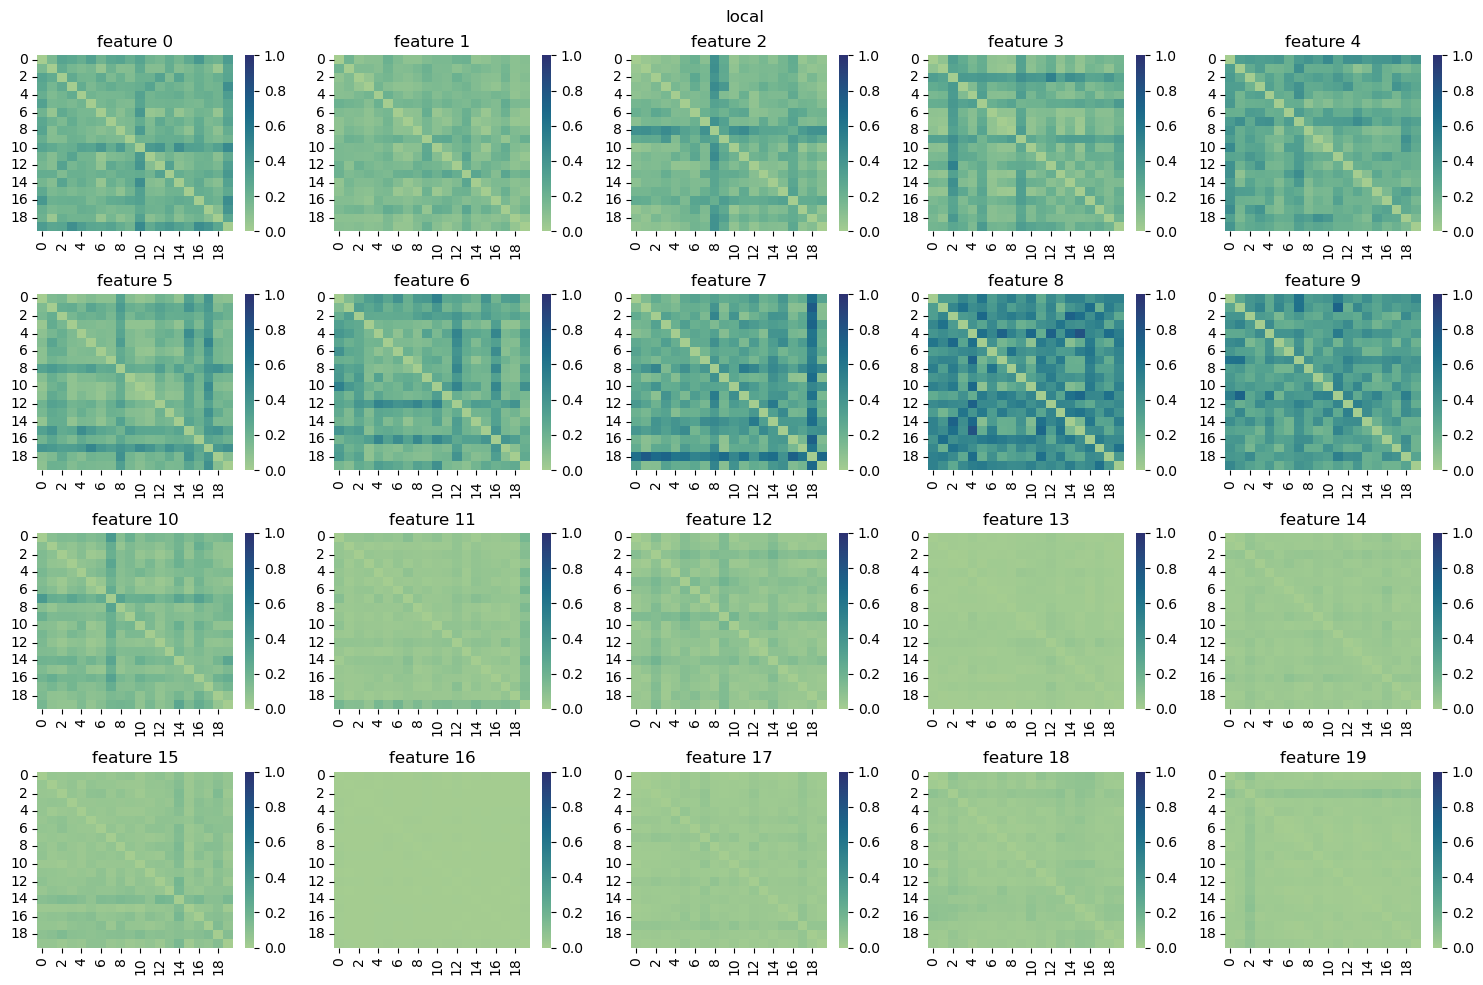

In [831]:
vis_local_model_sim(trackery3, iteration = 1, model='local')

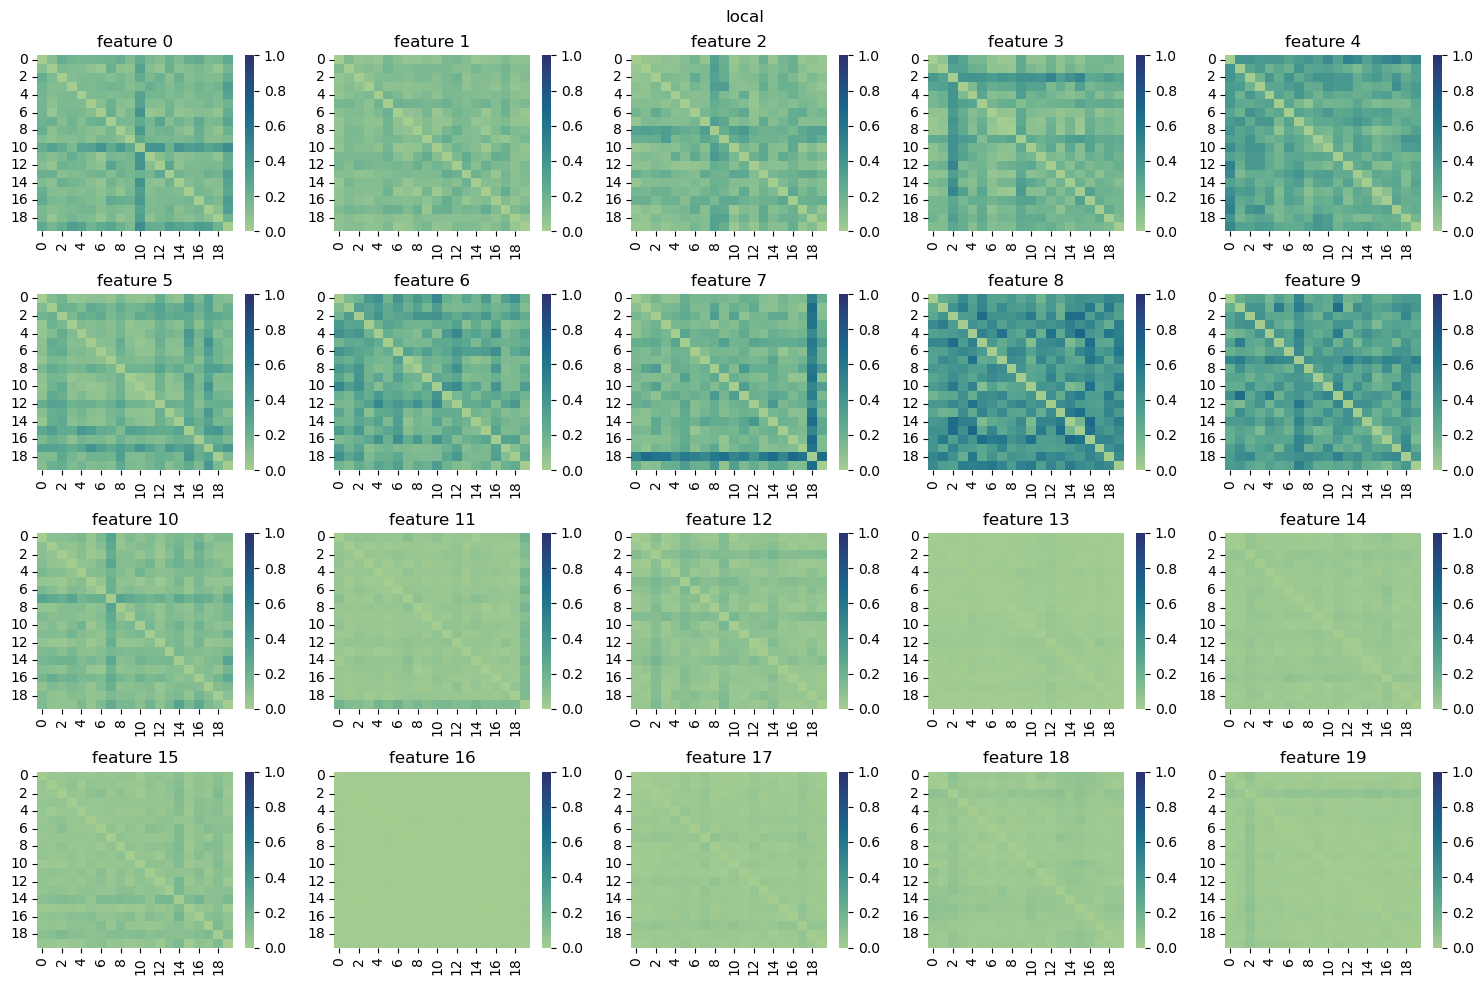

In [832]:
vis_local_model_sim(trackery3, iteration = 20, model='local')

#### Mechanism

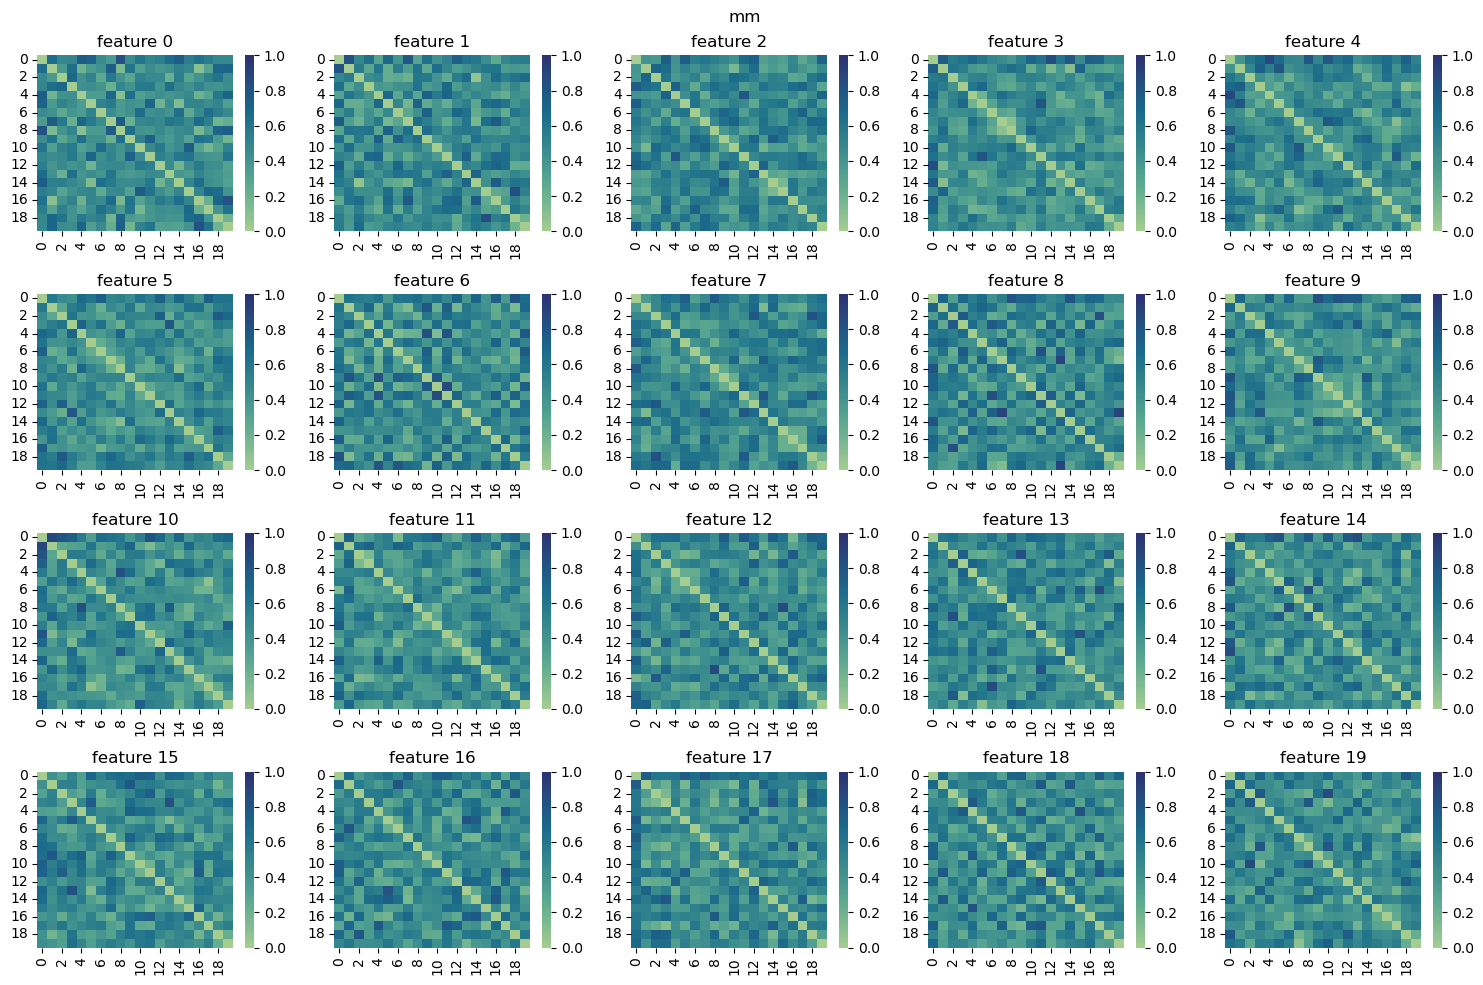

In [833]:
vis_local_model_sim(trackery1, iteration = 1, model='mm')

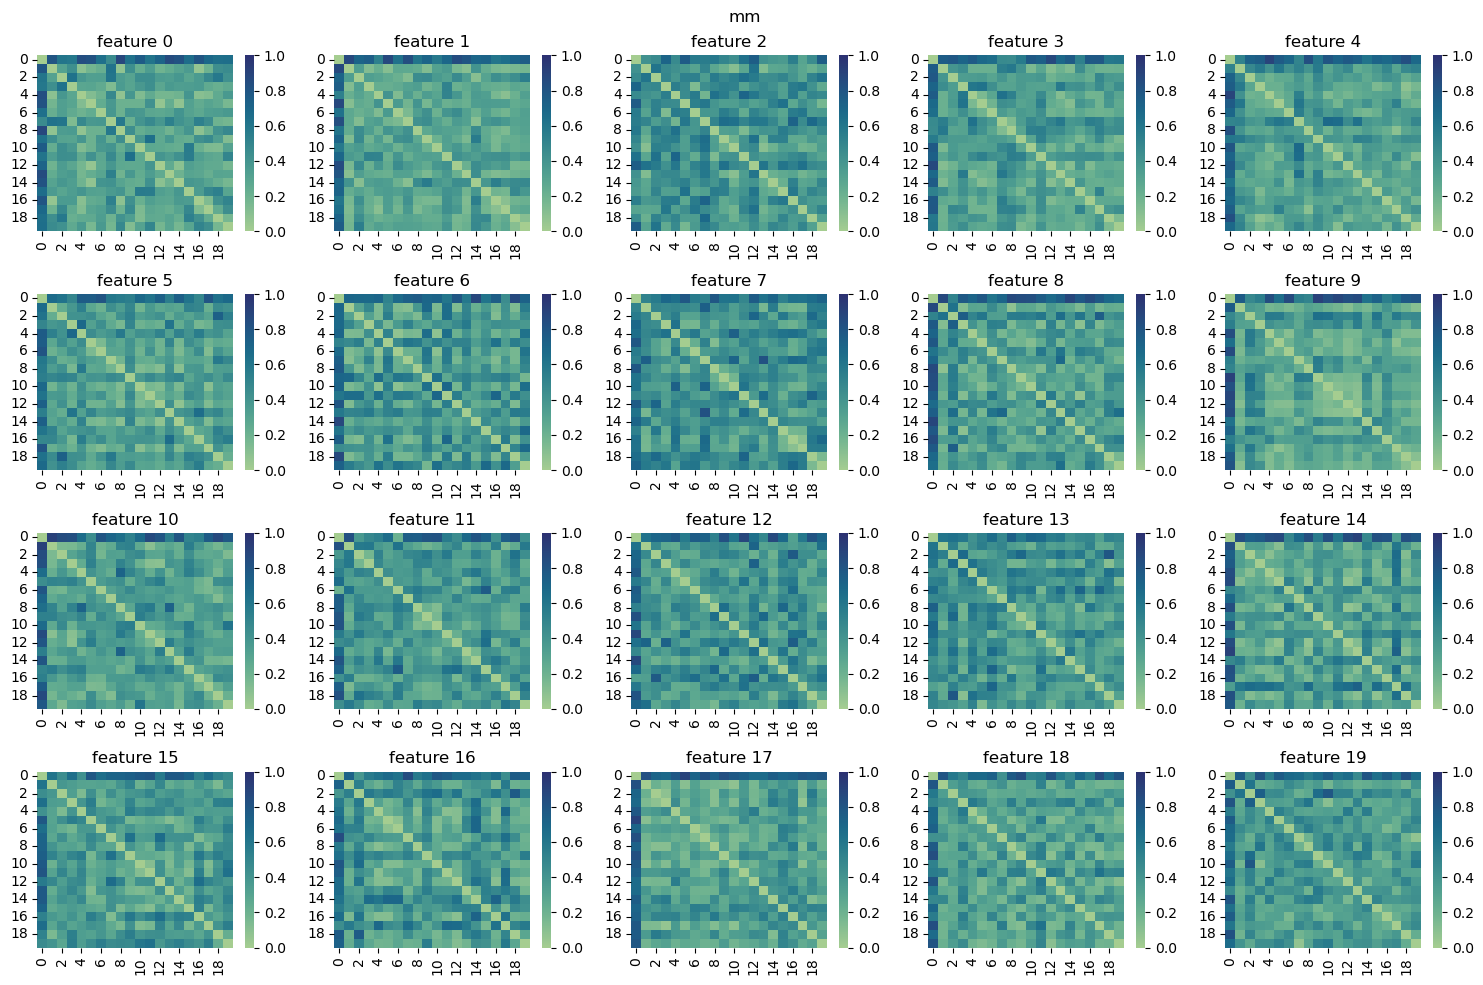

In [835]:
vis_local_model_sim(trackery2, iteration = 20, model='mm')

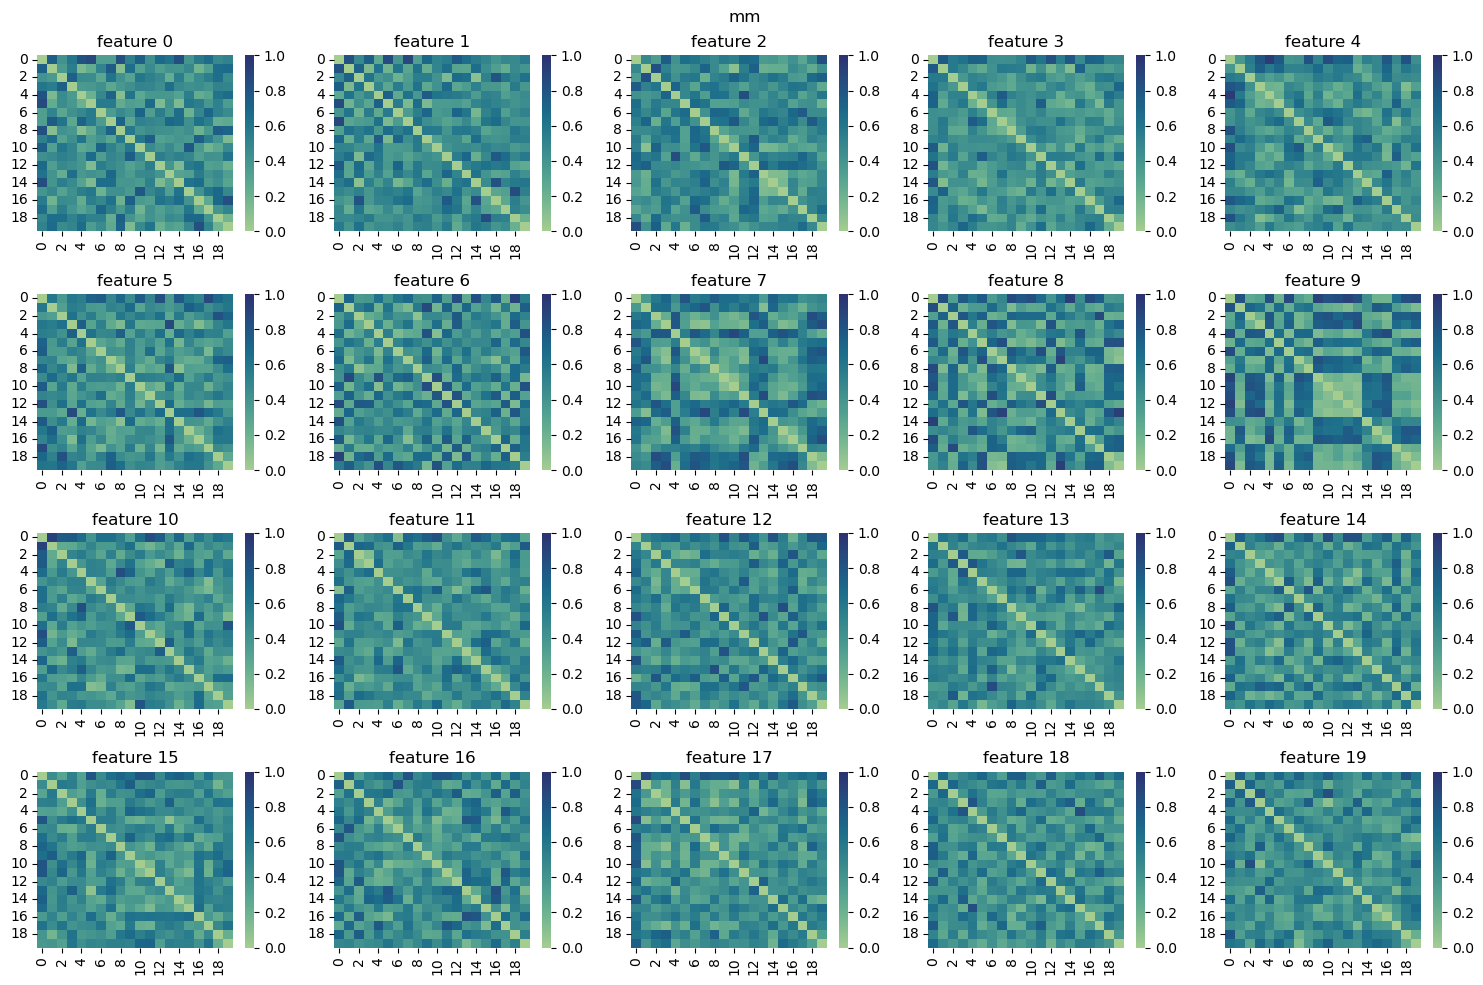

In [834]:
vis_local_model_sim(trackery3, iteration = 20, model='mm')